<div style="font-size: 8px;">

# Training and Evaluation: Individual Models

================================================================================
PURPOSE: Train and evaluate classifiers on features from each model separately
================================================================================

This notebook trains multiple classifiers on Context Tree features extracted
from individual transformer models. Each model (BERT, RoBERTa, DeBERTa, XLNet)
is evaluated separately to assess their individual performance on the clarity
and evasion classification tasks.

**Workflow:**
1. Load features from Google Drive (saved by 02_feature_extraction_separate.ipynb)
2. Train multiple classifiers on each model's features
3. Evaluate on Dev set (model selection and hyperparameter tuning)
4. Save predictions and probabilities for further analysis
5. Generate results tables and evaluation plots

**Classifiers:**
- Logistic Regression
- Linear Support Vector Classifier (LinearSVC)
- Random Forest
- XGBoost
- LightGBM

**Output:**
- Predictions (hard labels) and probabilities saved to Google Drive
- Results tables comparing classifiers for each model/task combination
- Evaluation plots (confusion matrices, PR curves, ROC curves)
- Results metadata saved for final summary generation

================================================================================
INPUTS (What this notebook loads)
================================================================================

**From GitHub:**
- Repository code (cloned automatically if not present)
- Source modules from `src/` directory:
  - `src.storage.manager` (StorageManager)
  - `src.models.trainer` (training and evaluation functions)
  - `src.models.classifiers` (classifier definitions)
  - `src.evaluation.tables` (final summary table functions)

**From Google Drive:**
- Dataset splits: `splits/dataset_splits.pkl`
  - Train split (for label extraction)
  - Dev split (for label extraction)
- Feature matrices: `features/raw/X_{split}_{model}_{task}.npy`
  - For each model (bert, roberta, deberta, xlnet)
  - For each task (clarity, evasion)
  - For Train and Dev splits
  - Loaded via `storage.load_features(model, task, split)`

**From HuggingFace Hub:**
- Nothing (all features already extracted)

================================================================================
OUTPUTS (What this notebook saves)
================================================================================

**To Google Drive:**
- Predictions: `predictions/pred_{split}_{model}_{classifier}_{task}.npy`
  - Hard label predictions for Dev set
  - For each model/classifier/task combination
- Probabilities: `features/probabilities/probs_{split}_{model}_{classifier}_{task}.npy`
  - Probability distributions for Dev set
  - For each model/classifier/task combination
- Evaluation plots: `plots/{model}_{task}_{classifier}/`
  - Confusion matrices
  - Precision-Recall curves
  - ROC curves
- Final summary tables: `results/tables/`
  - `final_summary_all_models_classifiers_tasks.{csv,html,png}`
  - `final_summary_model_wise.{csv,html,png}`
  - `final_summary_classifier_wise.{csv,html,png}`
- Complete results dictionary: `results/all_results_dev.pkl`

**To GitHub:**
- Results metadata: `results/{model}_{task}_separate.json`
  - Metrics for each classifier
  - Train/Dev sample counts
  - Timestamp information
- Results dictionary (JSON): `results/all_results_dev.json`

**Evaluation Metrics Computed and Printed:**
- Accuracy
- Macro Precision, Recall, F1
- Weighted Precision, Recall, F1
- Per-class metrics (precision, recall, F1, support)
- Cohen's Kappa
- Matthews Correlation Coefficient
- Hamming Loss
- Jaccard Score (IoU)
- Confusion Matrix

**What gets passed to next notebook:**
- All predictions and probabilities saved to persistent storage
- Final summary tables (CSV, HTML, PNG formats)
- Results metadata for comparison with fusion approaches

</div>


In [1]:
# ============================================================================
# SETUP: Repository Clone, Drive Mount, and Path Configuration
# ============================================================================
# This cell performs minimal setup required for the notebook to run:
# 1. Clones repository from GitHub (if not already present)
# 2. Mounts Google Drive for persistent data storage
# 3. Configures Python paths and initializes StorageManager
# NOTE: Data splits are NOT loaded here - they are loaded per-task in the training loop

import shutil
import os
import subprocess
import time
import requests
import zipfile
import sys
import numpy as np
from pathlib import Path
from google.colab import drive

# Repository configuration
repo_dir = '/content/semeval-context-tree-modular'
repo_url = 'https://github.com/EonTechie/semeval-context-tree-modular.git'
zip_url = 'https://github.com/EonTechie/semeval-context-tree-modular/archive/refs/heads/main.zip'

# Clone repository (if not already present)
if not os.path.exists(repo_dir):
    print("Cloning repository from GitHub...")
    max_retries = 2
    clone_success = False

    for attempt in range(max_retries):
        try:
            result = subprocess.run(
                ['git', 'clone', repo_url],
                cwd='/content',
                capture_output=True,
                text=True,
                timeout=60
            )
            if result.returncode == 0:
                print("Repository cloned successfully via git")
                clone_success = True
                break
            else:
                if attempt < max_retries - 1:
                    time.sleep(3)
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(3)

    # Fallback: Download as ZIP if git clone fails
    if not clone_success:
        print("Git clone failed. Downloading repository as ZIP archive...")
        zip_path = '/tmp/repo.zip'
        try:
            response = requests.get(zip_url, stream=True, timeout=60)
            response.raise_for_status()
            with open(zip_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall('/content')
            extracted_dir = '/content/semeval-context-tree-modular-main'
            if os.path.exists(extracted_dir):
                os.rename(extracted_dir, repo_dir)
            os.remove(zip_path)
            print("Repository downloaded and extracted successfully")
        except Exception as e:
            raise RuntimeError(f"Failed to obtain repository: {e}")

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive', force_remount=False)
except Exception:
    pass  # Already mounted

# Configure paths
BASE_PATH = Path('/content/semeval-context-tree-modular')
DATA_PATH = Path('/content/drive/MyDrive/semeval_data')

# Verify repository structure exists
if not BASE_PATH.exists():
    raise RuntimeError(f"Repository directory not found: {BASE_PATH}")
if not (BASE_PATH / 'src').exists():
    raise RuntimeError(f"src directory not found in repository: {BASE_PATH / 'src'}")
if not (BASE_PATH / 'src' / 'storage' / 'manager.py').exists():
    raise RuntimeError(f"Required file not found: {BASE_PATH / 'src' / 'storage' / 'manager.py'}")

# Add repository to Python path
sys.path.insert(0, str(BASE_PATH))

# Verify imports work
try:
    from src.storage.manager import StorageManager
    from src.models.trainer import train_and_evaluate
    from src.models.classifiers import get_classifier_dict
except ImportError as e:
    raise ImportError(
        f"Failed to import required modules. "
        f"Repository path: {BASE_PATH}, "
        f"Python path: {sys.path[:3]}, "
        f"Error: {e}"
    )

# Initialize StorageManager
storage = StorageManager(
    base_path=str(BASE_PATH),
    data_path=str(DATA_PATH),
    github_path=str(BASE_PATH)
)

print("Setup complete")
print(f"  Repository: {BASE_PATH}")
print(f"  Data storage: {DATA_PATH}")
print(f"\nNOTE: Data splits will be loaded per-task in the training loop")
print(f"      Clarity and Evasion have different splits (Evasion uses majority voting)")


Cloning repository from GitHub...
Repository cloned successfully via git
Mounted at /content/drive
Setup complete
  Repository: /content/semeval-context-tree-modular
  Data storage: /content/drive/MyDrive/semeval_data

NOTE: Data splits will be loaded per-task in the training loop
      Clarity and Evasion have different splits (Evasion uses majority voting)


In [2]:
# ============================================================================
# REPRODUCIBILITY SETUP: Set Random Seeds for All Libraries
# ============================================================================
# This cell sets random seeds for Python, NumPy, PyTorch, and HuggingFace
# to ensure reproducible results across all runs.
#
# IMPORTANT: Run this cell FIRST before any other code that uses randomness.
# Seed value: 42 (same as used in all other parts of the pipeline)

from src.utils.reproducibility import set_all_seeds

# Set all random seeds to 42 for full reproducibility
# deterministic=True ensures PyTorch operations are deterministic (slower but fully reproducible)
set_all_seeds(seed=42, deterministic=True)

print("✓ Reproducibility configured: All random seeds set to 42")
print("✓ PyTorch deterministic mode enabled")
print("\nNOTE: If you encounter performance issues or non-deterministic behavior,")
print("      you can set deterministic=False in set_all_seeds() call above.")


✓ Reproducibility seeds set to 42
✓ PyTorch deterministic mode enabled (may be slower)
✓ Reproducibility configured: All random seeds set to 42
✓ PyTorch deterministic mode enabled

NOTE: If you encounter performance issues or non-deterministic behavior,
      you can set deterministic=False in set_all_seeds() call above.


In [3]:
# ============================================================================
# CONFIGURE MODELS, TASKS, AND CLASSIFIERS
# ============================================================================
# Defines the models to evaluate, tasks to perform, and classifiers to train
# Label mappings are defined for clarity (3-class) and evasion (9-class) tasks

MODELS = ['bert', 'bert_political', 'bert_ambiguity', 'roberta', 'deberta', 'xlnet']
TASKS = ['clarity', 'evasion']

# Label mappings for each task
CLARITY_LABELS = ['Ambivalent', 'Clear Non-Reply', 'Clear Reply']
EVASION_LABELS = ['Claims ignorance', 'Clarification', 'Declining to answer',
                  'Deflection', 'Dodging', 'Explicit',
                  'General', 'Implicit', 'Partial/half-answer']

# Initialize classifiers with fixed random seed for reproducibility
classifiers = get_classifier_dict(random_state=42)

print("Configuration:")
print(f"  Models: {MODELS}")
print(f"  Tasks: {TASKS}")
print(f"  Classifiers: {list(classifiers.keys())}")
print(f"  Clarity labels: {len(CLARITY_LABELS)} classes")
print(f"  Evasion labels: {len(EVASION_LABELS)} classes")


Configuration:
  Models: ['bert', 'bert_political', 'bert_ambiguity', 'roberta', 'deberta', 'xlnet']
  Tasks: ['clarity', 'evasion']
  Classifiers: ['LogisticRegression', 'LinearSVC', 'RandomForest', 'MLP', 'XGBoost', 'LightGBM']
  Clarity labels: 3 classes
  Evasion labels: 9 classes


In [4]:
# ============================================================================
# LOAD PREVIOUS RESULTS (Skip if already loaded)
# ============================================================================
# This cell loads previously saved results from Drive
# Use this when you restart runtime and want to continue from hierarchical evaluation
# without re-running all training

# Check if all_results is already populated (from Cell 3)
if 'all_results' in globals() and all_results and len(all_results) > 0:
    print("="*80)
    print("RESULTS ALREADY LOADED")
    print("="*80)
    print(f"✓ all_results already contains {len(all_results)} models")
    print("  Skipping load - continuing with existing results")
    print("\nYou can proceed directly to hierarchical evaluation cell")
else:
    print("="*80)
    print("LOADING PREVIOUS RESULTS FROM DRIVE")
    print("="*80)

    # Try to load from Drive
    try:
        all_results = storage.load_all_results_dict(filename='all_results_dev.pkl')

        if all_results and len(all_results) > 0:
            print(f"✓ Successfully loaded results for {len(all_results)} models")
            for model in all_results:
                tasks = list(all_results[model].keys())
                print(f"  {model}: {tasks}")
            print("\n✓ You can now proceed to hierarchical evaluation cell")
            print("  Training is NOT needed - using saved results")
        else:
            print(" No saved results found in Drive")
            print("  You need to run Cell 3 (Training cell) first")
            print("  Or check if results were saved with a different filename")
    except Exception as e:
        print(f"✗ Error loading results: {e}")
        print("  You need to run Cell 3 (Training cell) first")
        raise


LOADING PREVIOUS RESULTS FROM DRIVE
 No saved results found in Drive
  You need to run Cell 3 (Training cell) first
  Or check if results were saved with a different filename



Results Table: bert_clarity
        Classifier         Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
      RandomForest bert_clarity  0.582609  0.513378     0.572970         0.542882      0.495964
           XGBoost bert_clarity  0.579710  0.507448     0.572013         0.545275      0.487321
          LightGBM bert_clarity  0.585507  0.506654     0.572565         0.542787      0.487791
         LinearSVC bert_clarity  0.559420  0.444066     0.539029         0.452149      0.450083
LogisticRegression bert_clarity  0.447826  0.425782     0.463267         0.429716      0.480698
               MLP bert_clarity  0.605797  0.387793     0.522173         0.645576      0.395250

Per-Class Metrics: bert_clarity - RandomForest (Best by Macro F1)
          Class  Precision   Recall  F1-Score  Support
     Ambivalent   0.648707 0.728814  0.686431      413
Clear Non-Reply   0.587302 0.420455  0.490066       88
    Clear Reply   0.392638 0.338624  0.363636      189



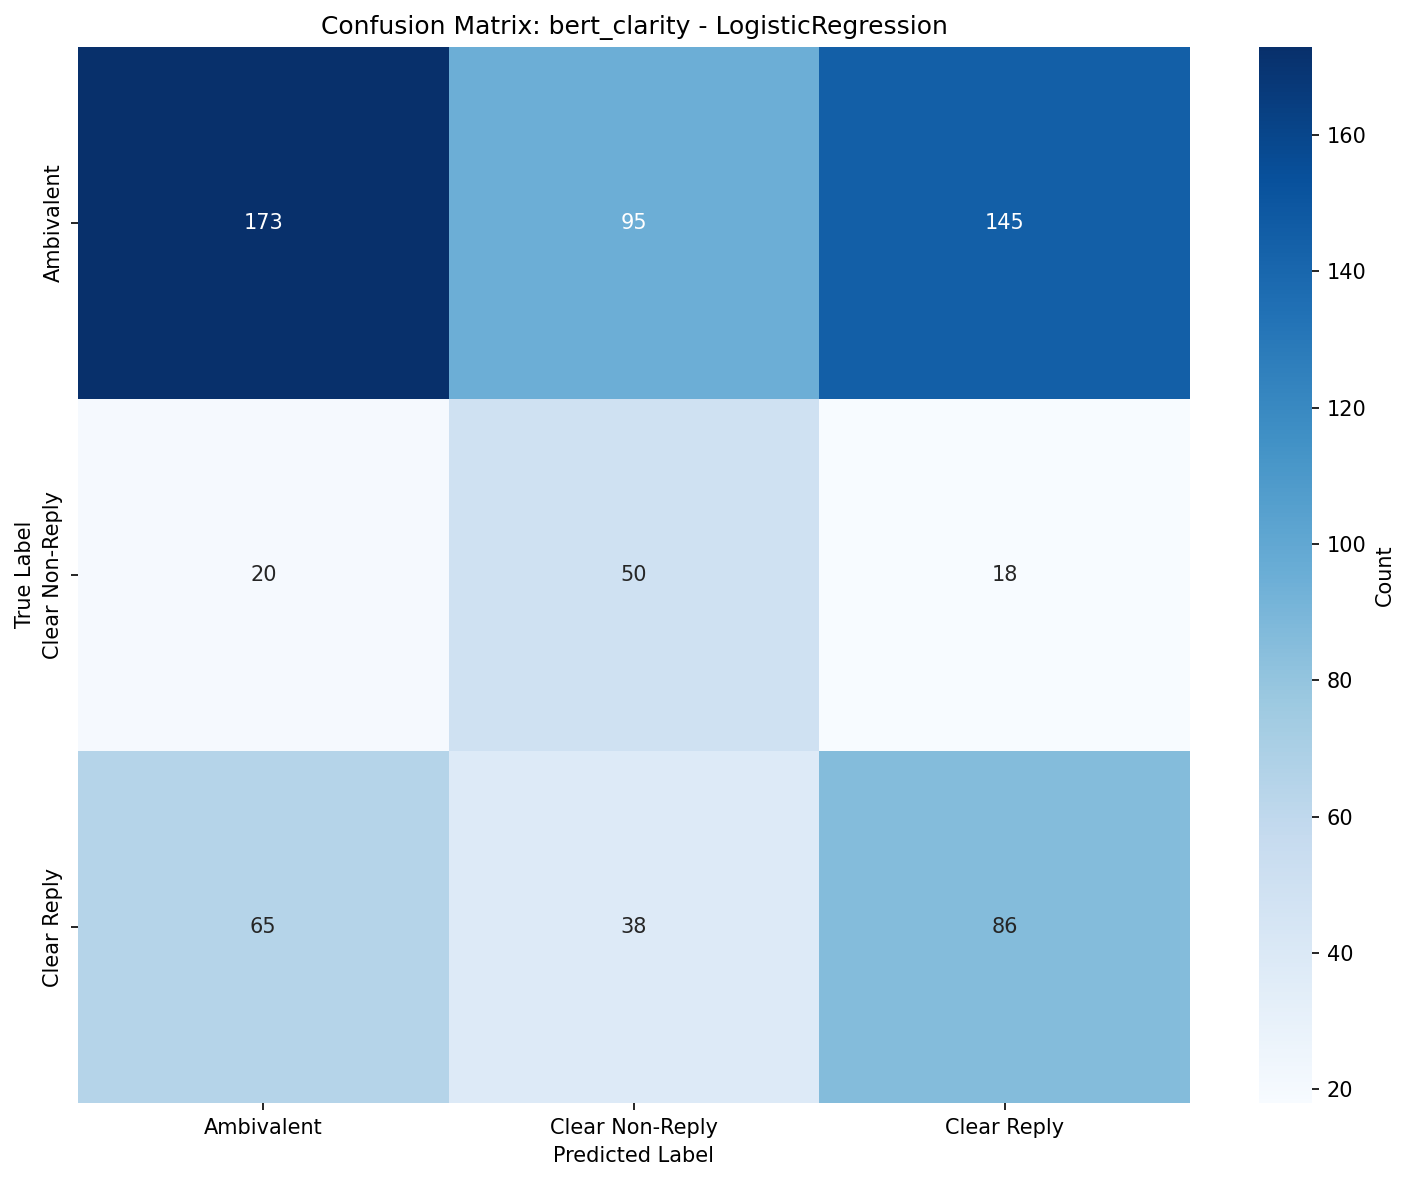

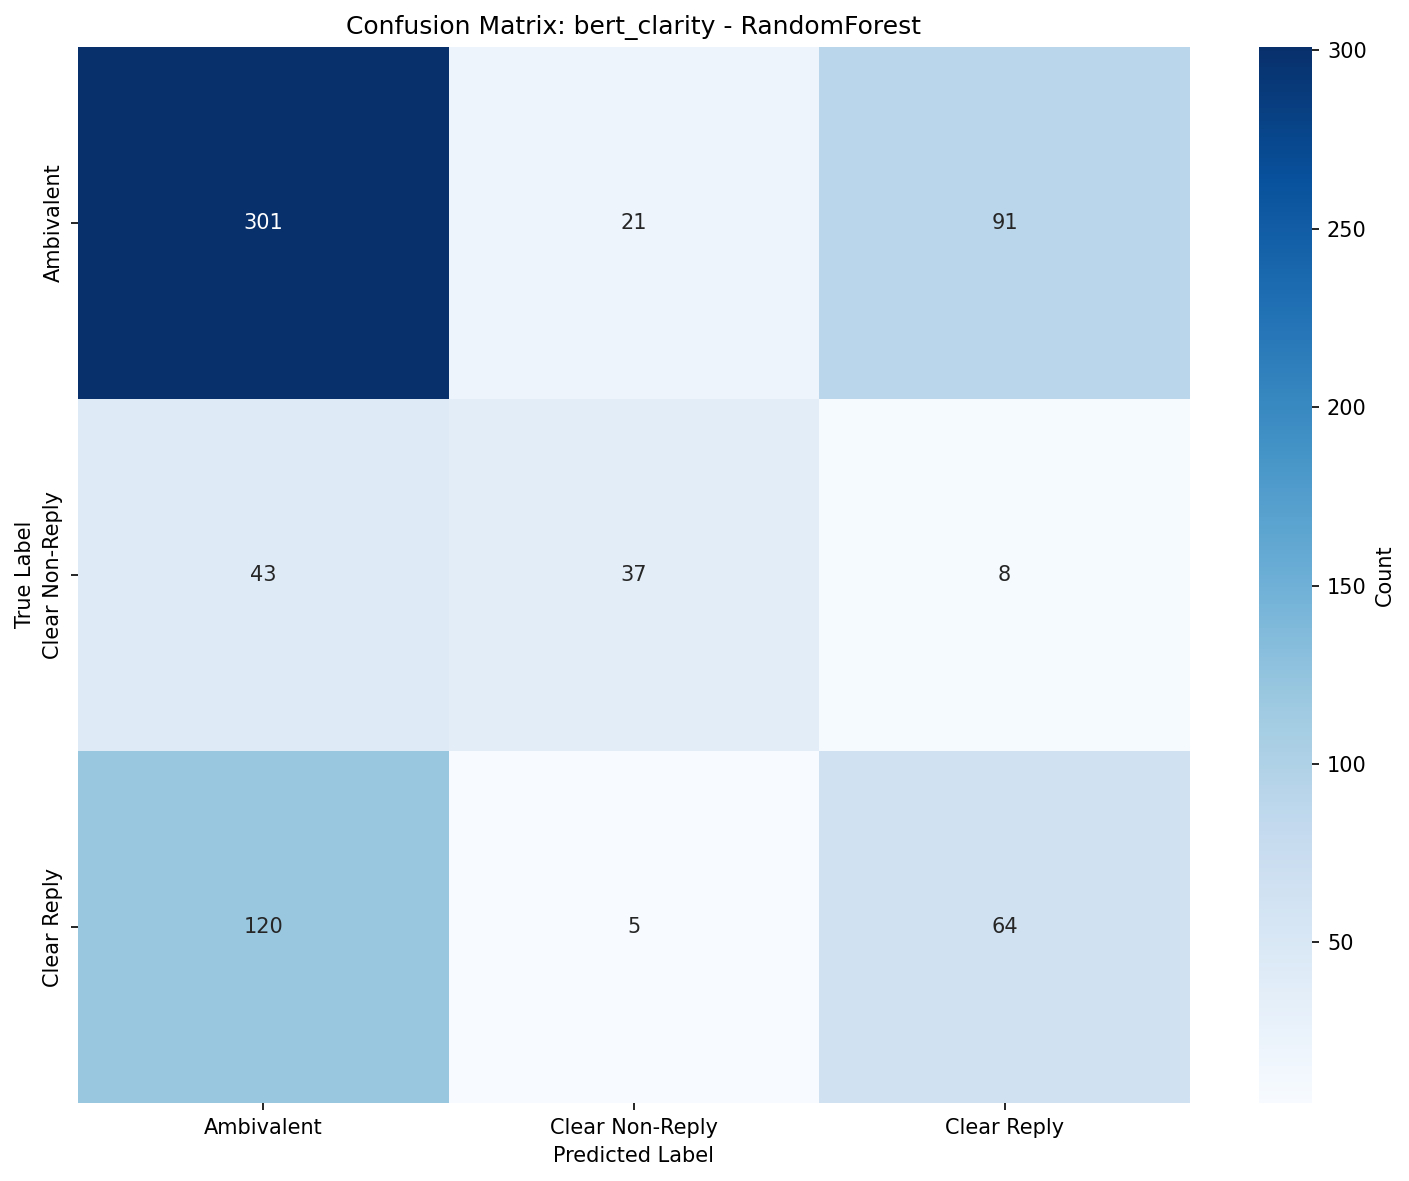

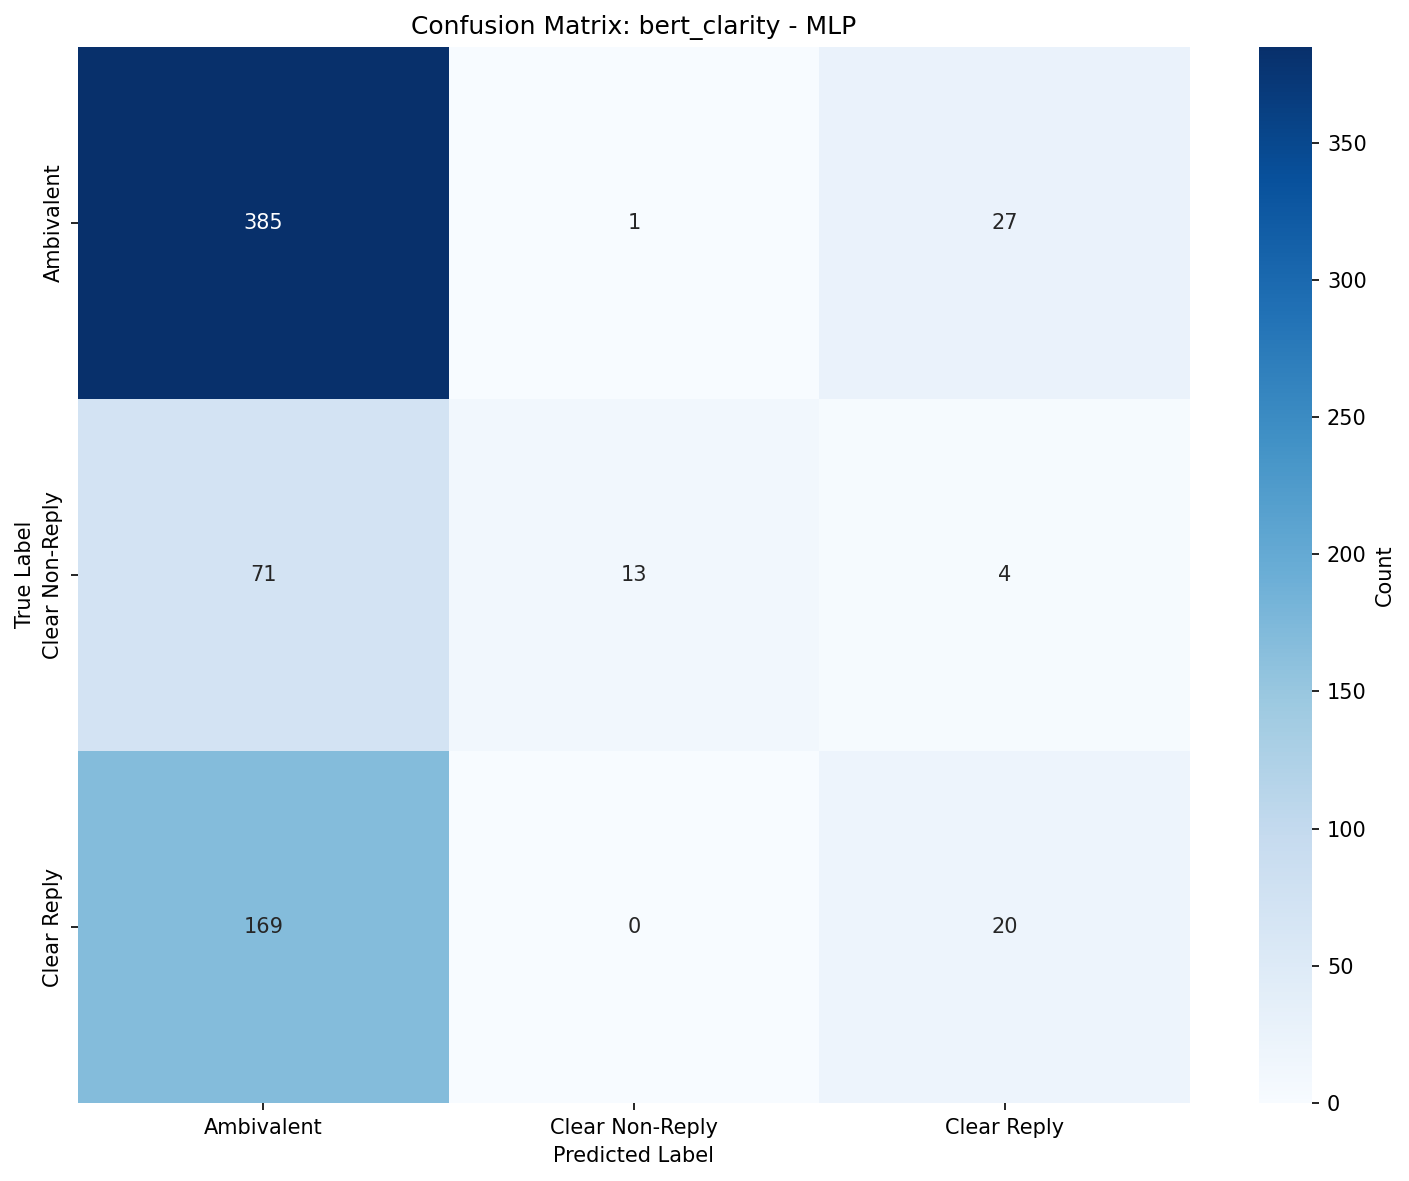

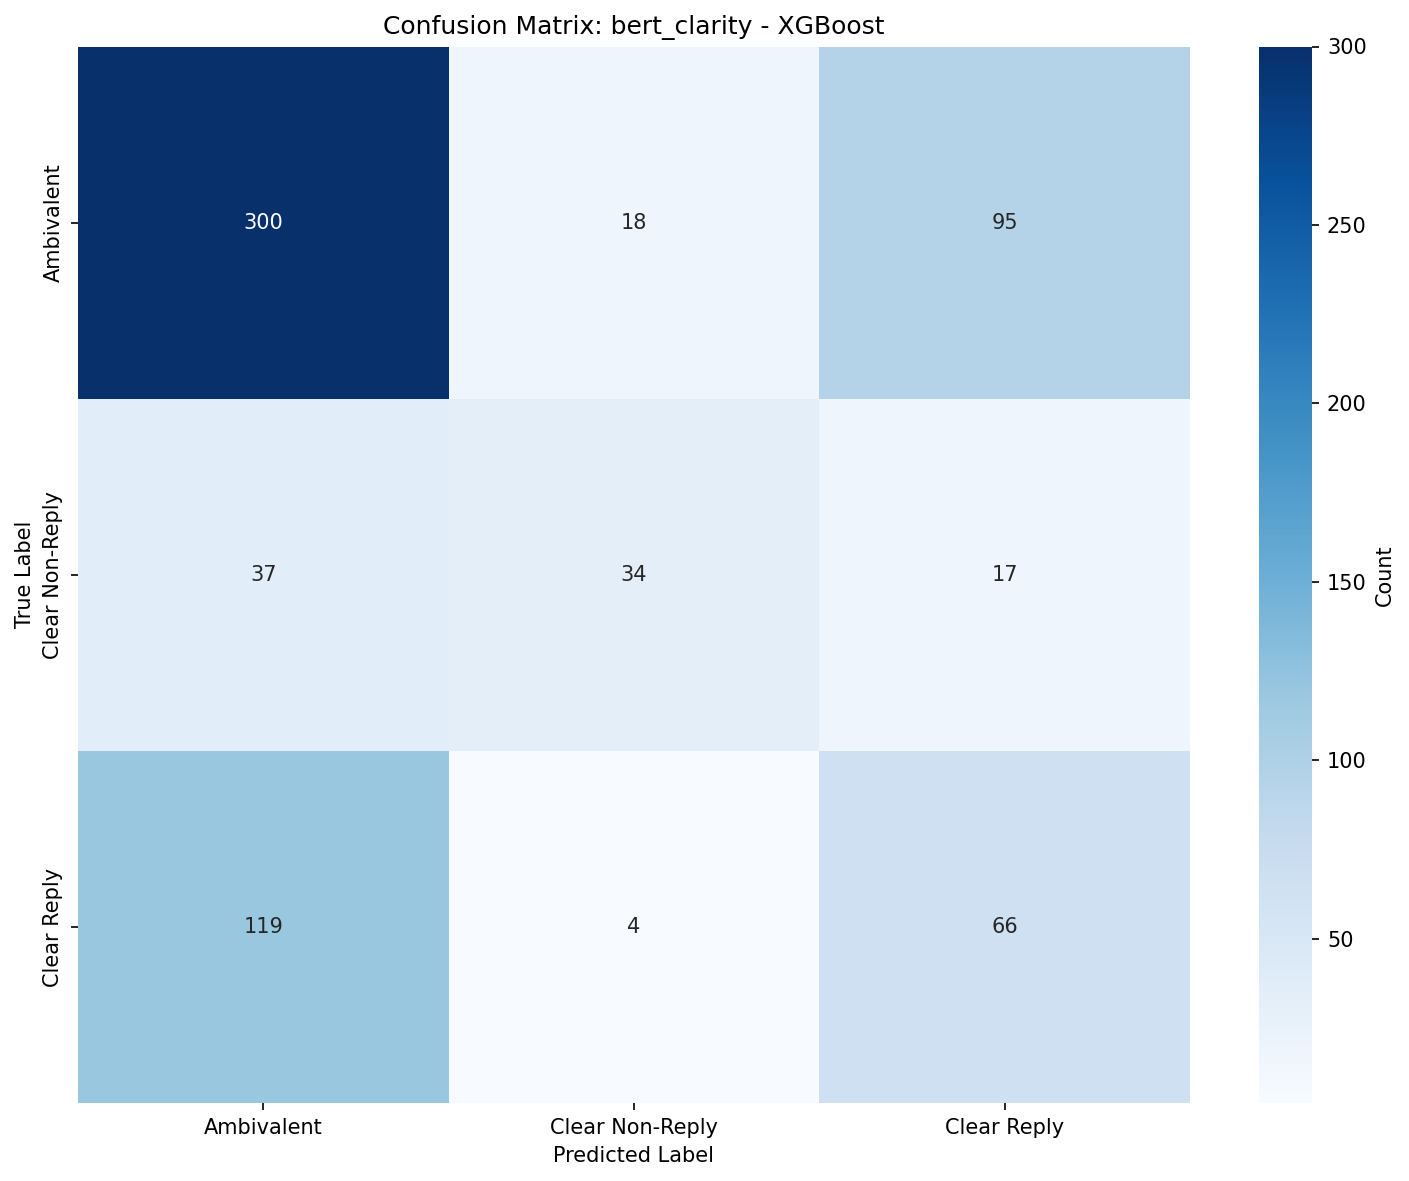

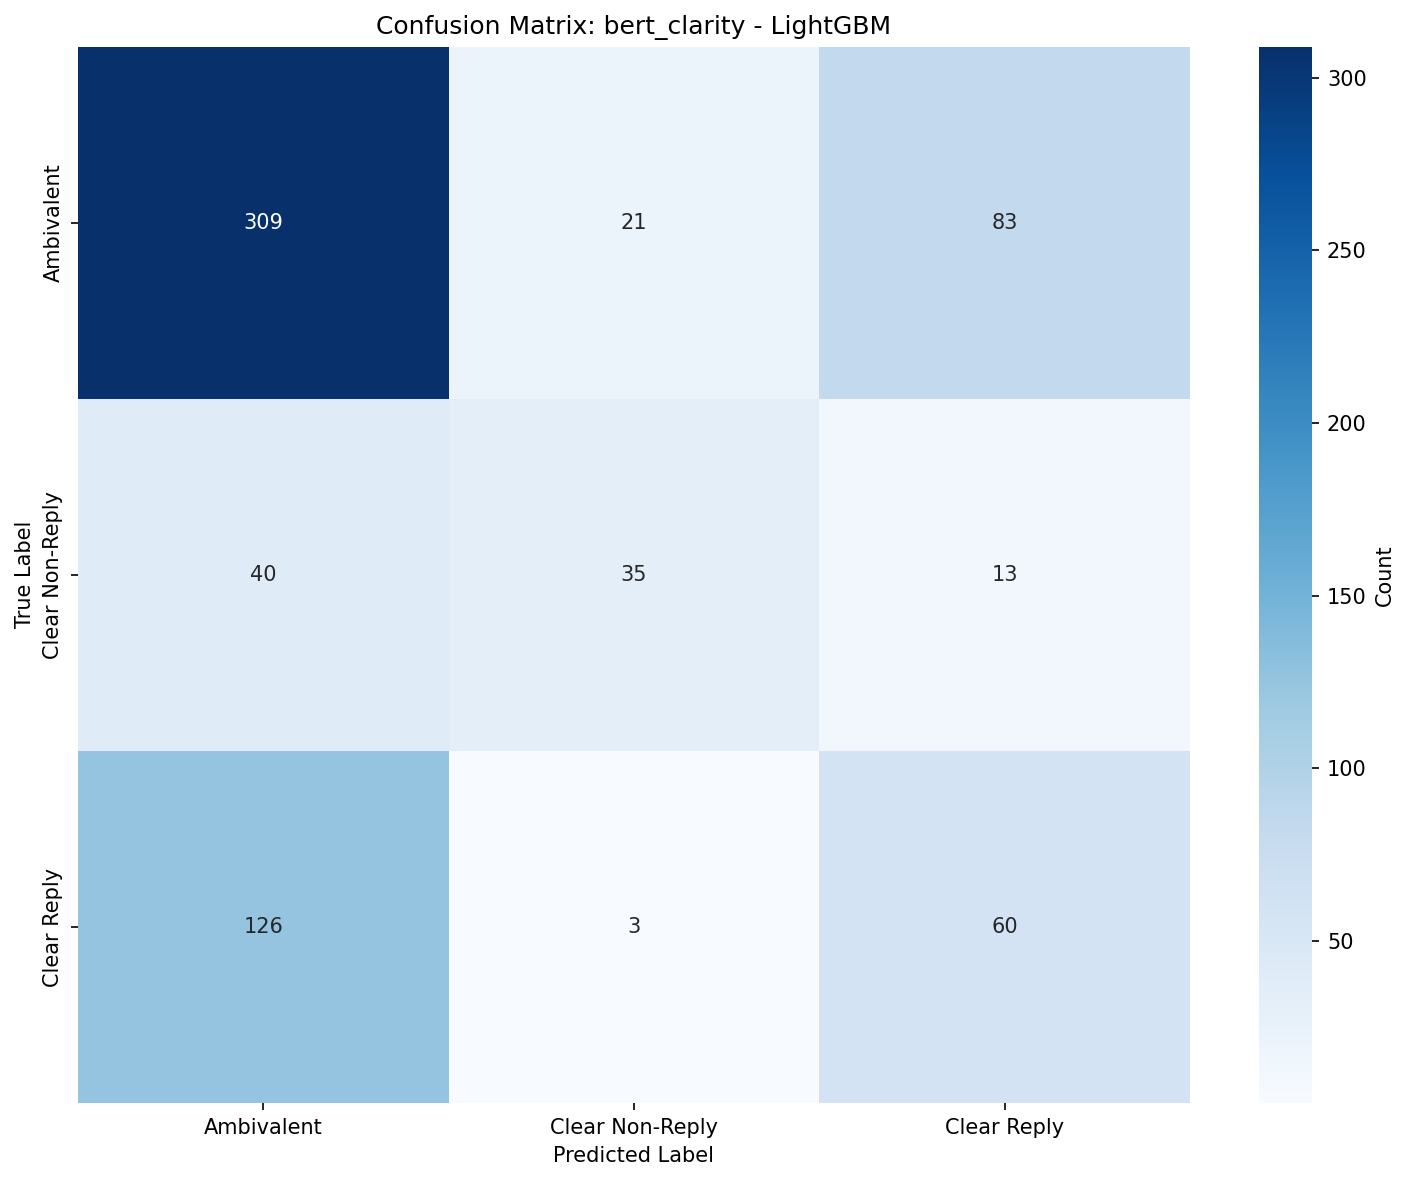


Results Table: bert_evasion
        Classifier         Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
      RandomForest bert_evasion  0.343478  0.312310     0.332792         0.354771      0.294268
          LightGBM bert_evasion  0.324638  0.298941     0.315489         0.354473      0.273890
           XGBoost bert_evasion  0.323188  0.296121     0.313917         0.334529      0.277922
         LinearSVC bert_evasion  0.240580  0.210076     0.237270         0.227239      0.272030
               MLP bert_evasion  0.304348  0.194253     0.253622         0.255760      0.192773
LogisticRegression bert_evasion  0.169565  0.176112     0.172932         0.186024      0.244194

Per-Class Metrics: bert_evasion - RandomForest (Best by Macro F1)
              Class  Precision   Recall  F1-Score  Support
   Claims ignorance   0.411765 0.259259  0.318182       27
      Clarification   0.761905 0.571429  0.653061       28
Declining to answer   0.500000 0.303030  0.377358      

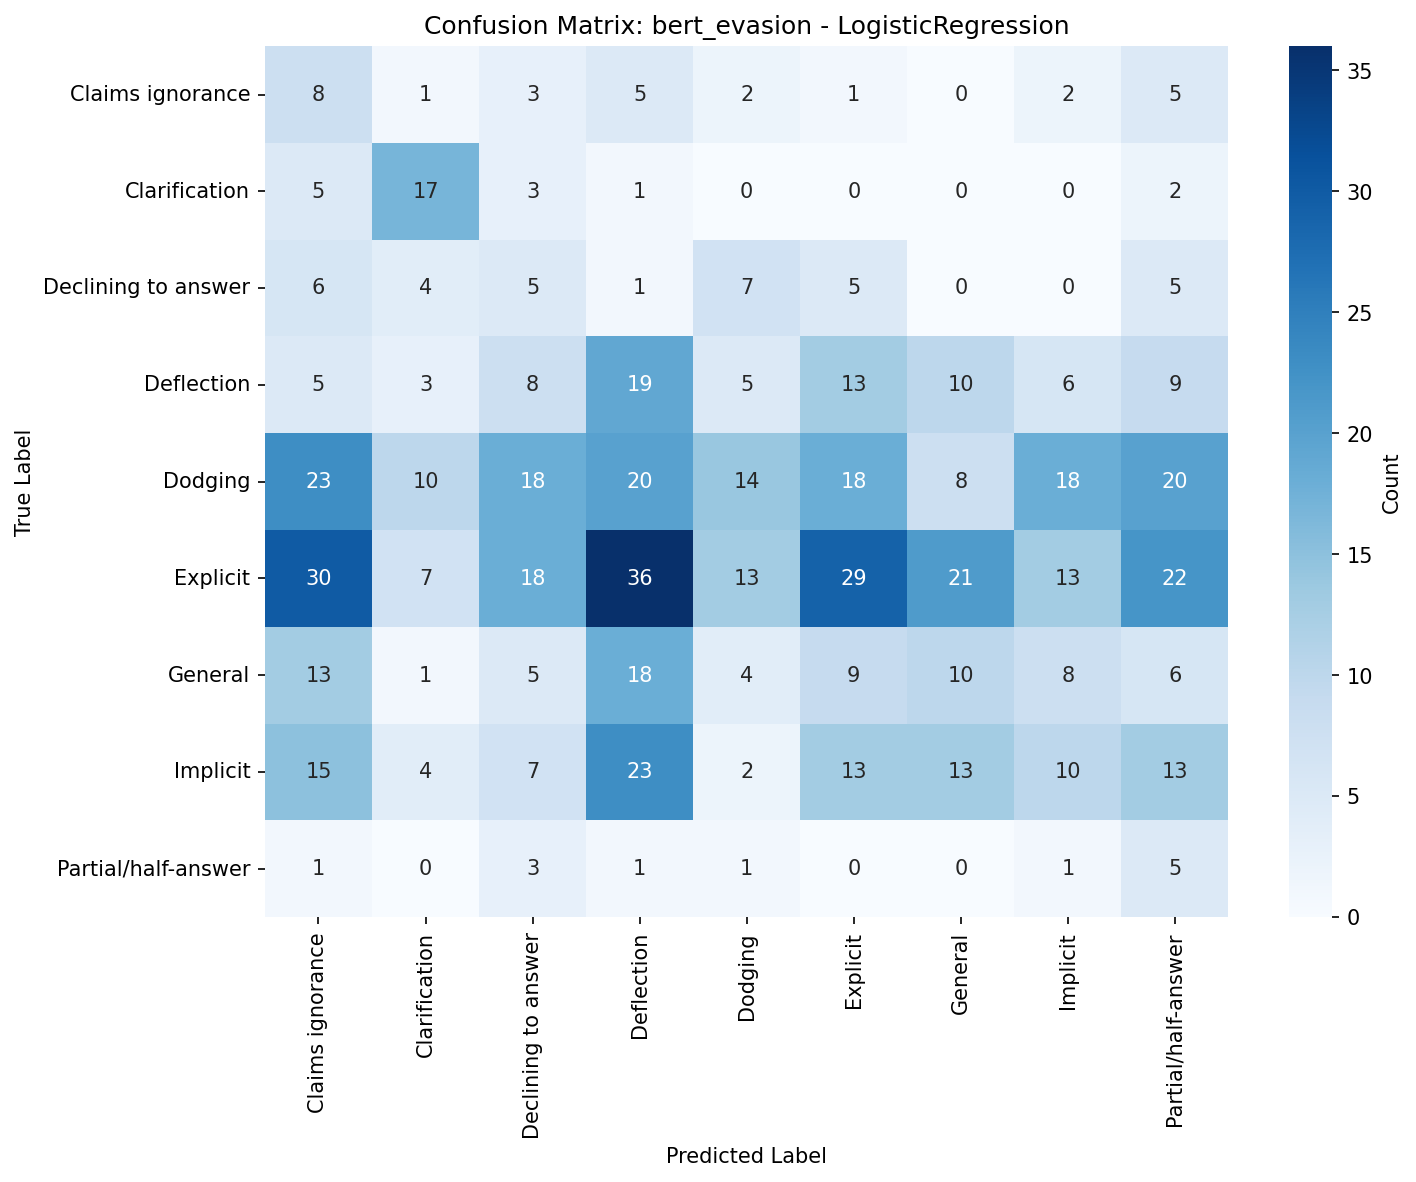

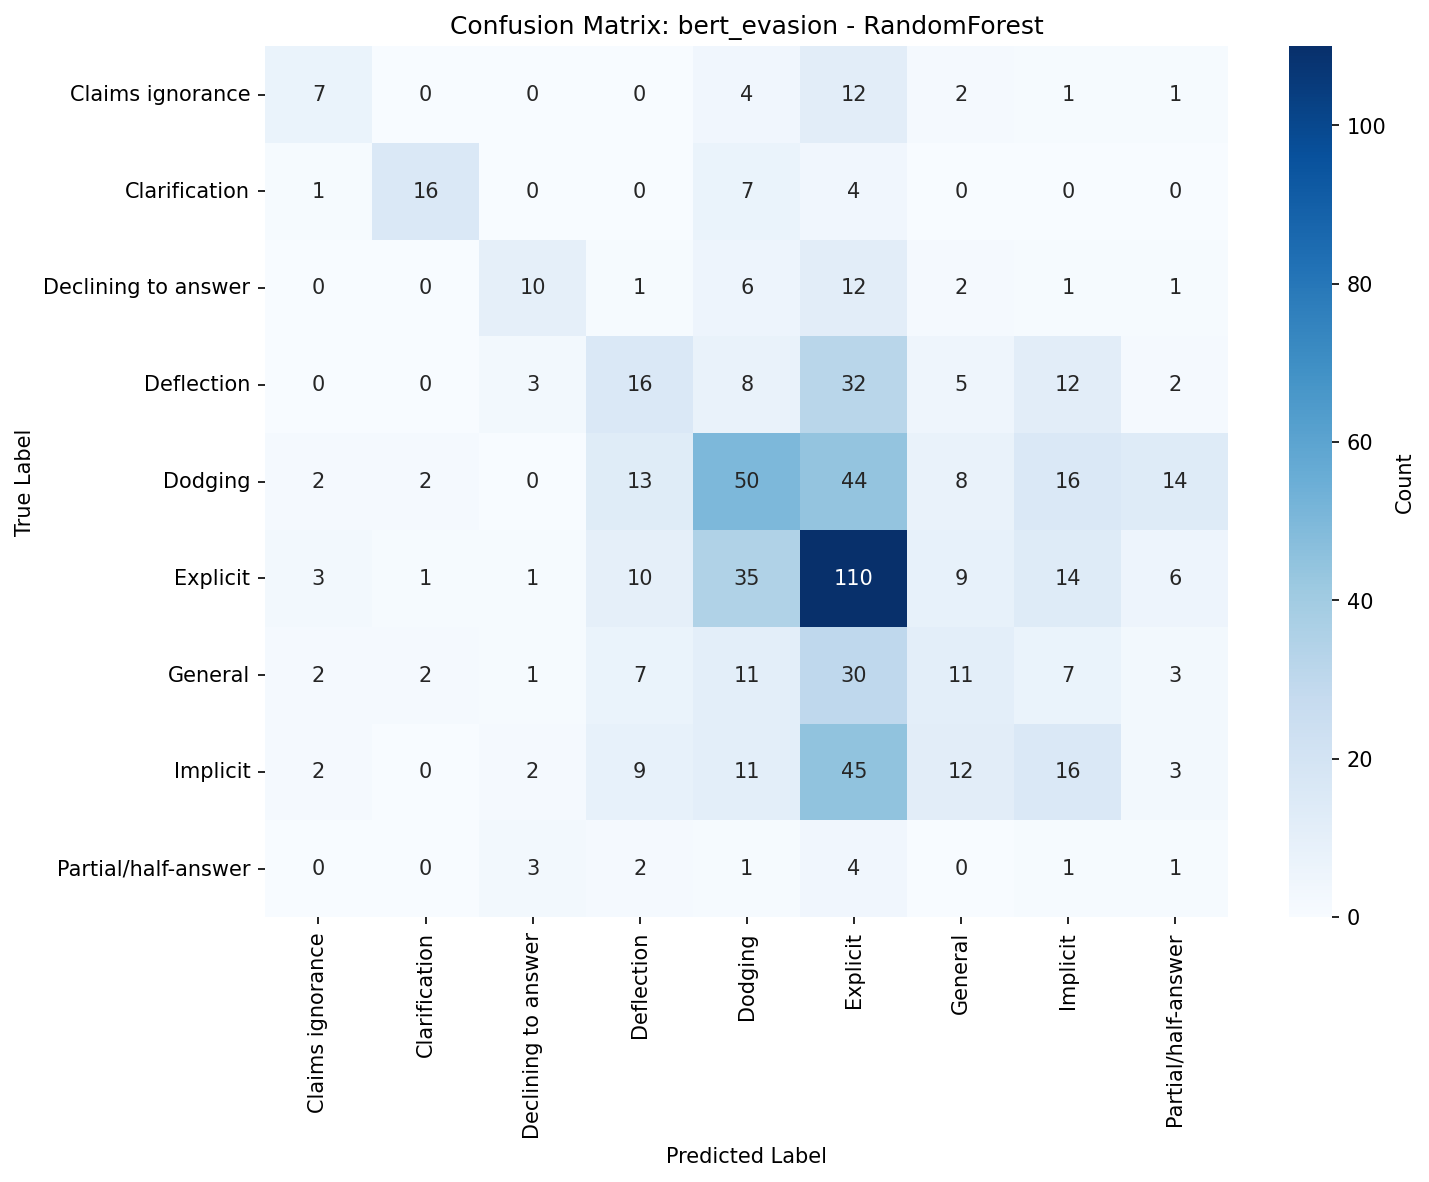

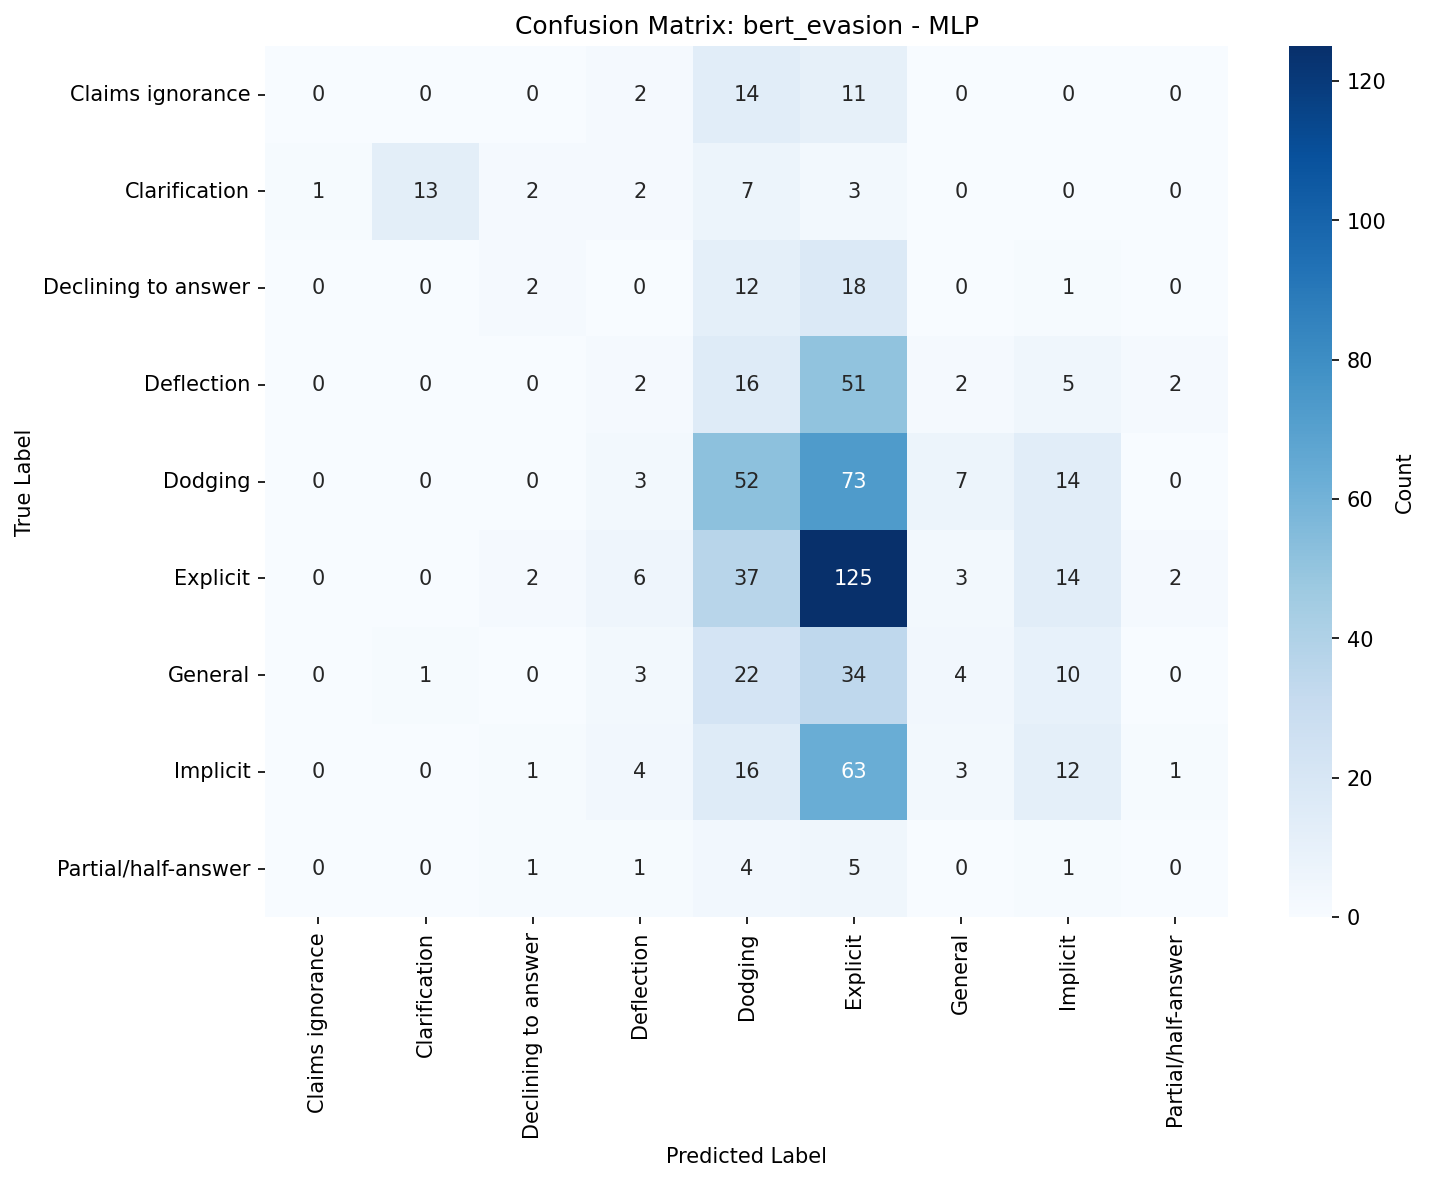

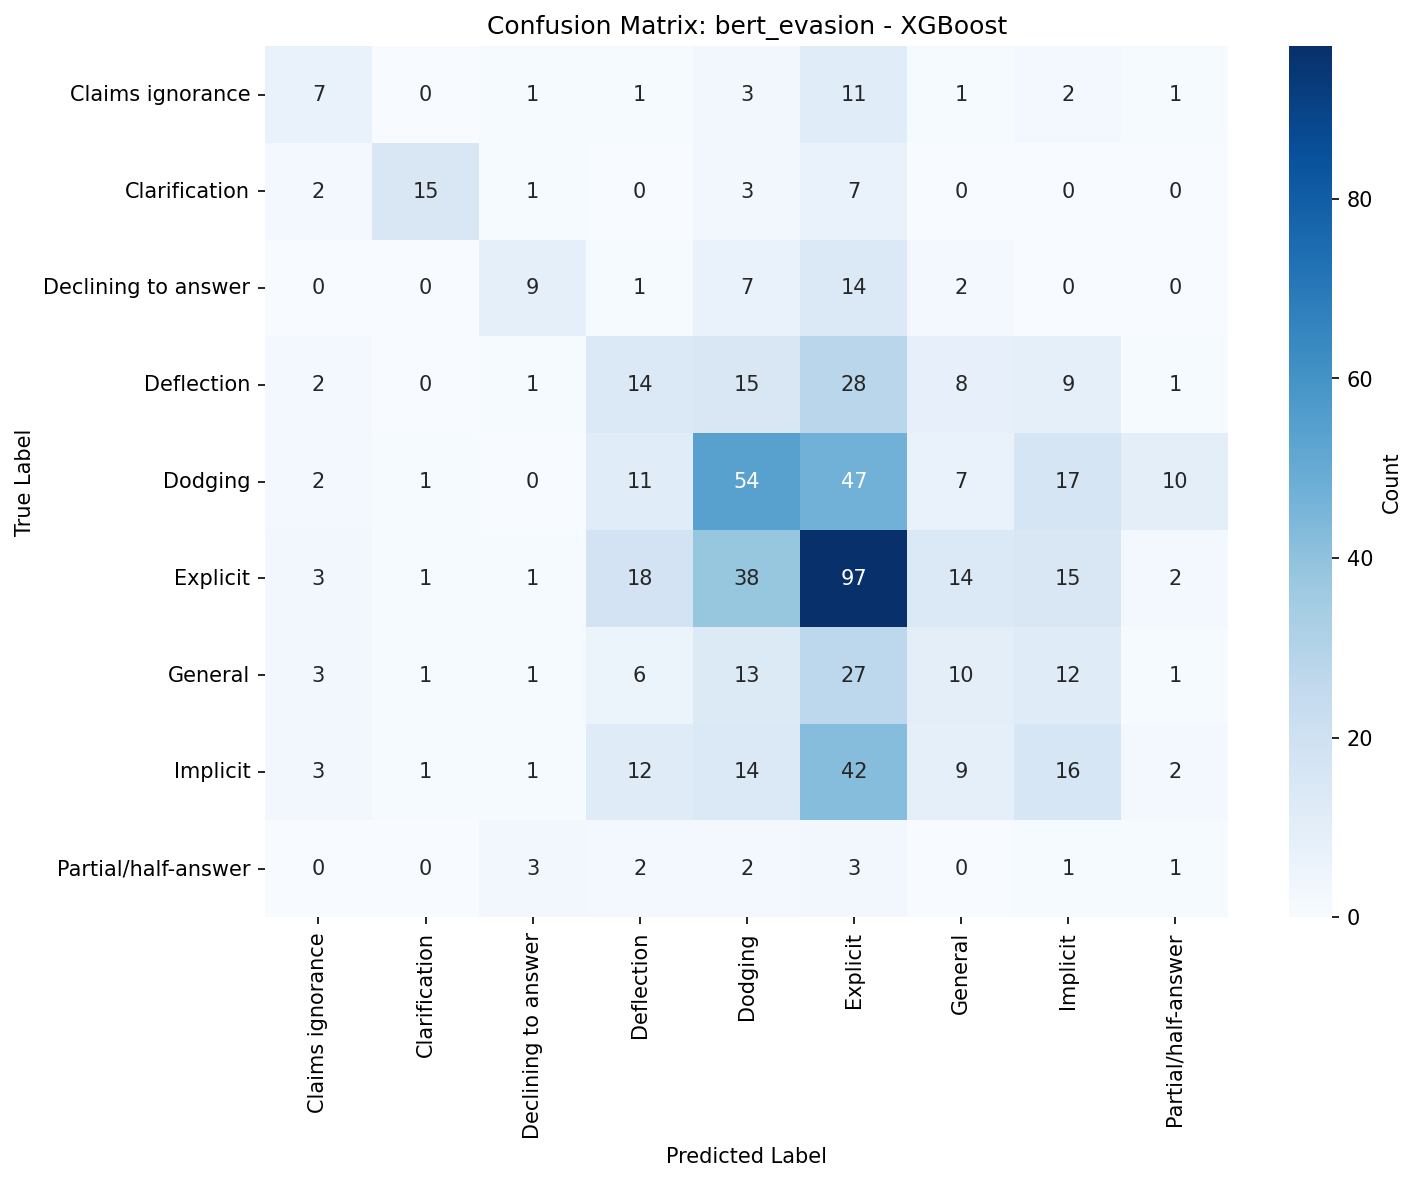

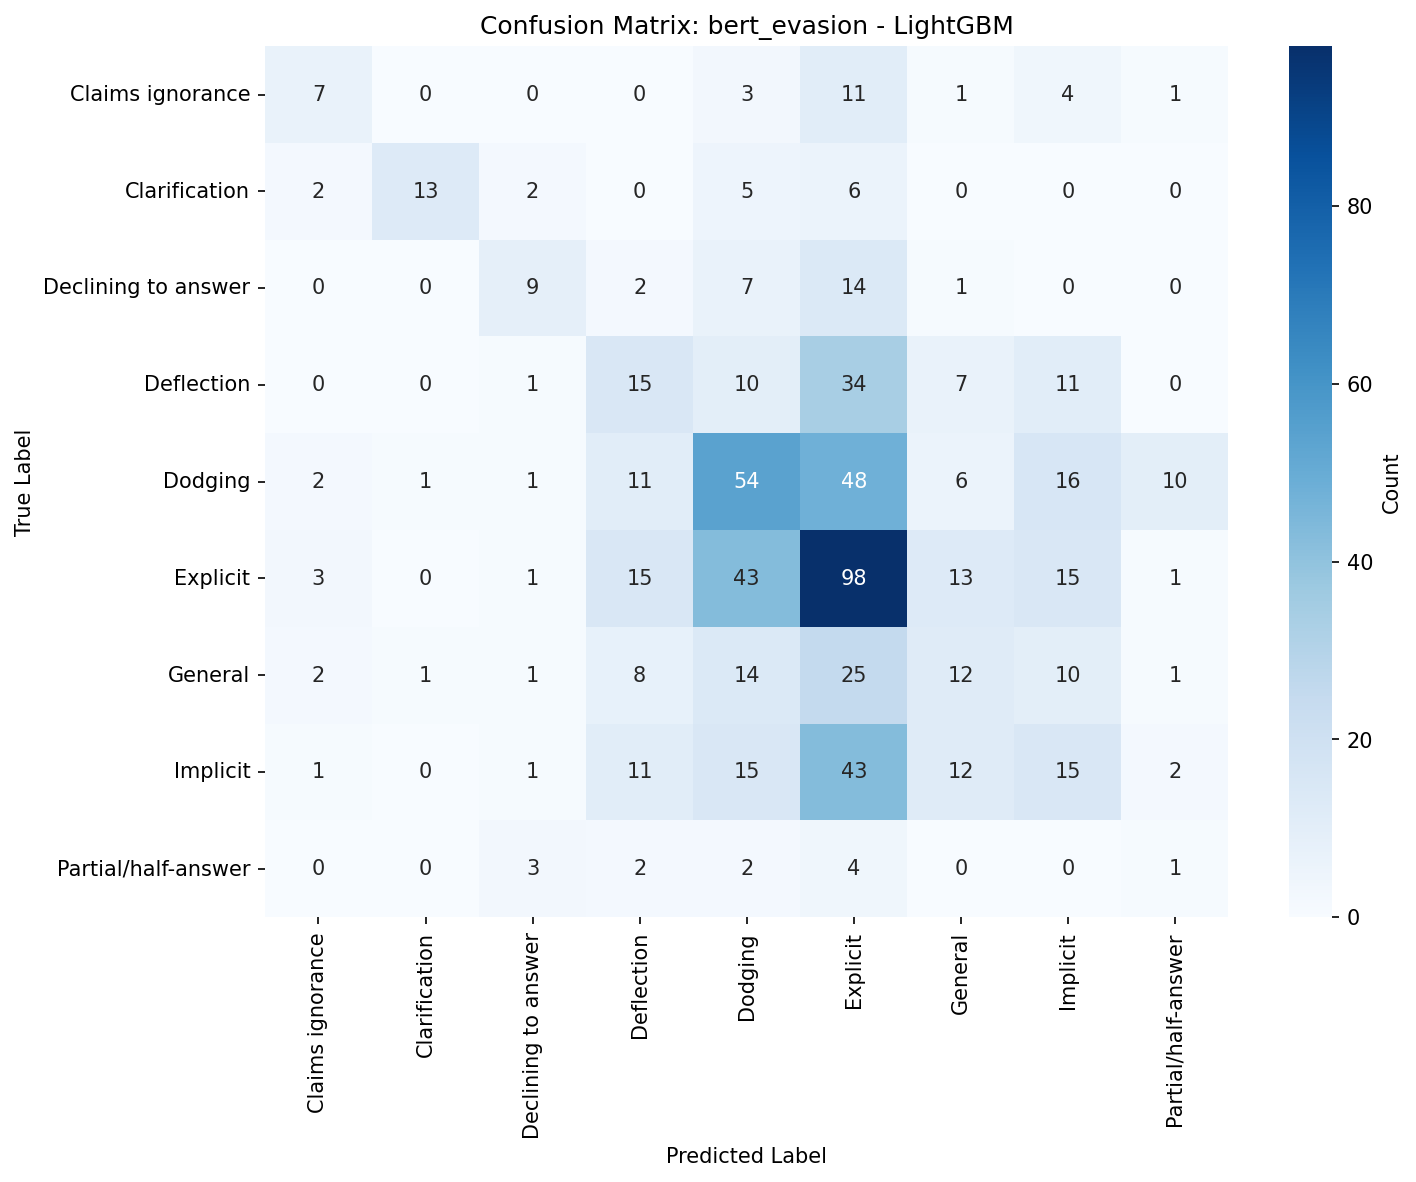


Results Table: bert_political_clarity
        Classifier                   Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
      RandomForest bert_political_clarity  0.582609  0.513378     0.572970         0.542882      0.495964
           XGBoost bert_political_clarity  0.579710  0.507448     0.572013         0.545275      0.487321
          LightGBM bert_political_clarity  0.585507  0.506654     0.572565         0.542787      0.487791
         LinearSVC bert_political_clarity  0.559420  0.444066     0.539029         0.452149      0.450083
LogisticRegression bert_political_clarity  0.447826  0.425782     0.463267         0.429716      0.480698
               MLP bert_political_clarity  0.605797  0.387793     0.522173         0.645576      0.395250

Per-Class Metrics: bert_political_clarity - RandomForest (Best by Macro F1)
          Class  Precision   Recall  F1-Score  Support
     Ambivalent   0.648707 0.728814  0.686431      413
Clear Non-Reply   0.587302 0.420

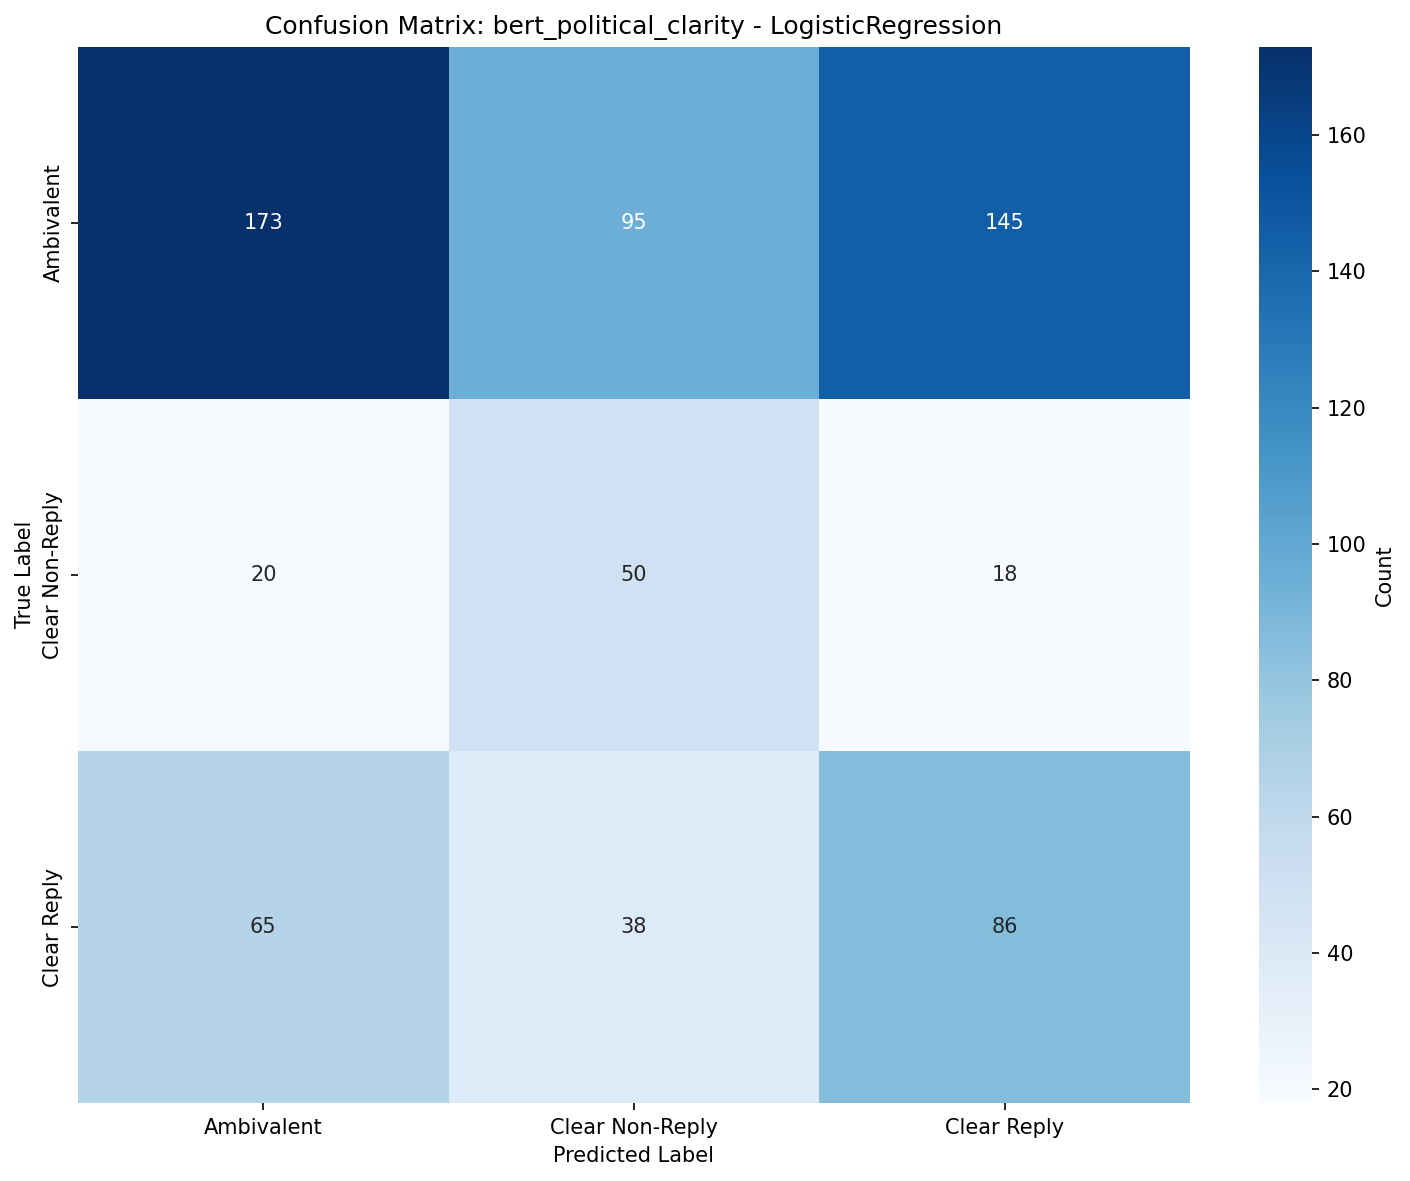

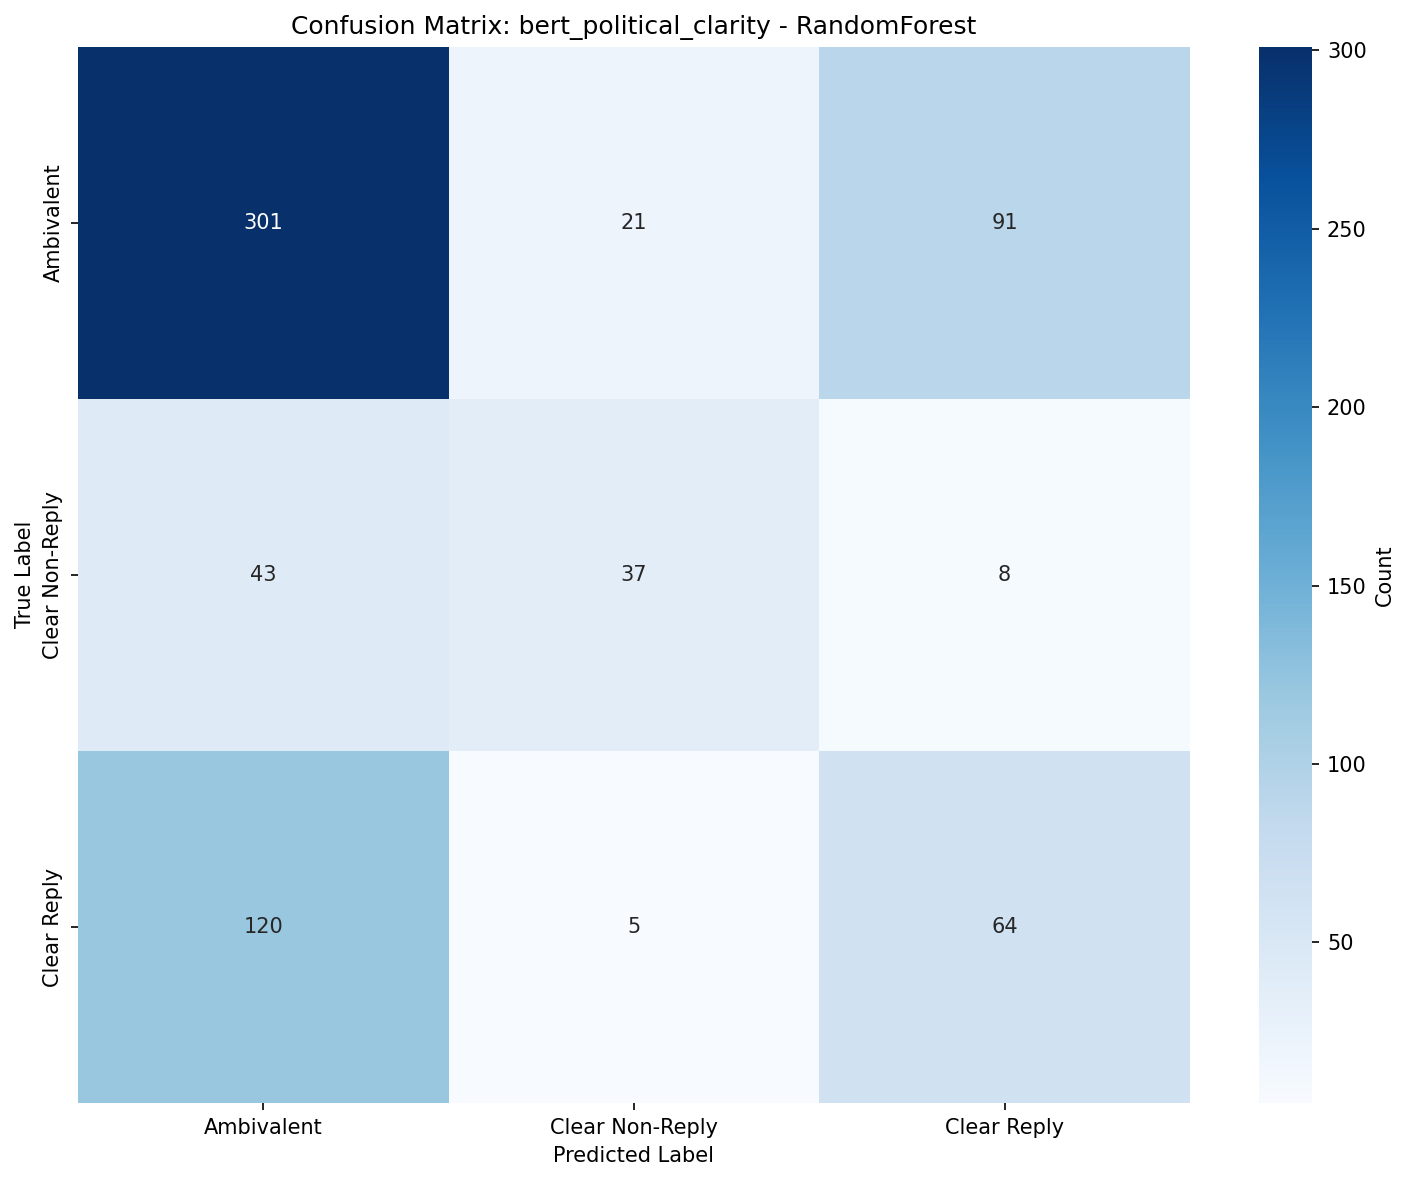

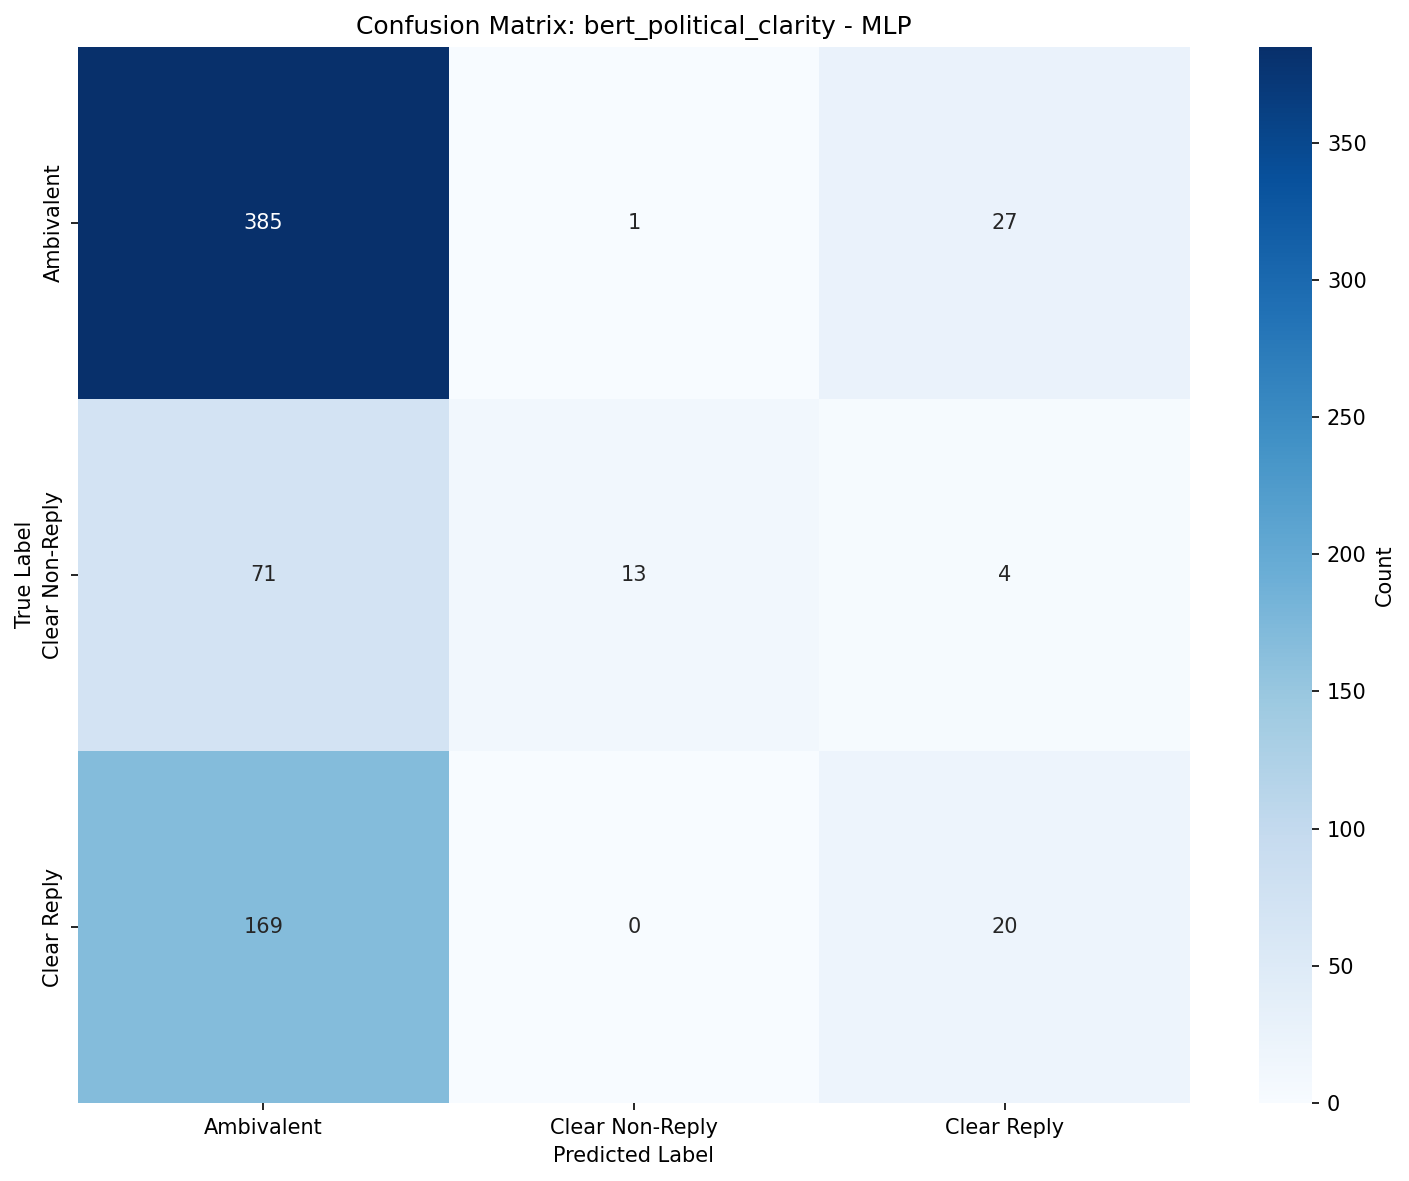

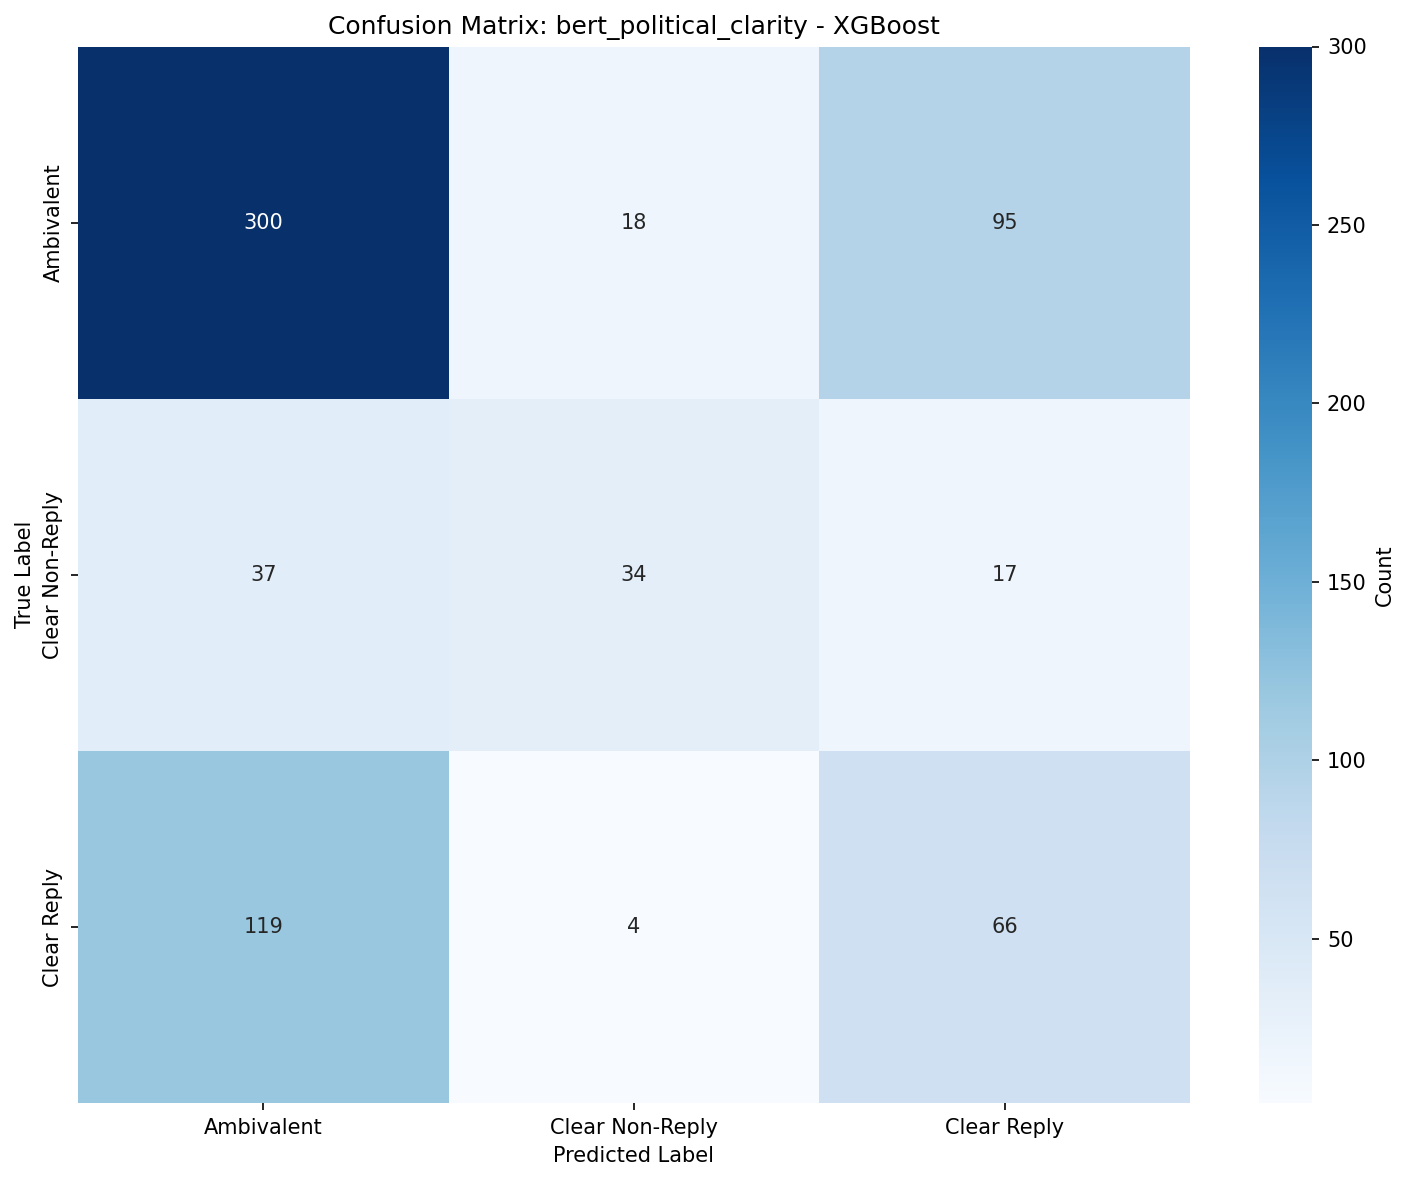

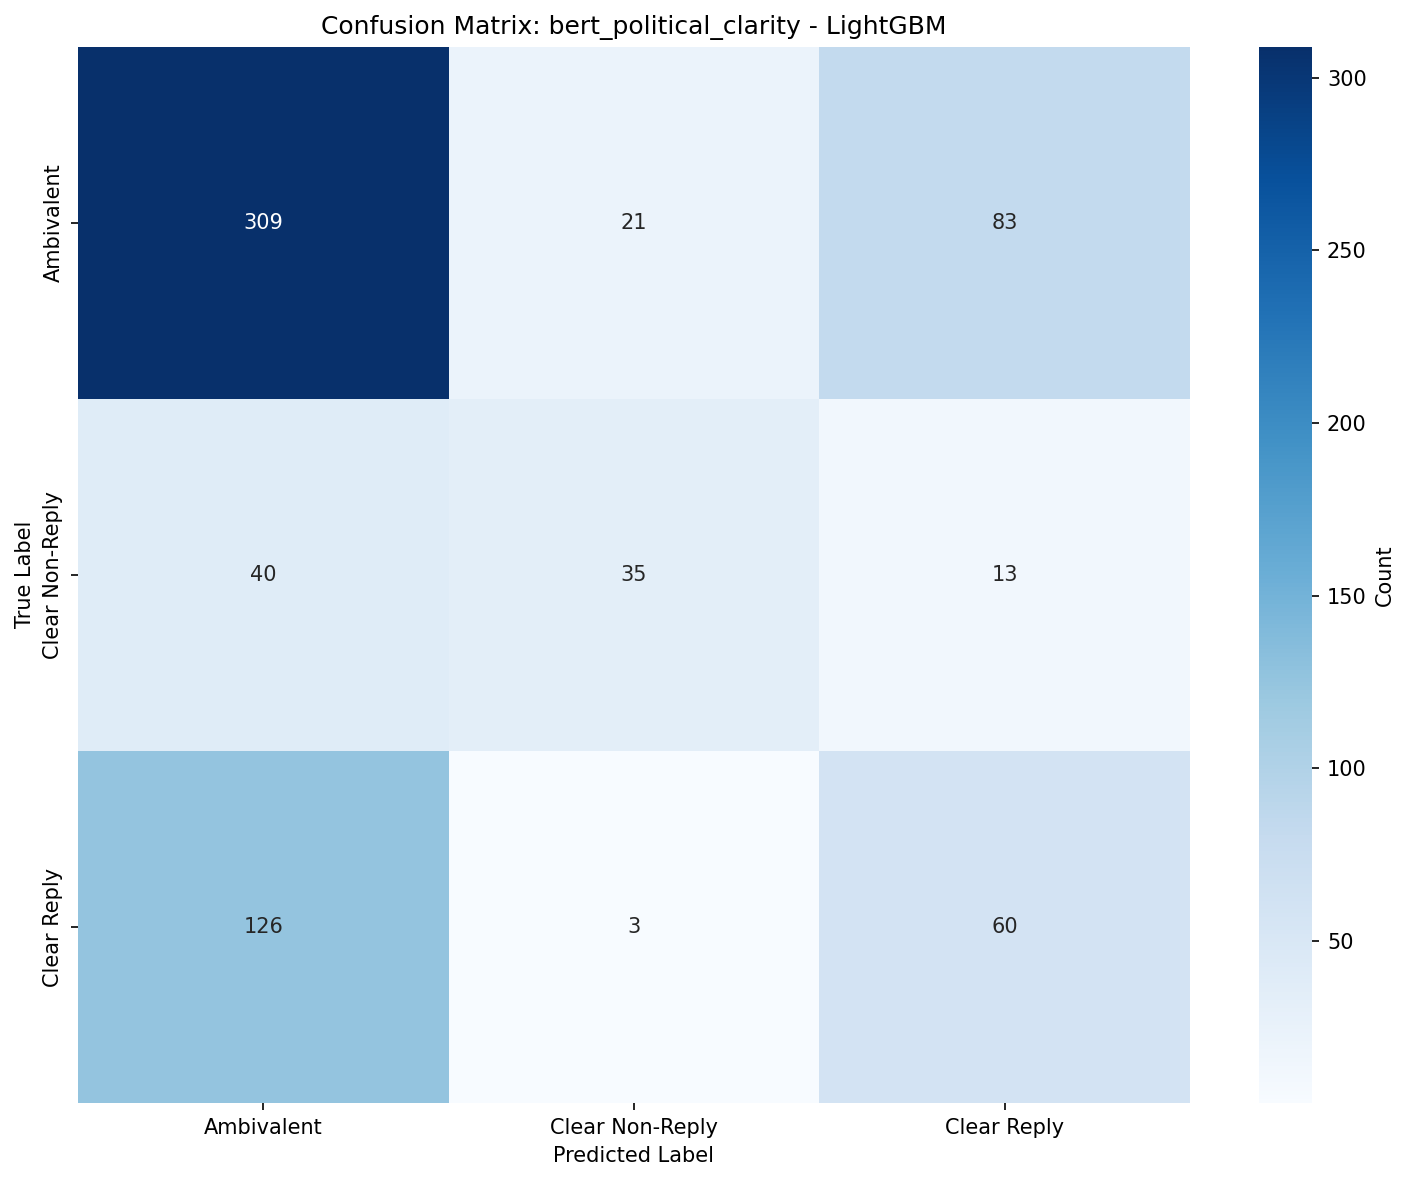


Results Table: bert_political_evasion
        Classifier                   Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
      RandomForest bert_political_evasion  0.343478  0.312310     0.332792         0.354771      0.294268
          LightGBM bert_political_evasion  0.324638  0.298941     0.315489         0.354473      0.273890
           XGBoost bert_political_evasion  0.323188  0.296121     0.313917         0.334529      0.277922
         LinearSVC bert_political_evasion  0.240580  0.210076     0.237270         0.227239      0.272030
               MLP bert_political_evasion  0.304348  0.194253     0.253622         0.255760      0.192773
LogisticRegression bert_political_evasion  0.169565  0.176112     0.172932         0.186024      0.244194

Per-Class Metrics: bert_political_evasion - RandomForest (Best by Macro F1)
              Class  Precision   Recall  F1-Score  Support
   Claims ignorance   0.411765 0.259259  0.318182       27
      Clarification   0.

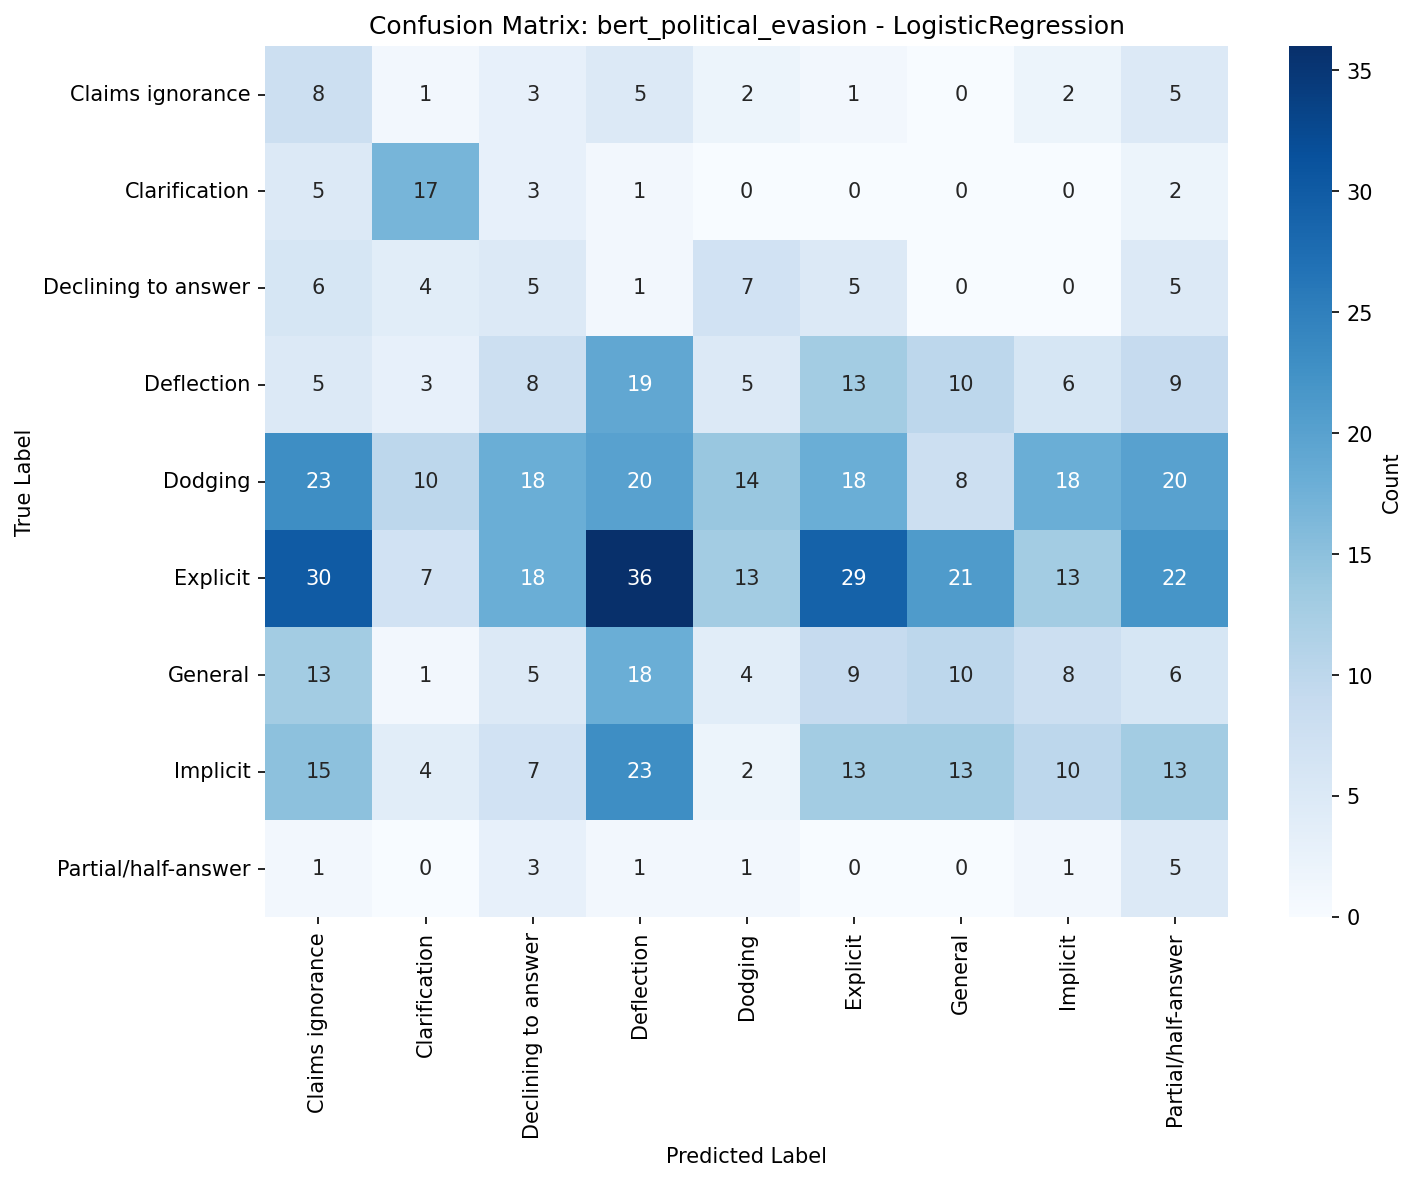

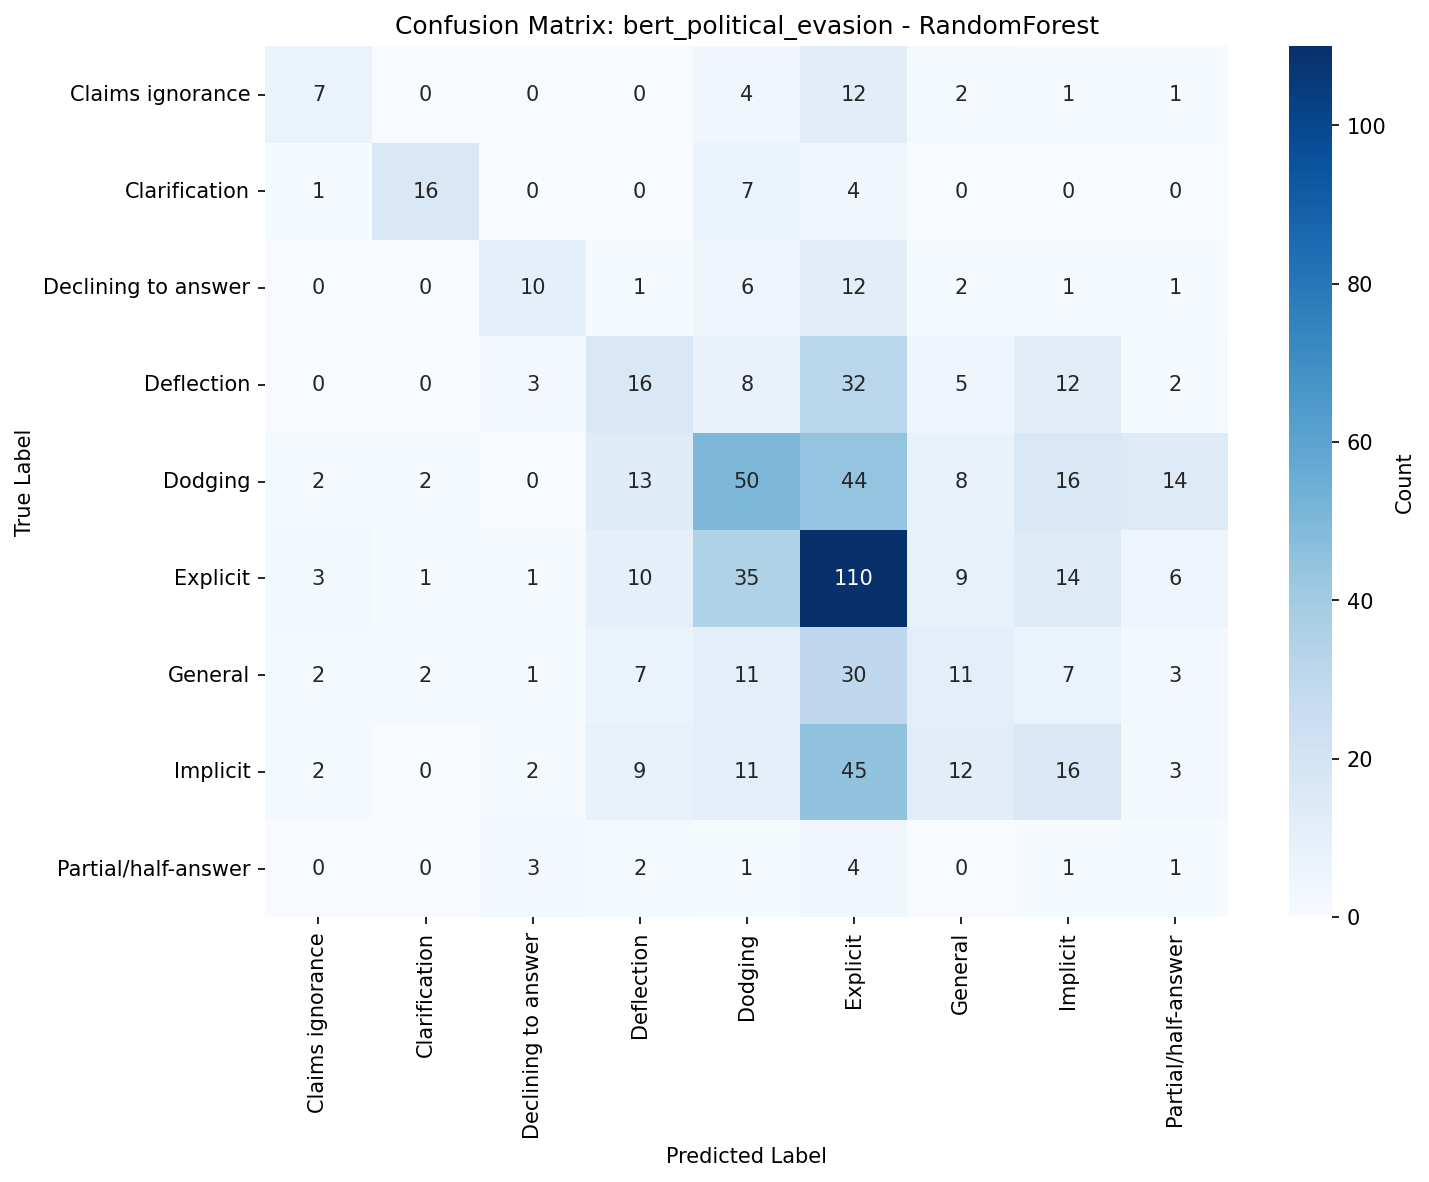

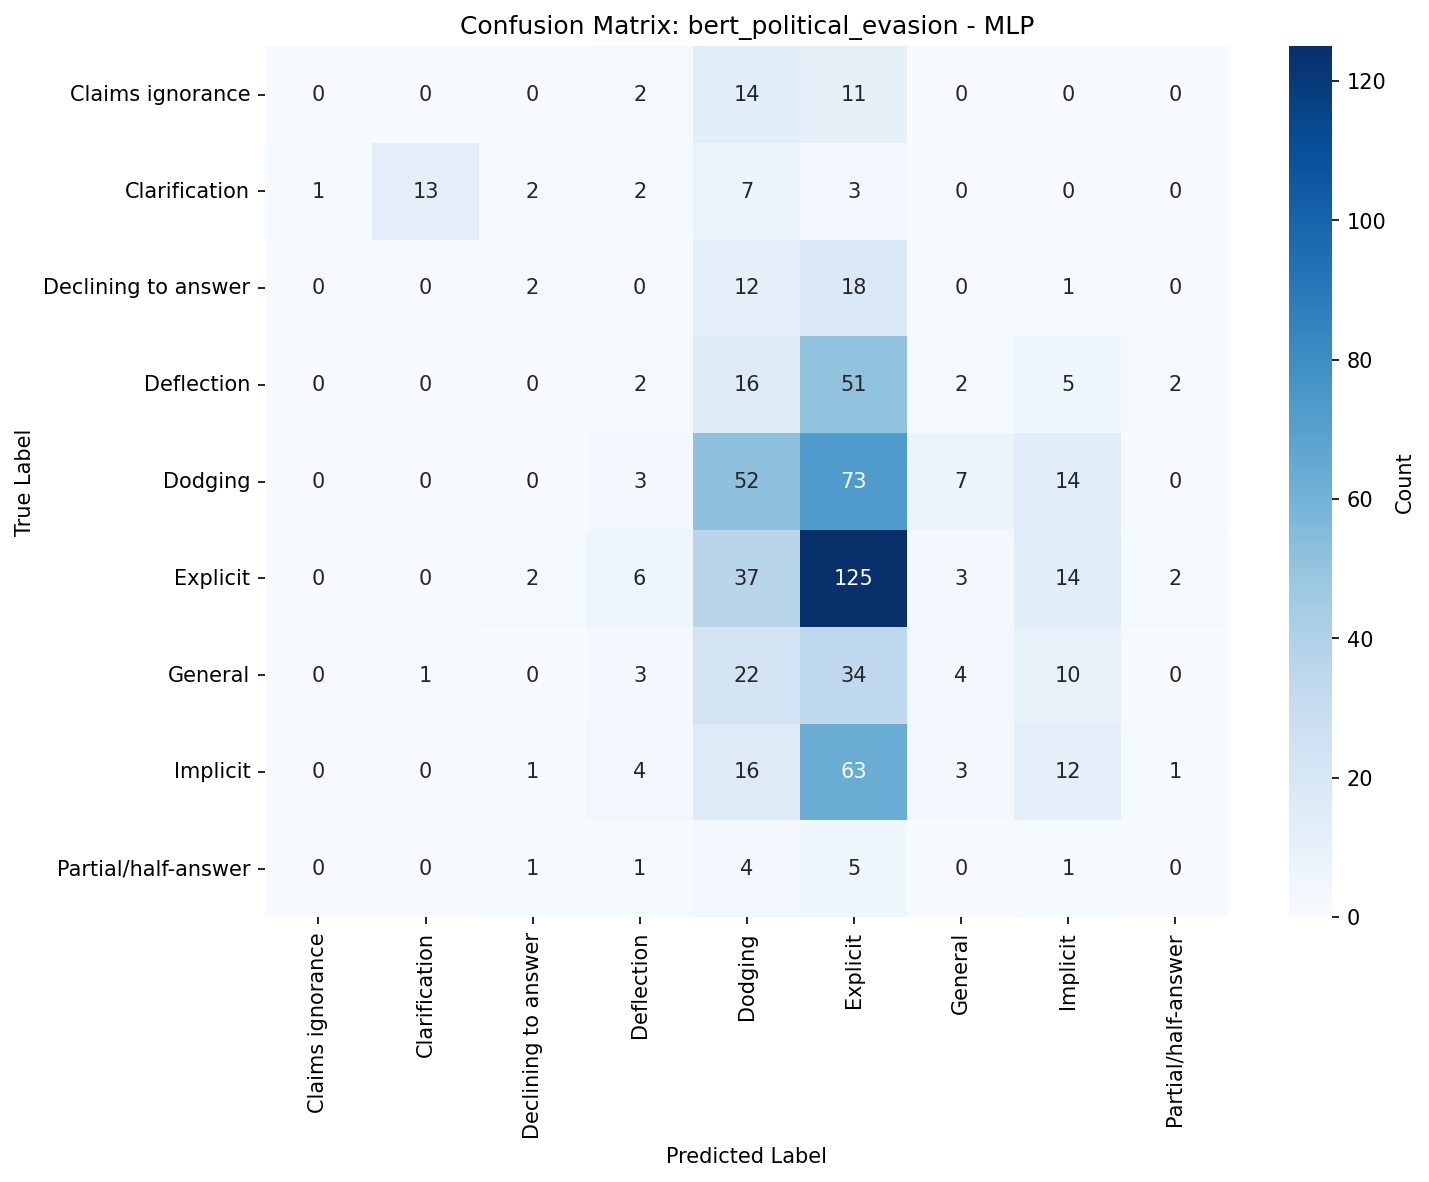

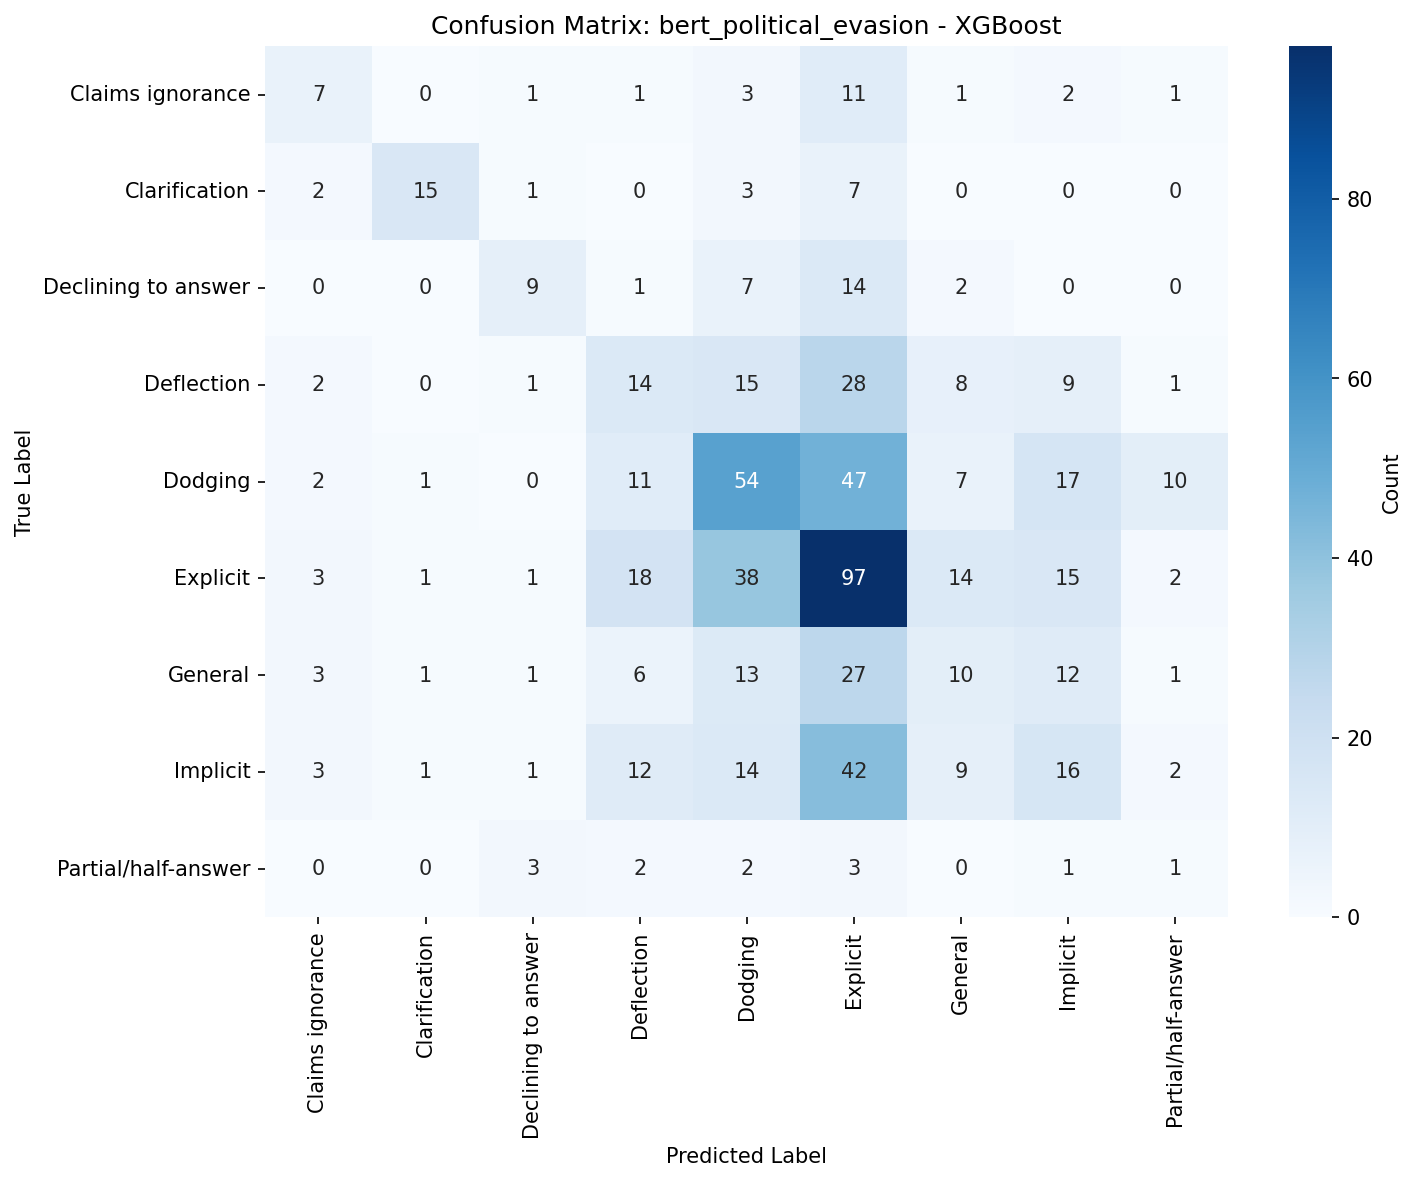

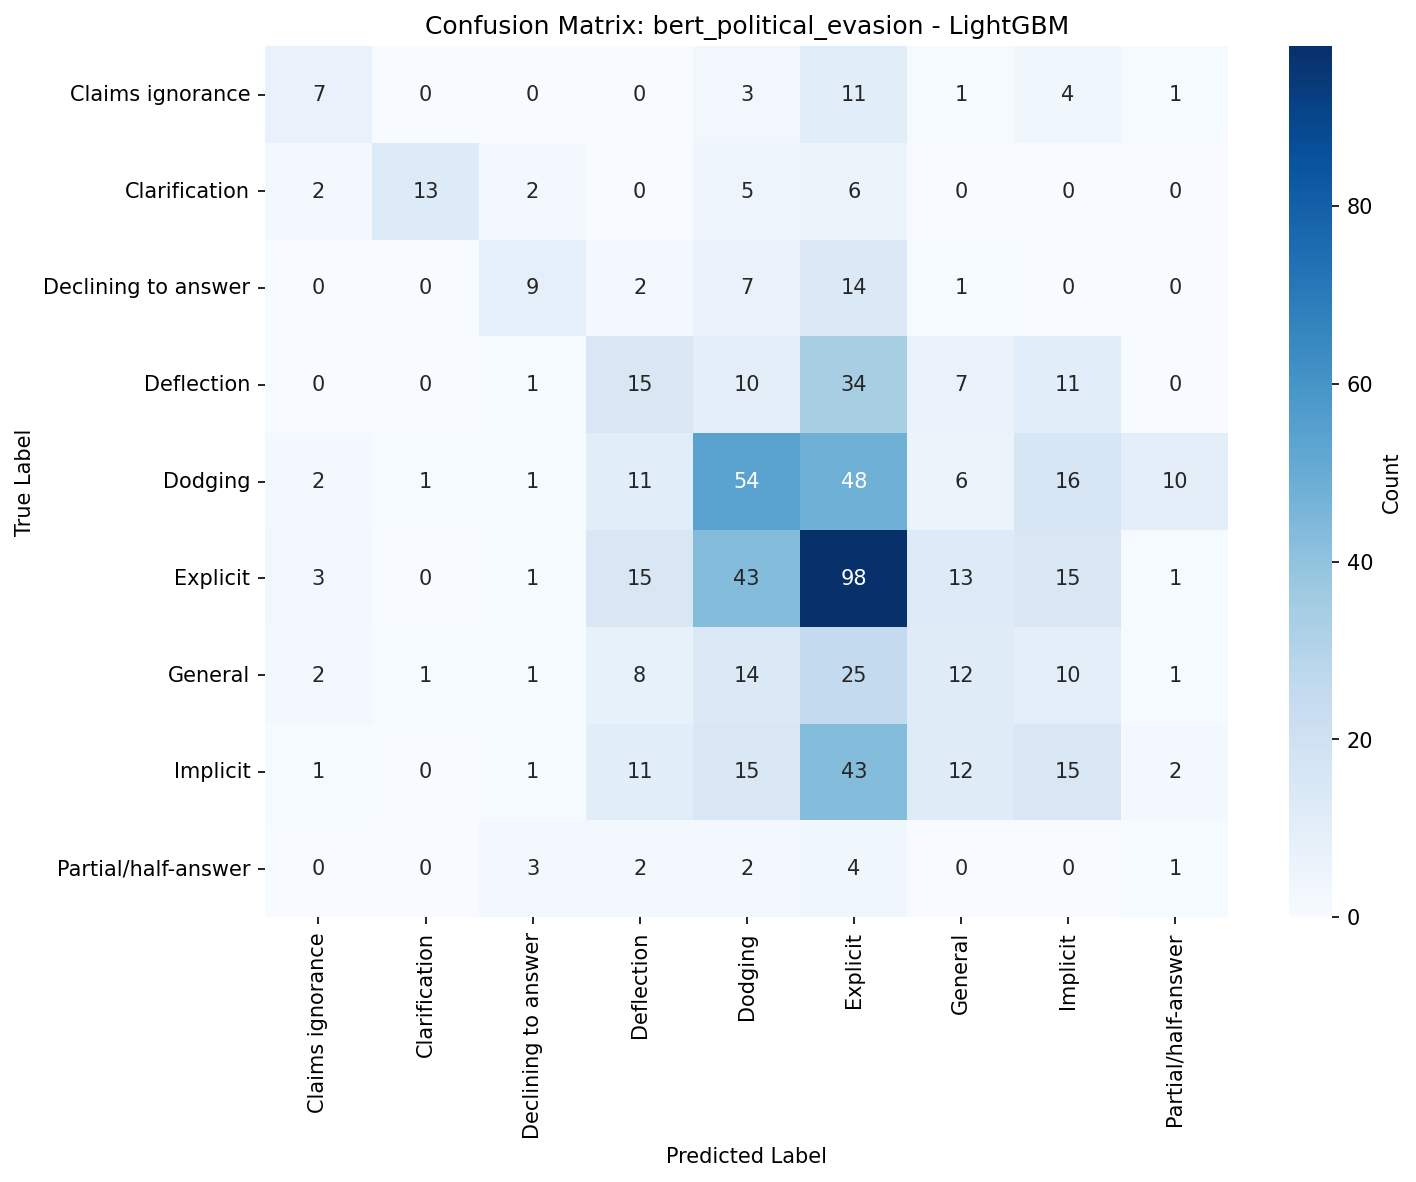


Results Table: bert_ambiguity_clarity
        Classifier                   Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
      RandomForest bert_ambiguity_clarity  0.582609  0.513378     0.572970         0.542882      0.495964
           XGBoost bert_ambiguity_clarity  0.579710  0.507448     0.572013         0.545275      0.487321
          LightGBM bert_ambiguity_clarity  0.585507  0.506654     0.572565         0.542787      0.487791
         LinearSVC bert_ambiguity_clarity  0.559420  0.444066     0.539029         0.452149      0.450083
LogisticRegression bert_ambiguity_clarity  0.447826  0.425782     0.463267         0.429716      0.480698
               MLP bert_ambiguity_clarity  0.605797  0.387793     0.522173         0.645576      0.395250

Per-Class Metrics: bert_ambiguity_clarity - RandomForest (Best by Macro F1)
          Class  Precision   Recall  F1-Score  Support
     Ambivalent   0.648707 0.728814  0.686431      413
Clear Non-Reply   0.587302 0.420

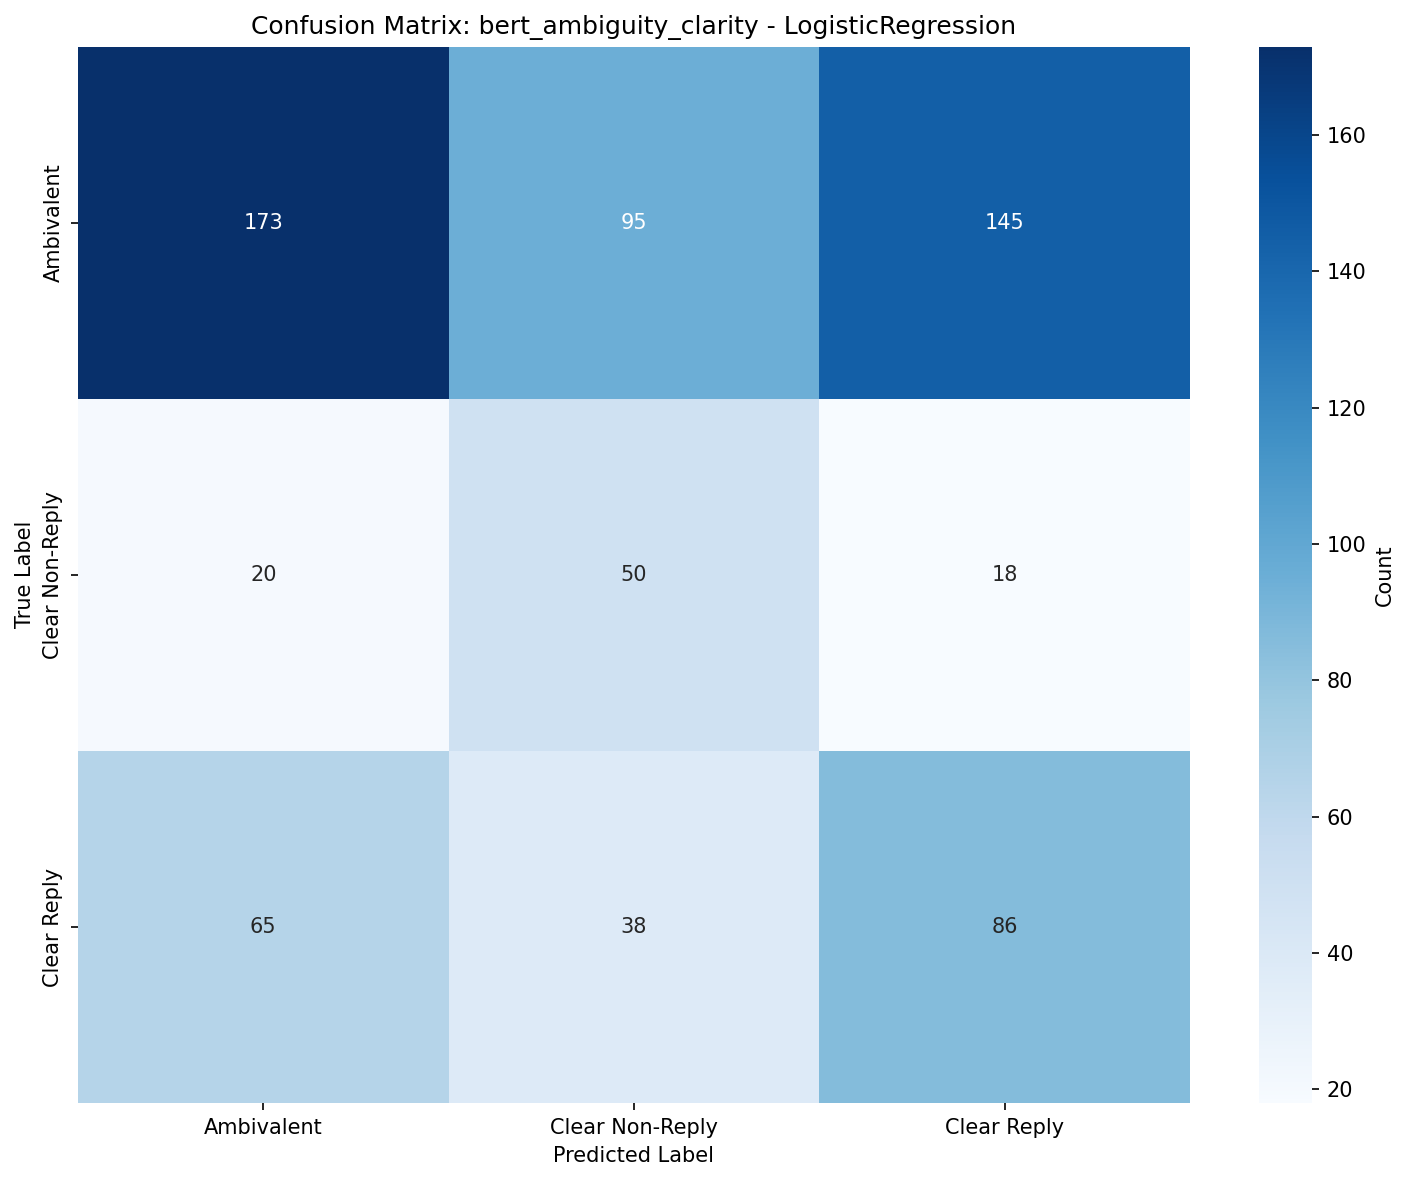

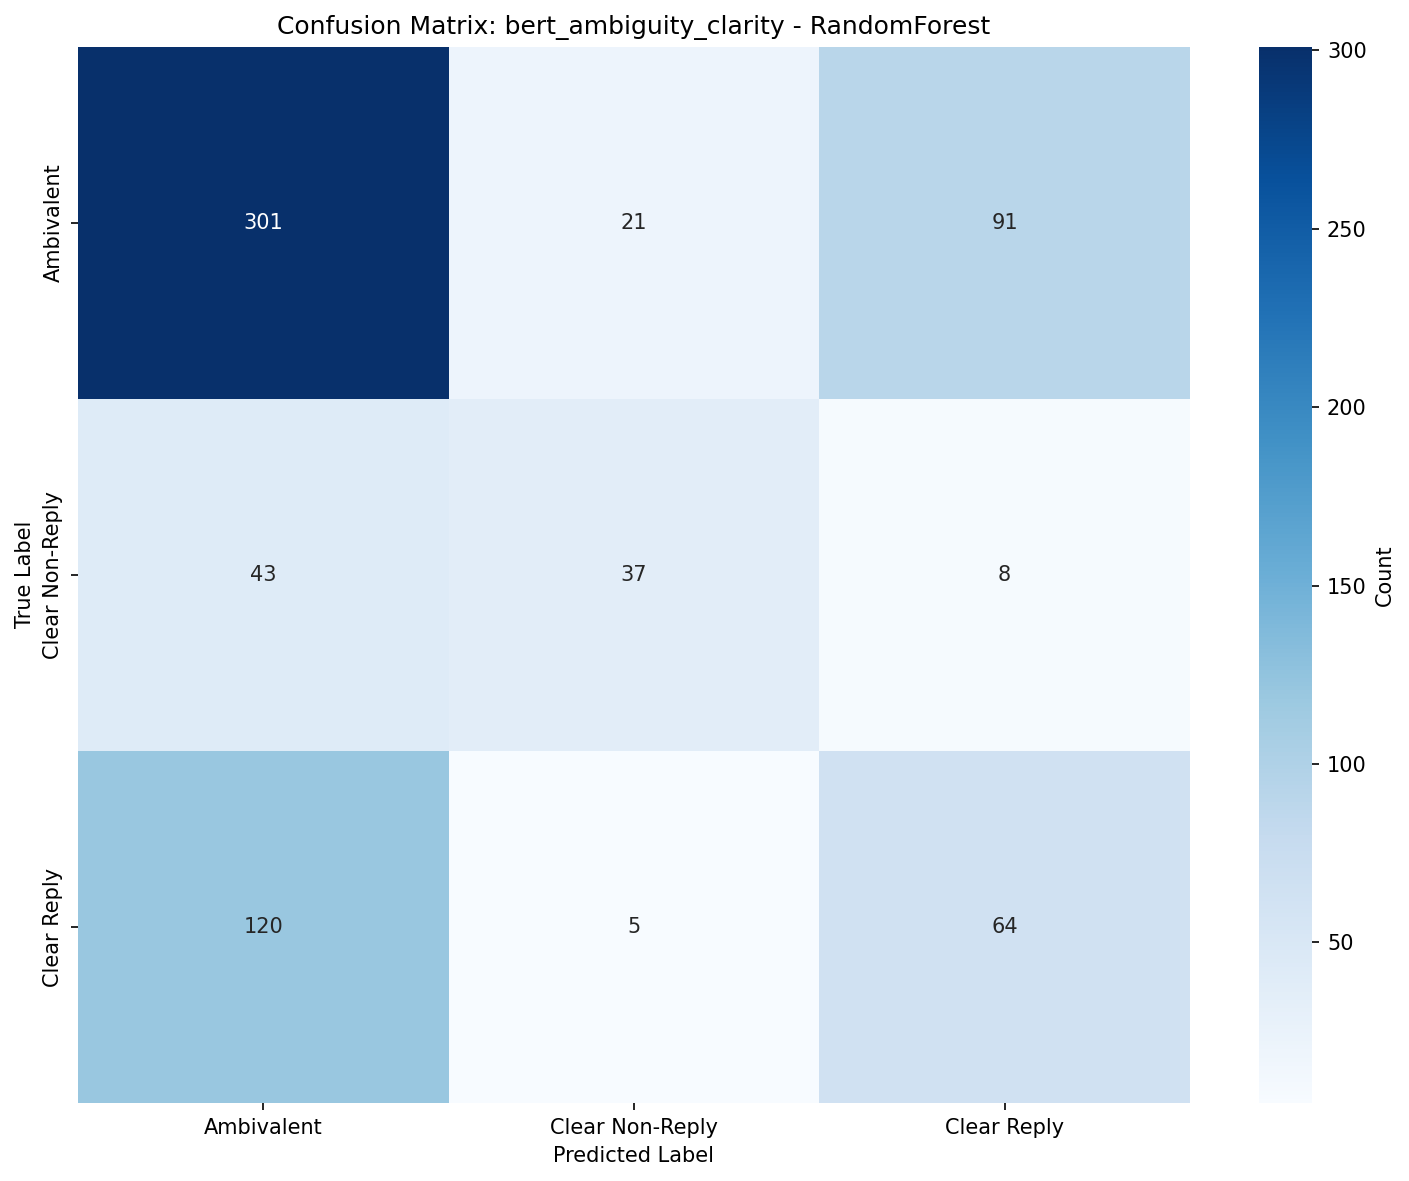

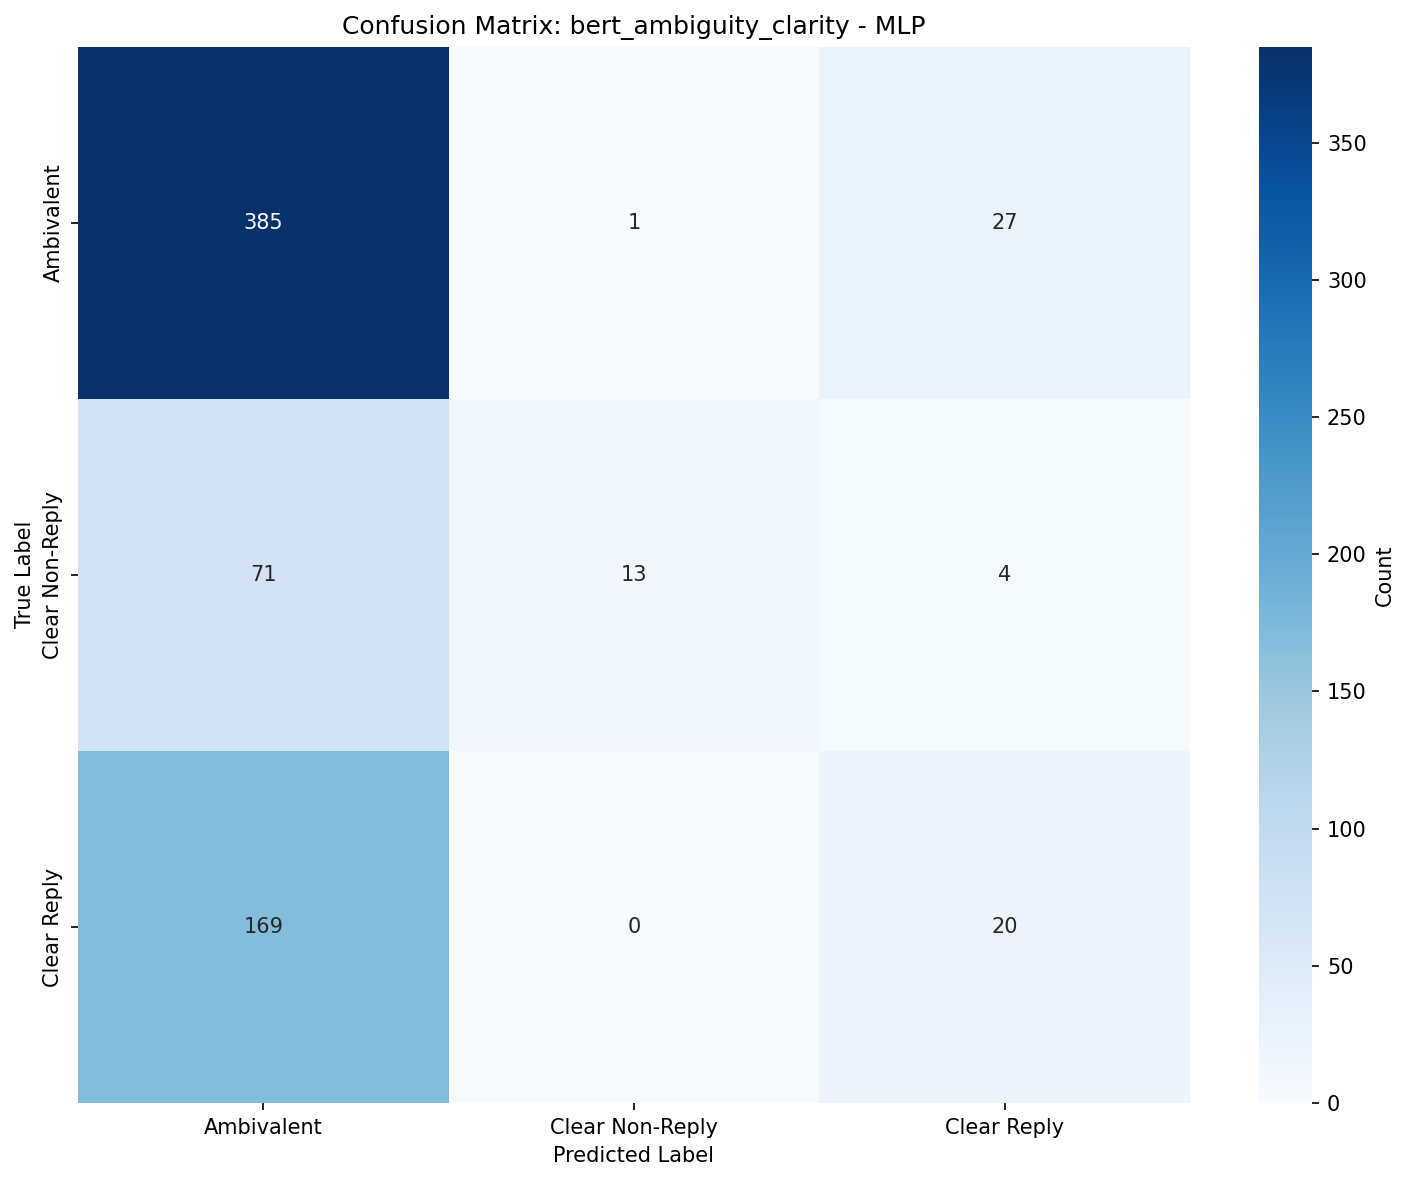

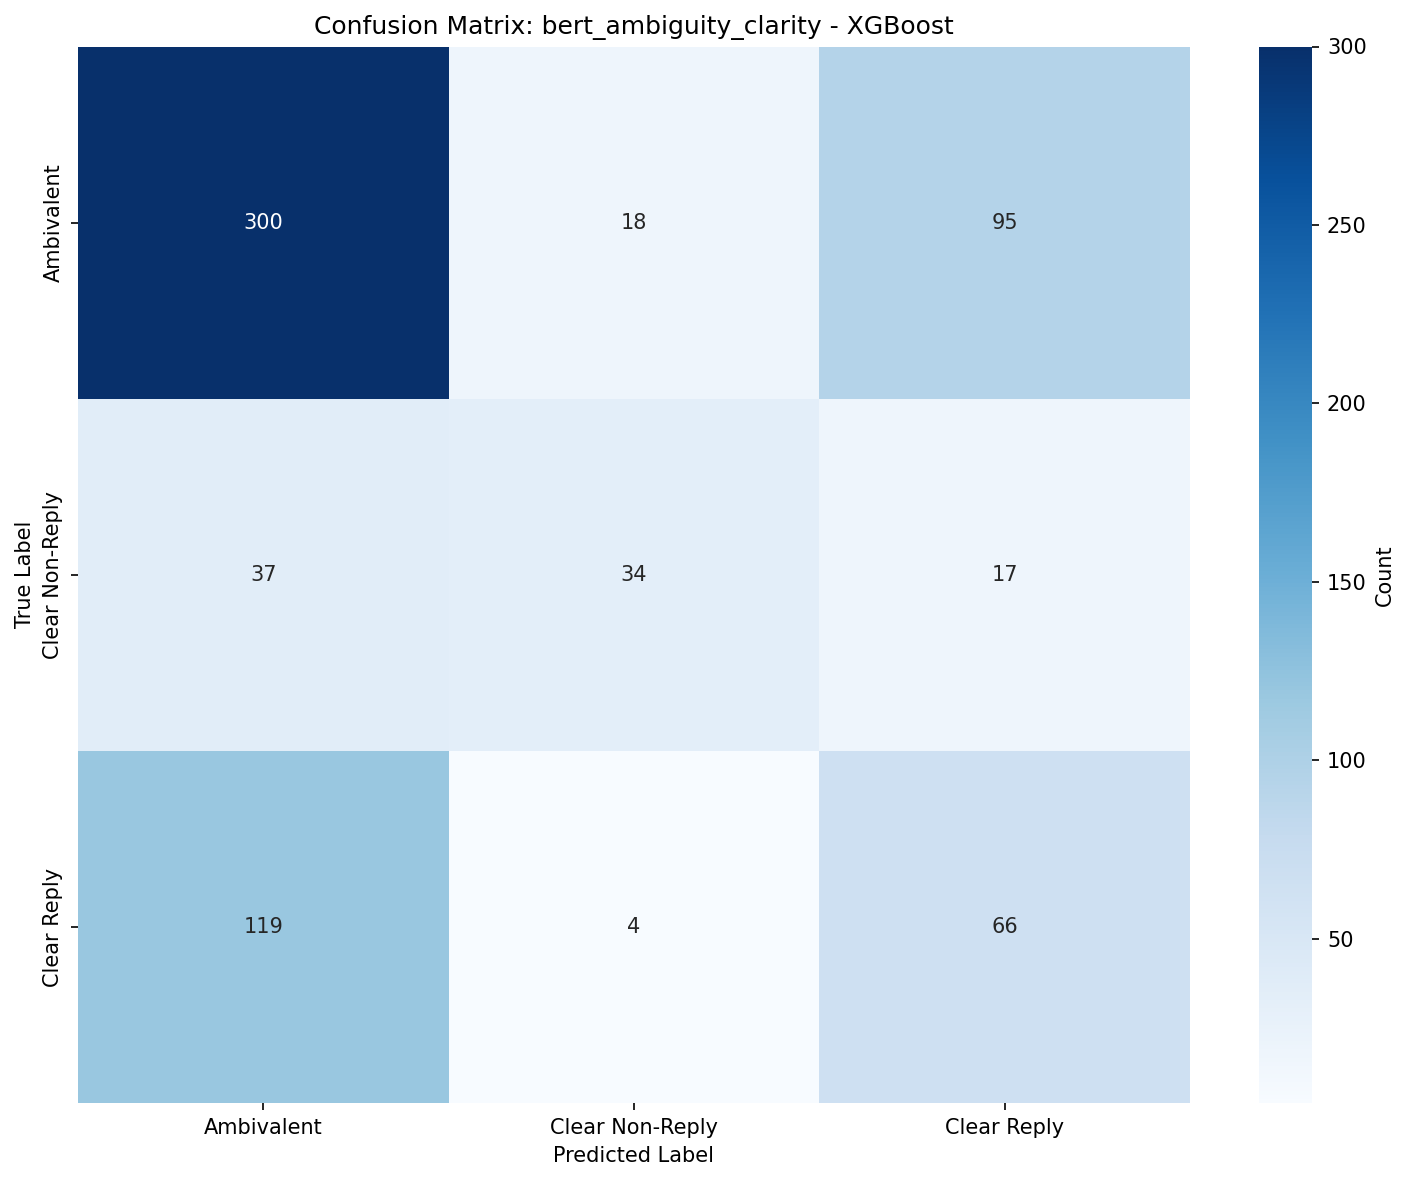

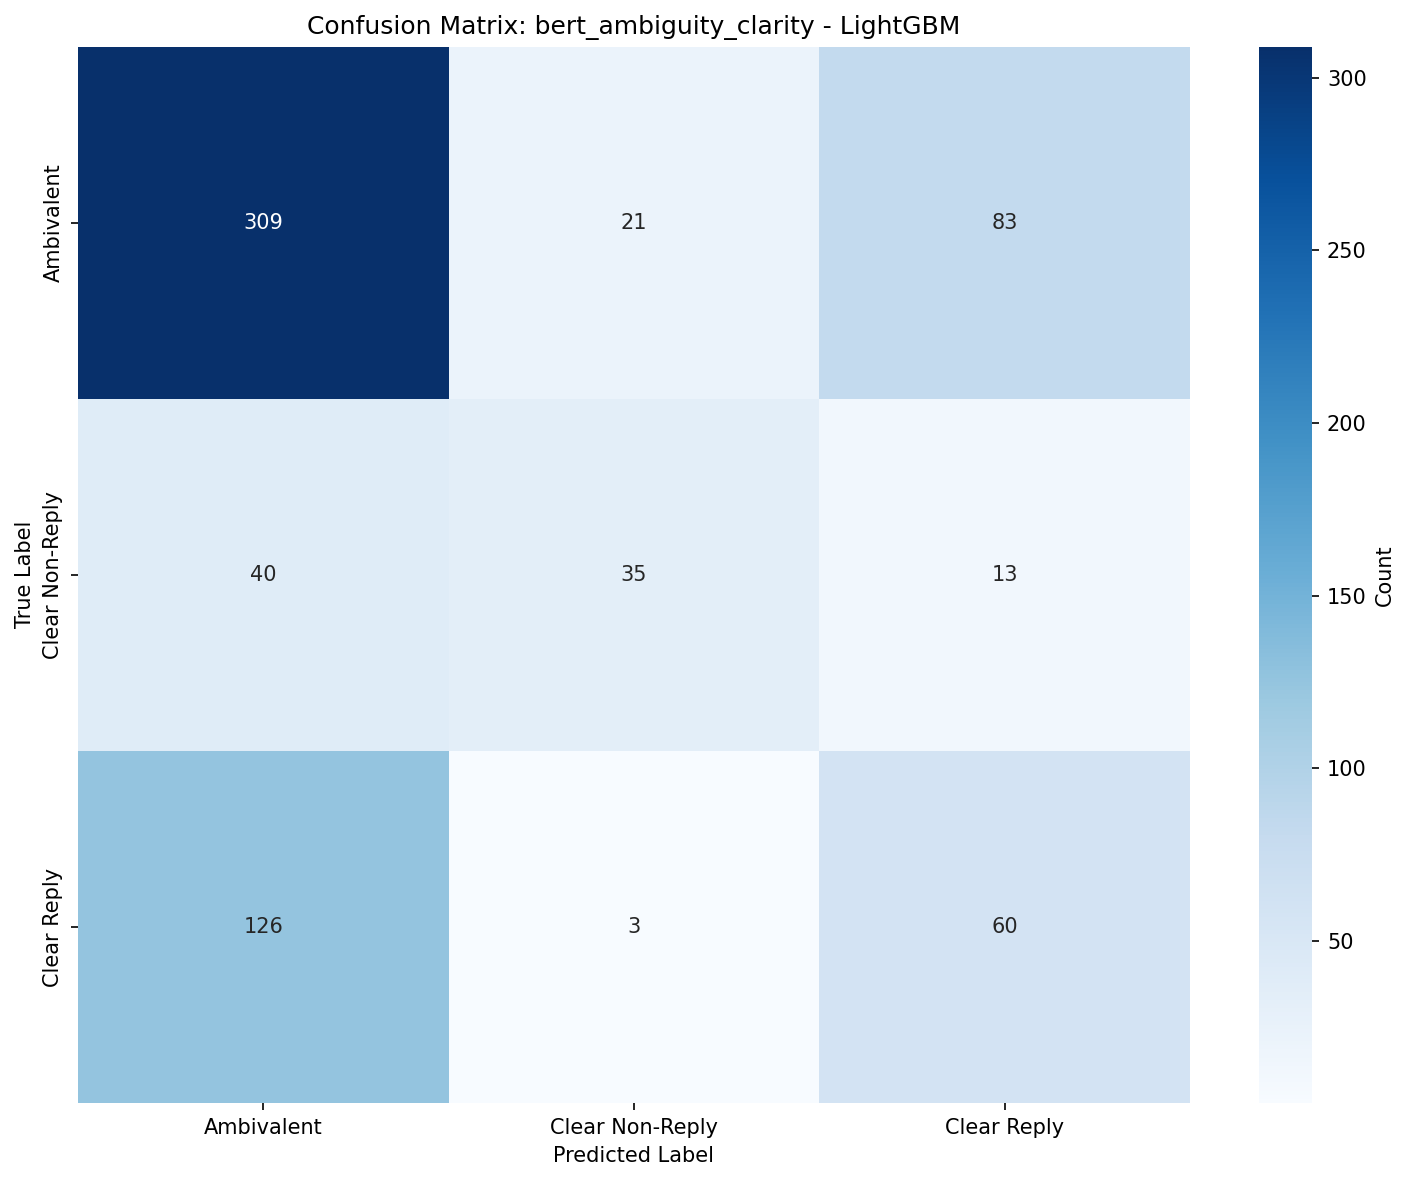


Results Table: bert_ambiguity_evasion
        Classifier                   Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
      RandomForest bert_ambiguity_evasion  0.343478  0.312310     0.332792         0.354771      0.294268
          LightGBM bert_ambiguity_evasion  0.324638  0.298941     0.315489         0.354473      0.273890
           XGBoost bert_ambiguity_evasion  0.323188  0.296121     0.313917         0.334529      0.277922
         LinearSVC bert_ambiguity_evasion  0.240580  0.210076     0.237270         0.227239      0.272030
               MLP bert_ambiguity_evasion  0.304348  0.194253     0.253622         0.255760      0.192773
LogisticRegression bert_ambiguity_evasion  0.169565  0.176112     0.172932         0.186024      0.244194

Per-Class Metrics: bert_ambiguity_evasion - RandomForest (Best by Macro F1)
              Class  Precision   Recall  F1-Score  Support
   Claims ignorance   0.411765 0.259259  0.318182       27
      Clarification   0.

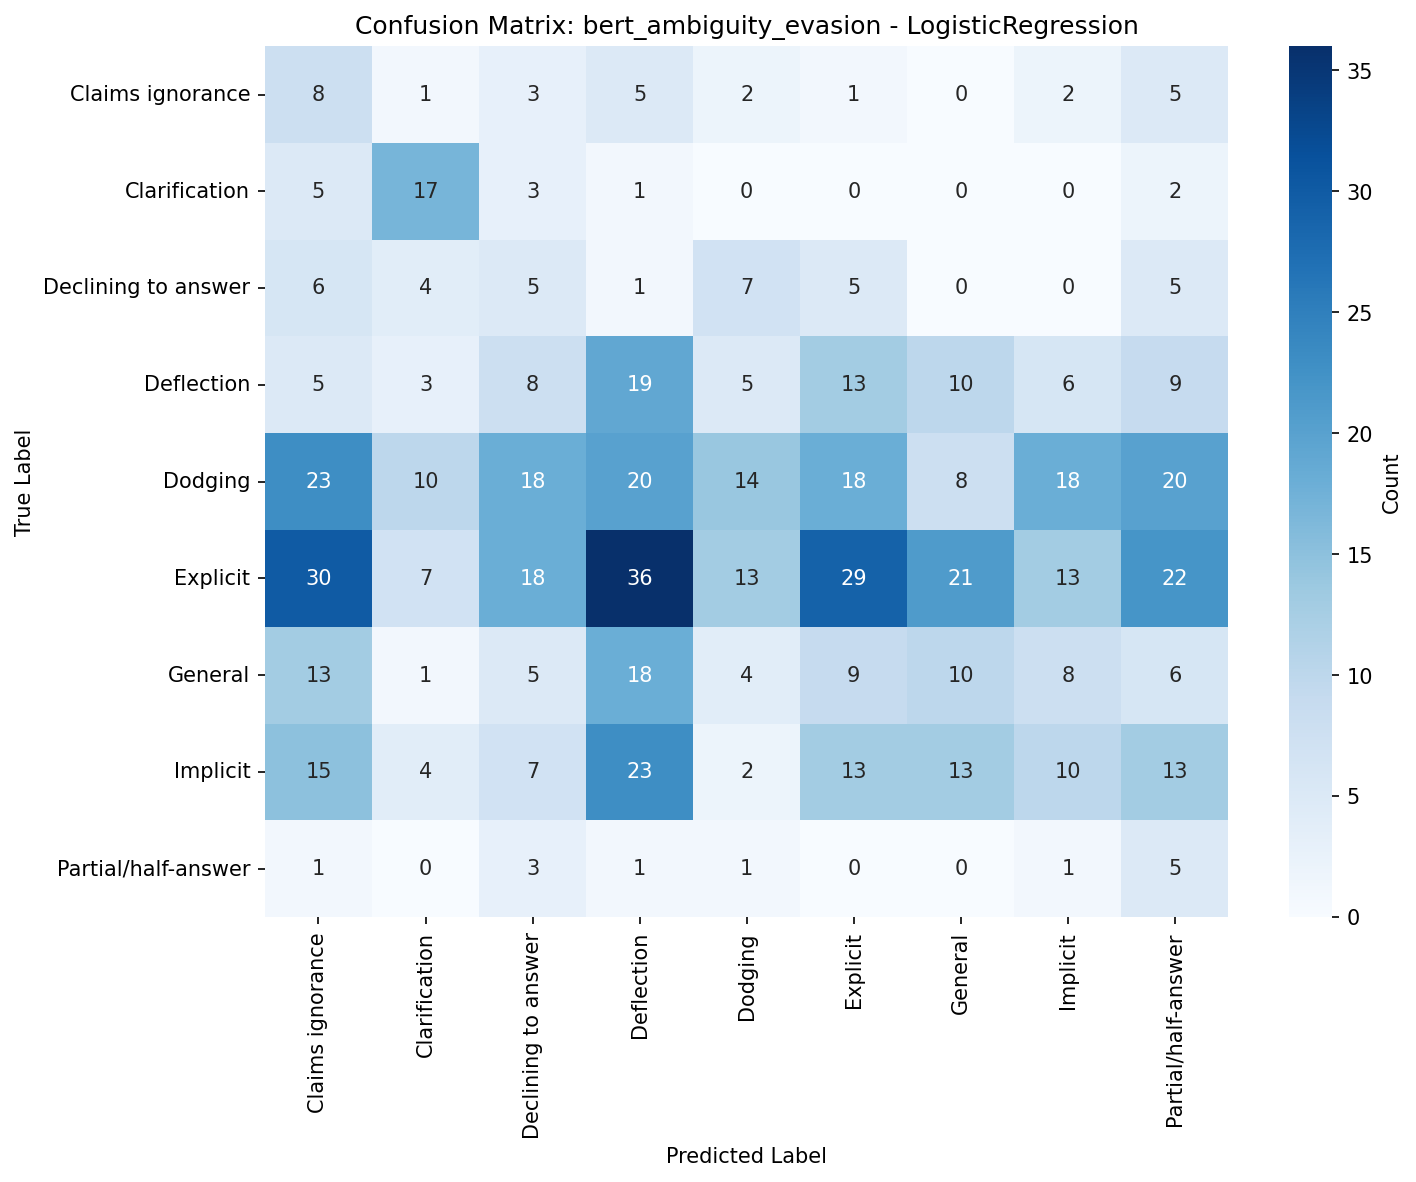

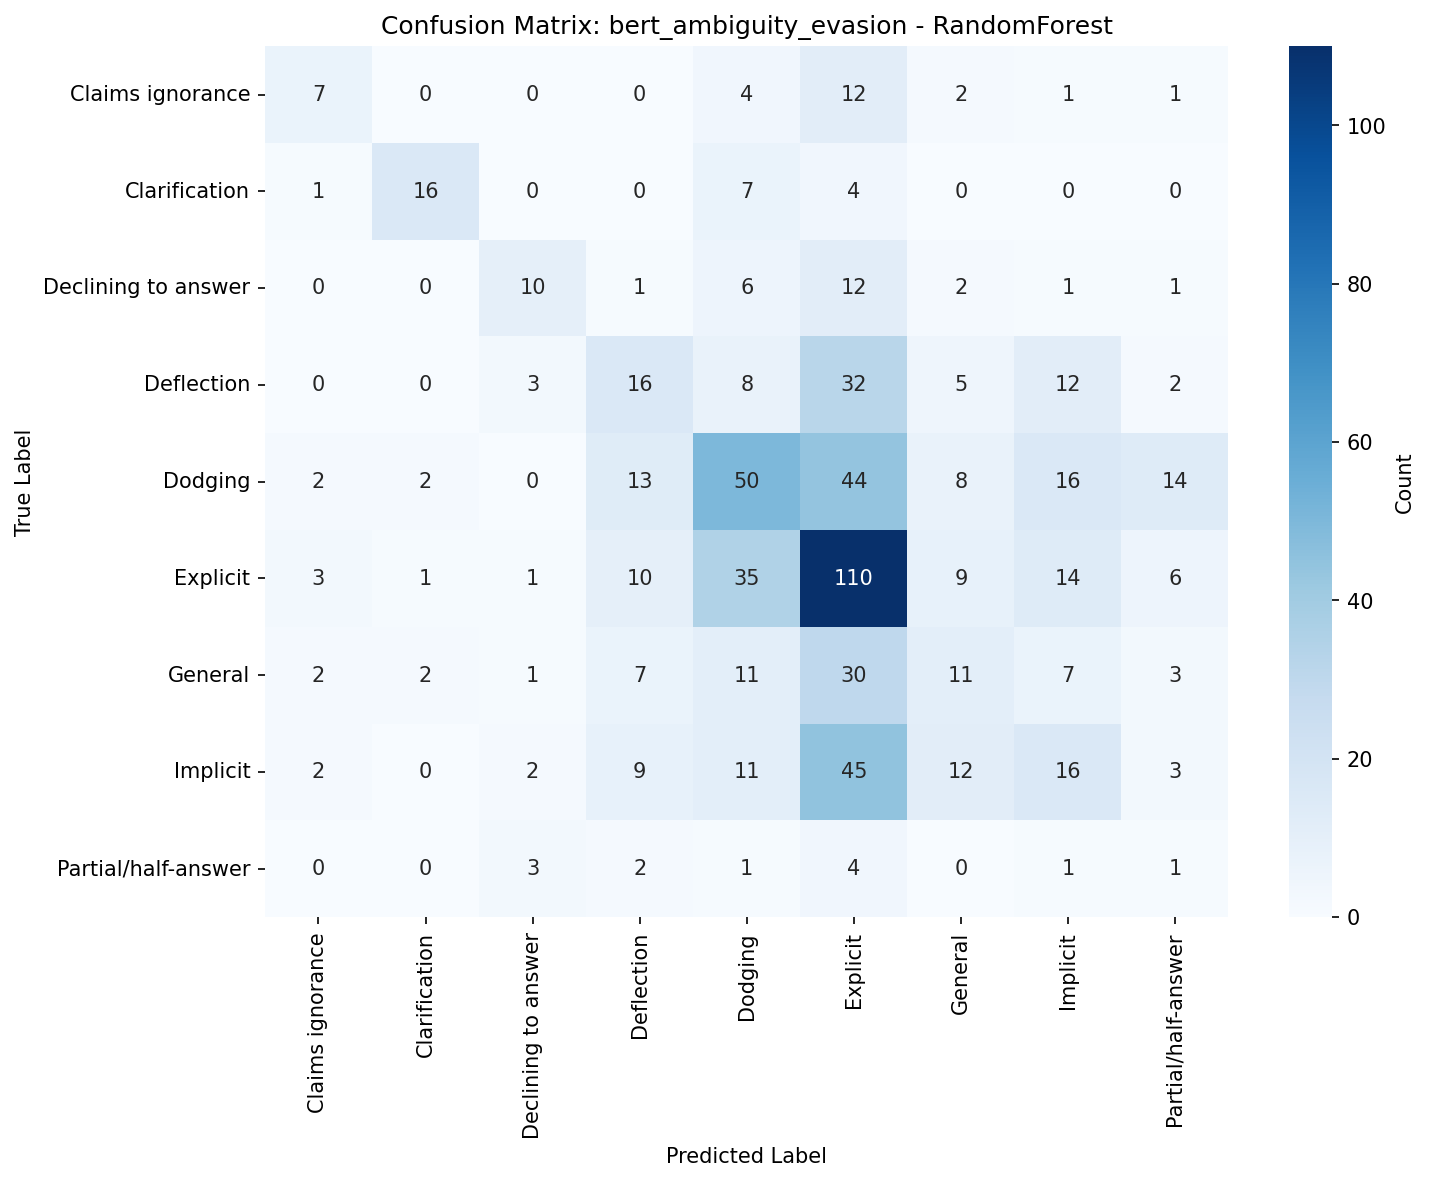

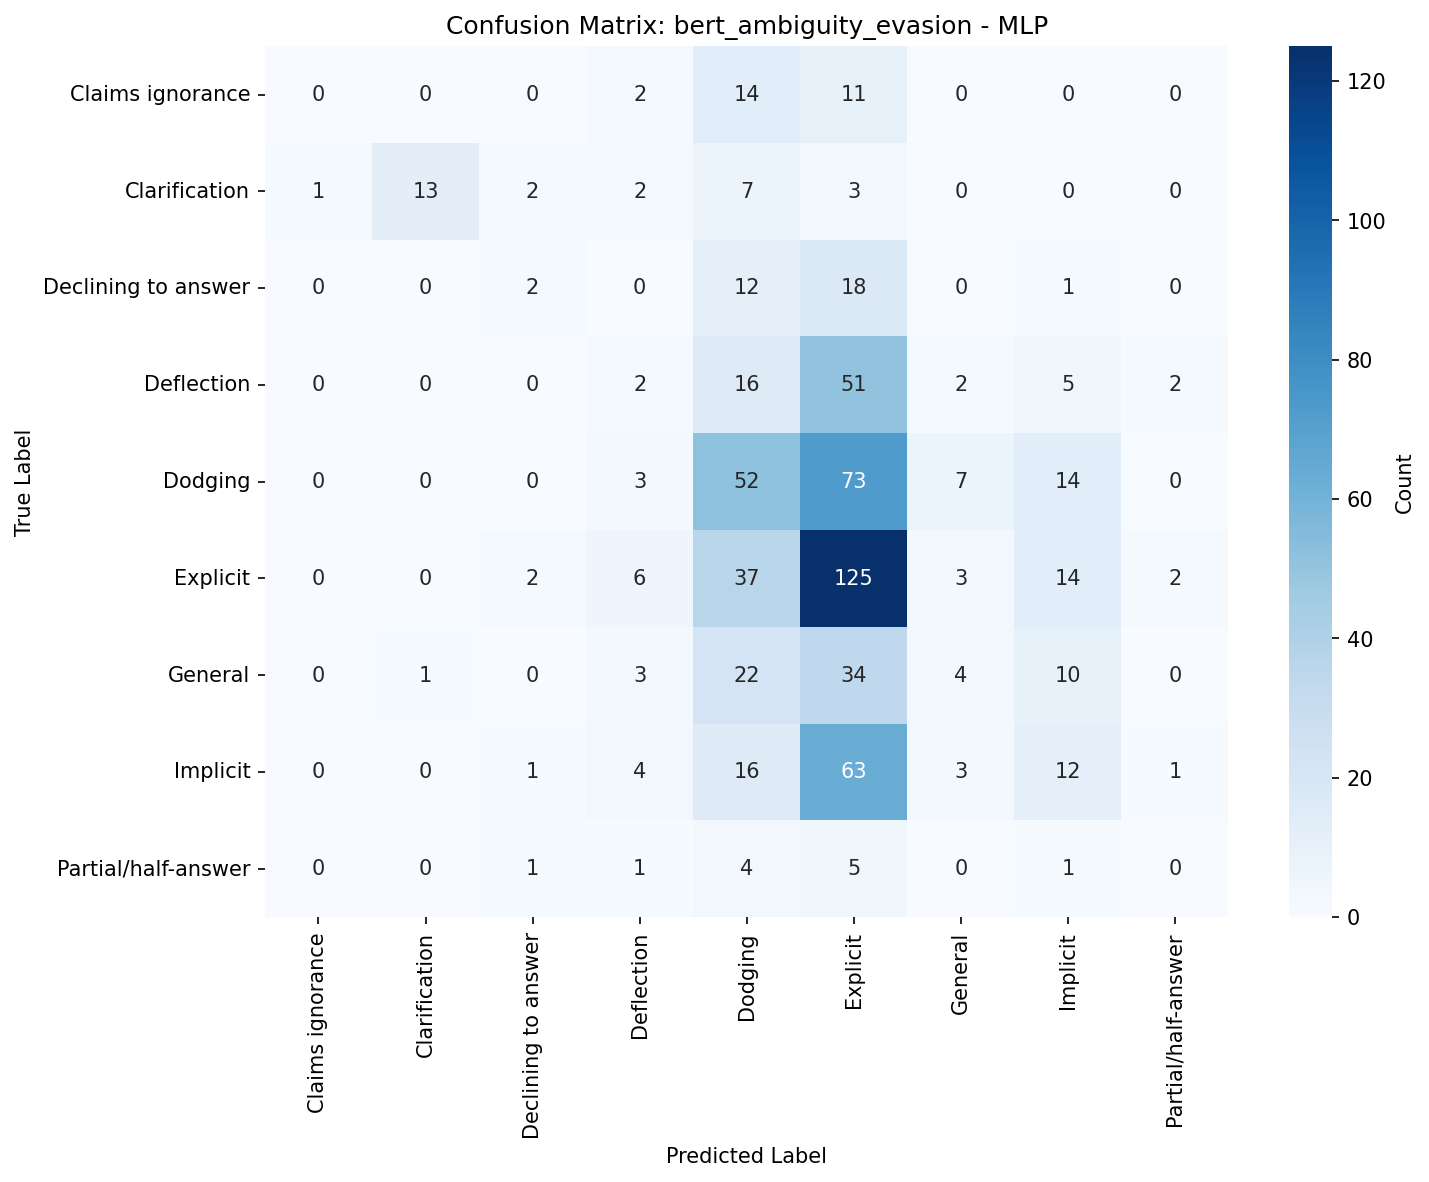

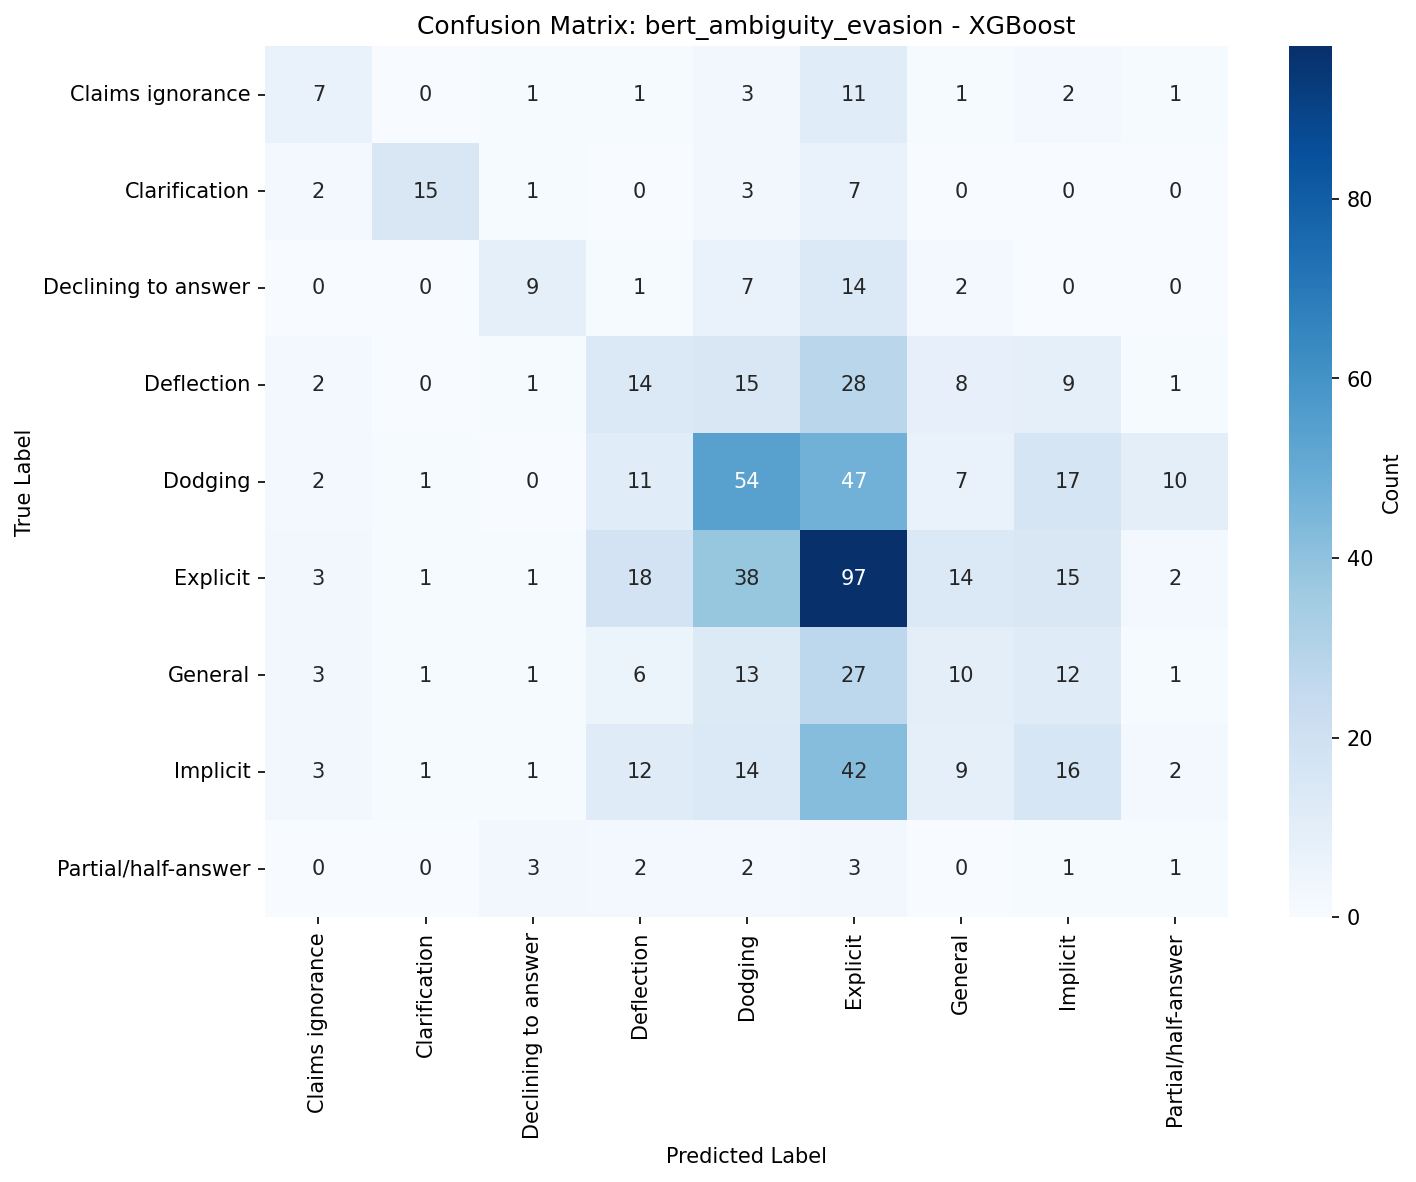

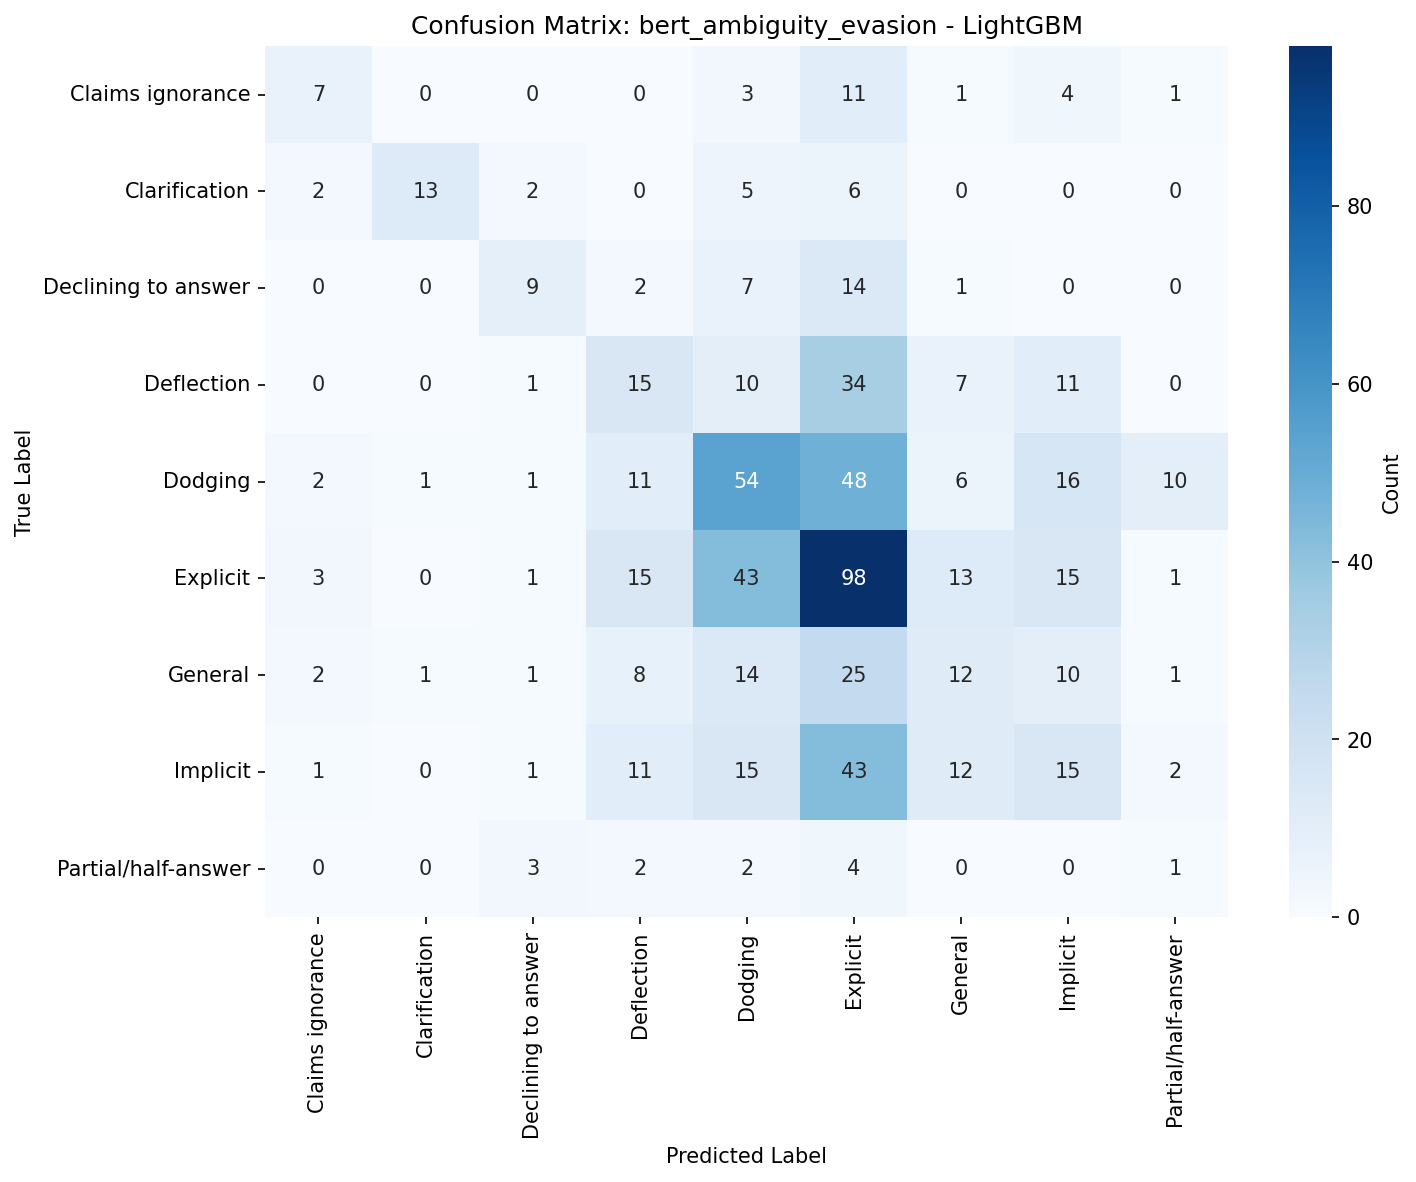


Results Table: roberta_clarity
        Classifier            Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
      RandomForest roberta_clarity  0.581159  0.502416     0.567780         0.534459      0.485369
           XGBoost roberta_clarity  0.579710  0.500111     0.569007         0.539182      0.480403
          LightGBM roberta_clarity  0.591304  0.491581     0.570470         0.547781      0.470265
         LinearSVC roberta_clarity  0.575362  0.453325     0.545402         0.477275      0.453111
               MLP roberta_clarity  0.611594  0.441473     0.551783         0.599682      0.429866
LogisticRegression roberta_clarity  0.434783  0.403464     0.452436         0.406522      0.449076

Per-Class Metrics: roberta_clarity - RandomForest (Best by Macro F1)
          Class  Precision   Recall  F1-Score  Support
     Ambivalent   0.641509 0.740920  0.687640      413
Clear Non-Reply   0.564516 0.397727  0.466667       88
    Clear Reply   0.397351 0.317460  0.3

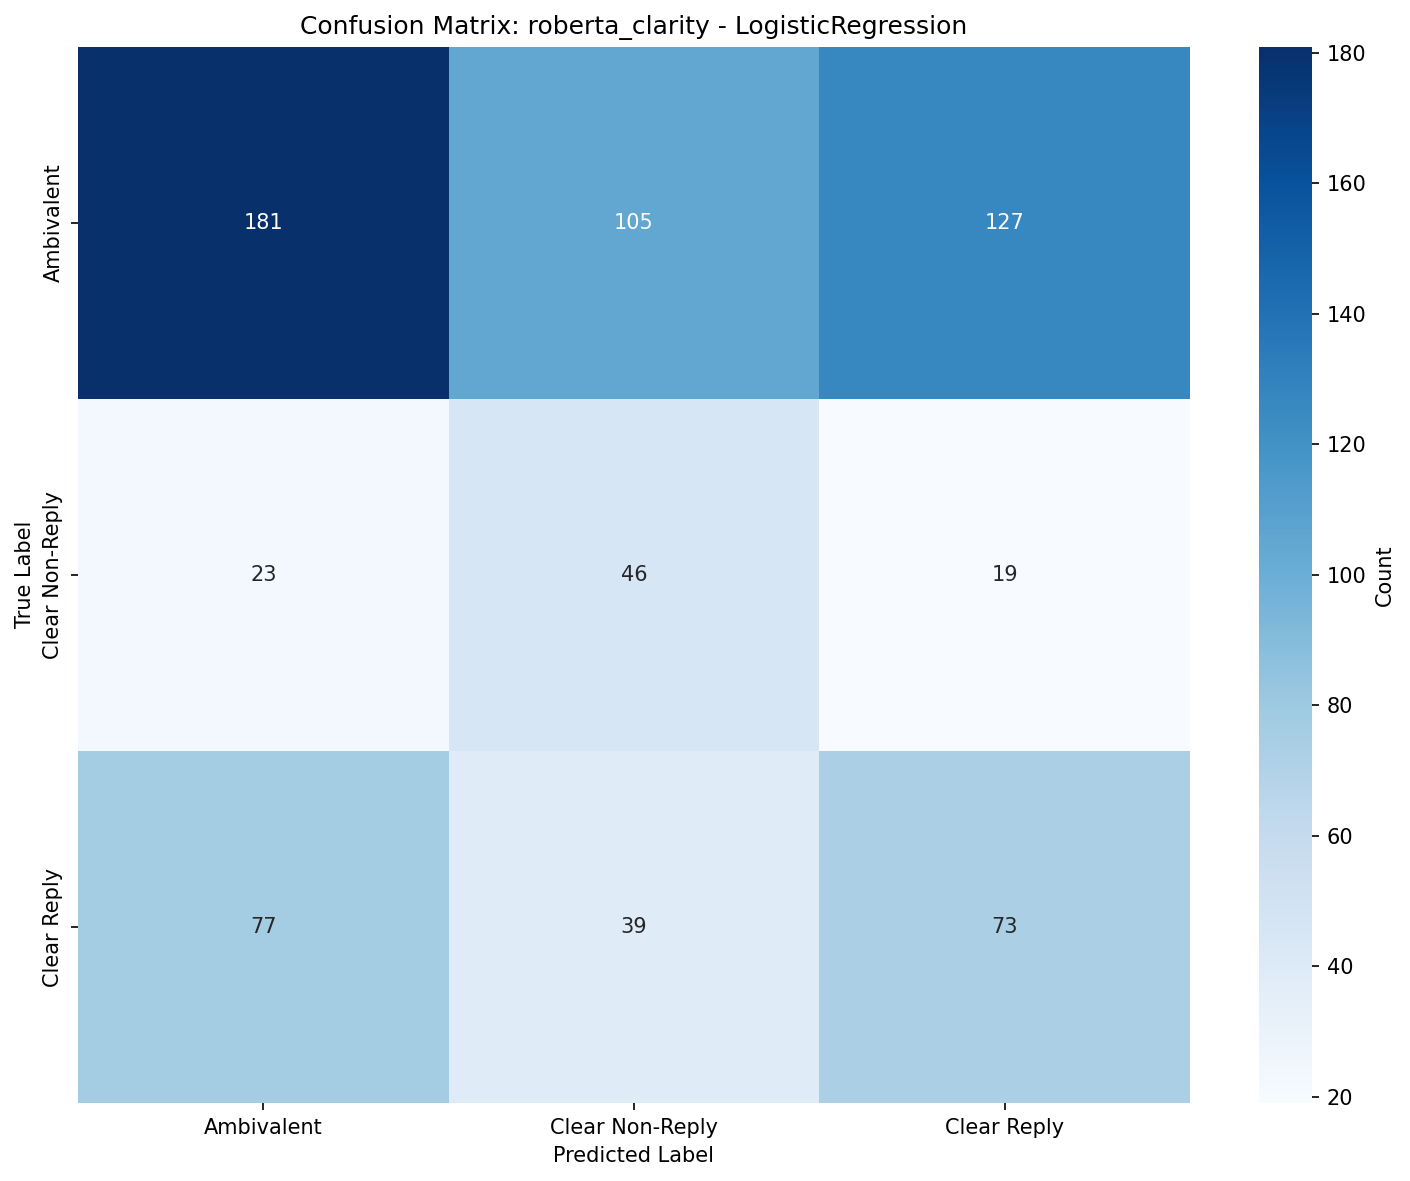

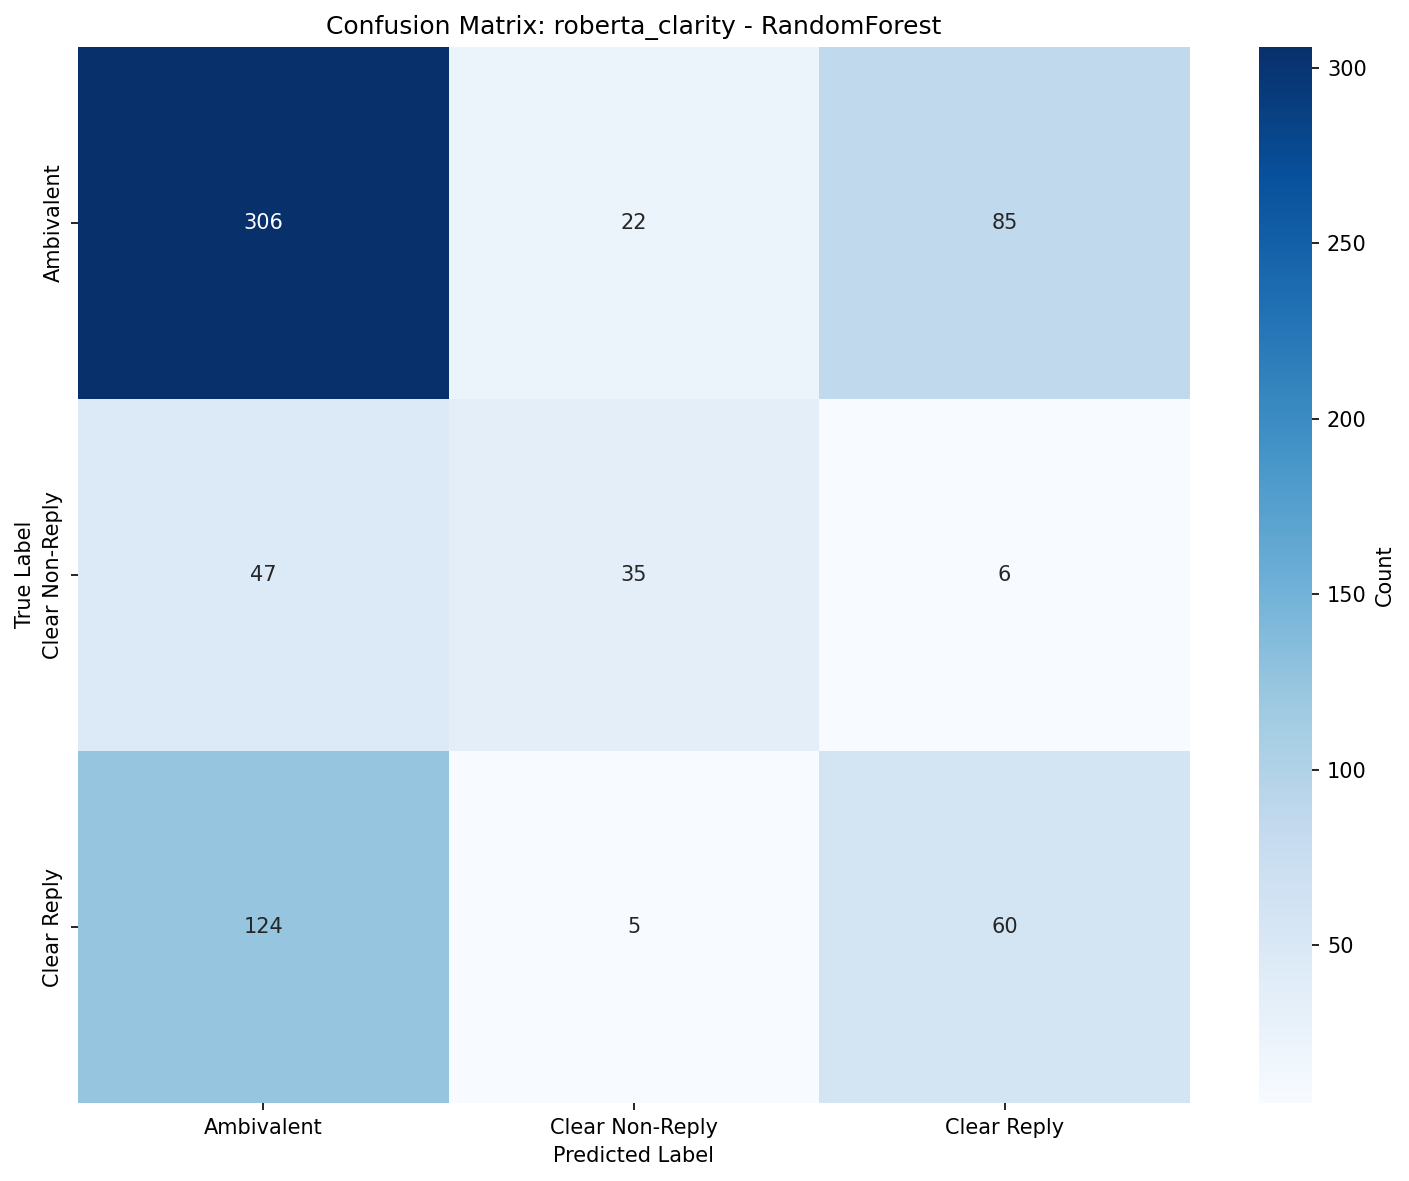

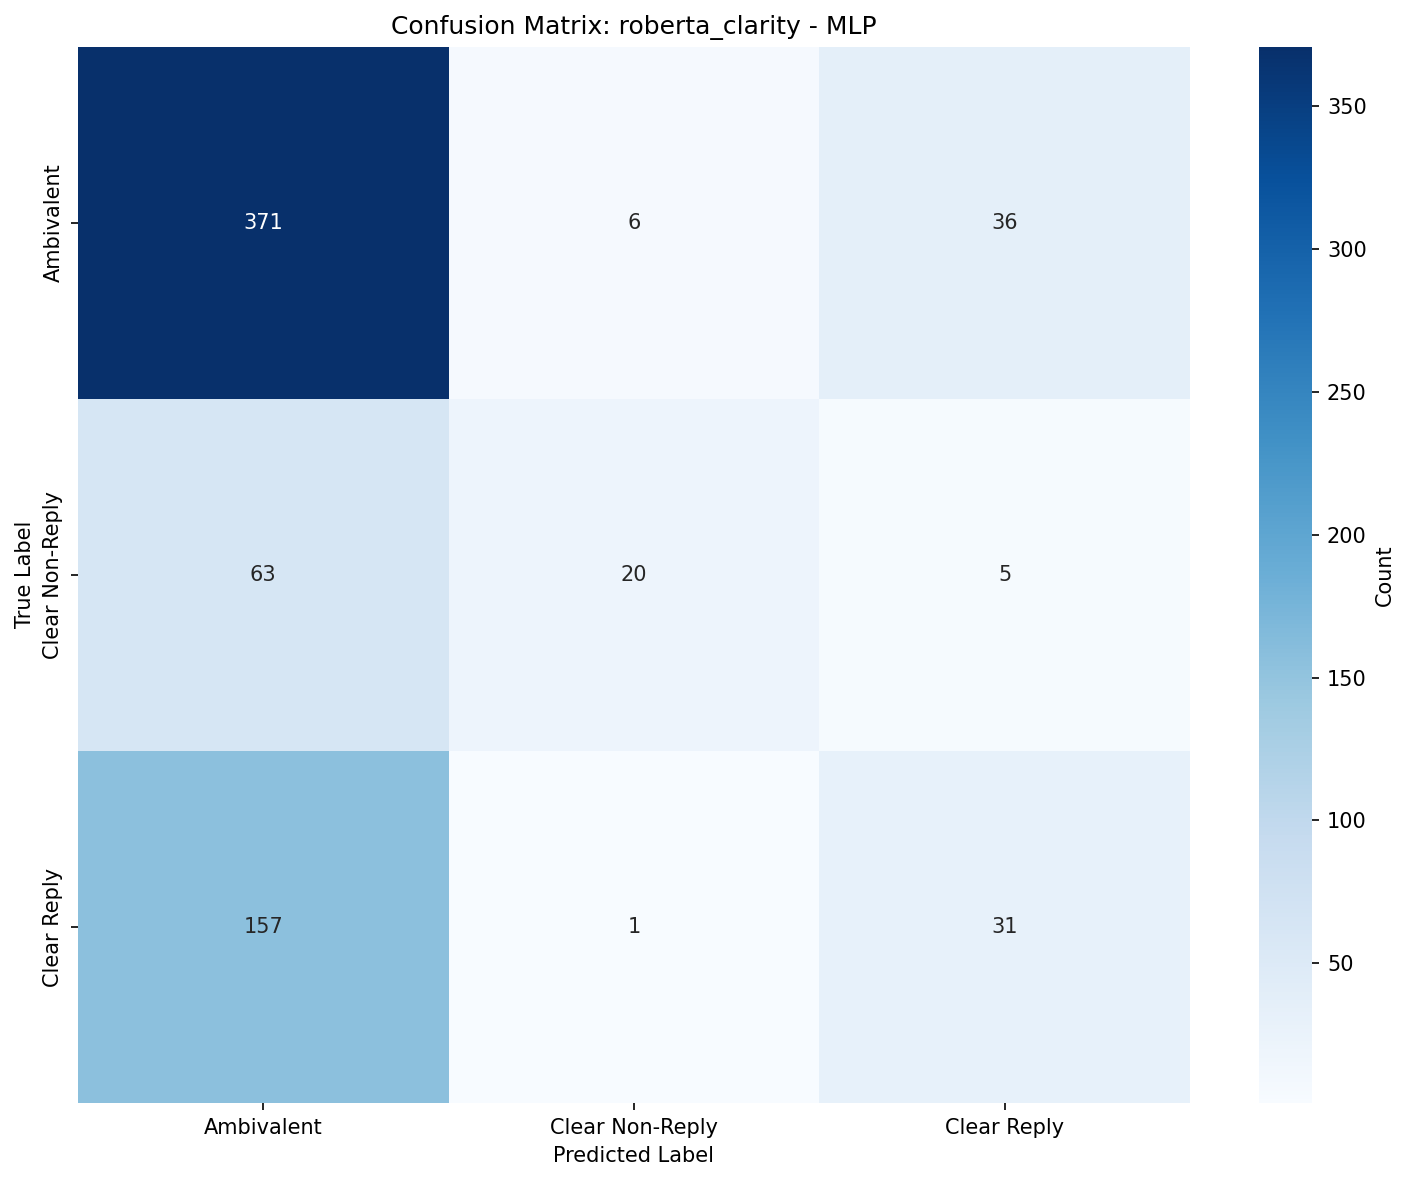

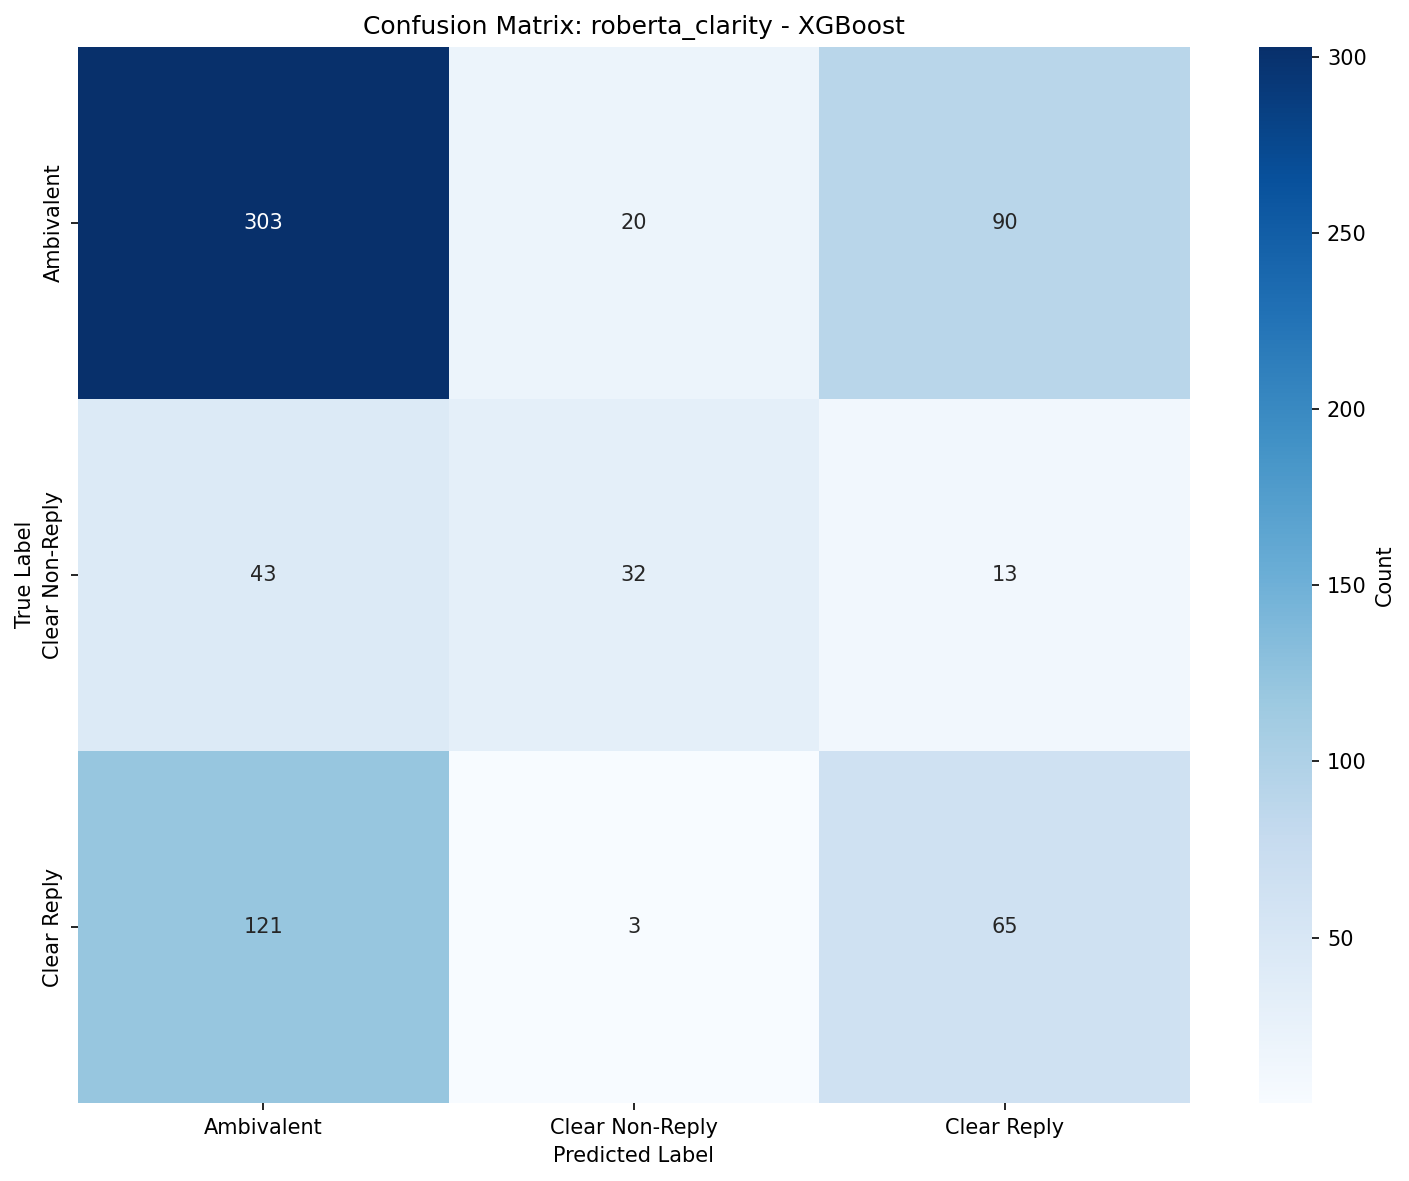

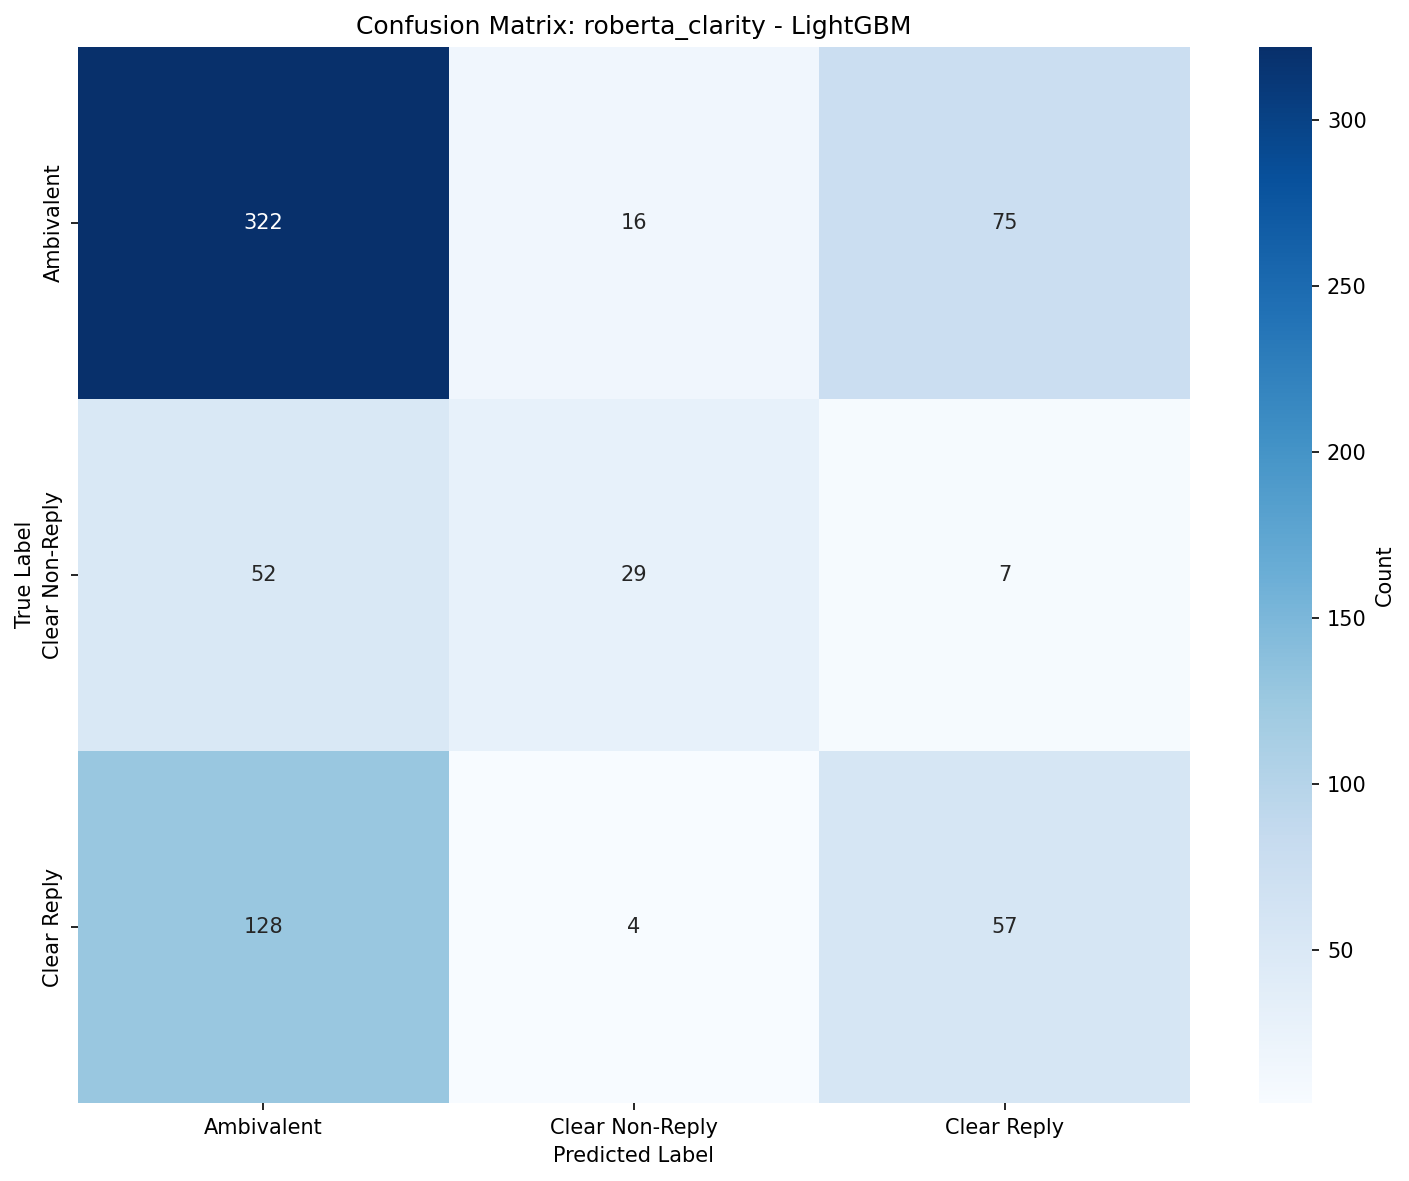


Results Table: roberta_evasion
        Classifier            Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
      RandomForest roberta_evasion  0.342029  0.310696     0.335564         0.355474      0.290374
           XGBoost roberta_evasion  0.321739  0.289846     0.312997         0.346144      0.265763
          LightGBM roberta_evasion  0.323188  0.289282     0.312818         0.334896      0.268649
         LinearSVC roberta_evasion  0.223188  0.199169     0.222149         0.207724      0.262201
LogisticRegression roberta_evasion  0.172464  0.185694     0.173708         0.201111      0.255803
               MLP roberta_evasion  0.305797  0.157306     0.217732         0.190394      0.177509

Per-Class Metrics: roberta_evasion - RandomForest (Best by Macro F1)
              Class  Precision   Recall  F1-Score  Support
   Claims ignorance   0.333333 0.259259  0.291667       27
      Clarification   0.823529 0.500000  0.622222       28
Declining to answer   0.4761

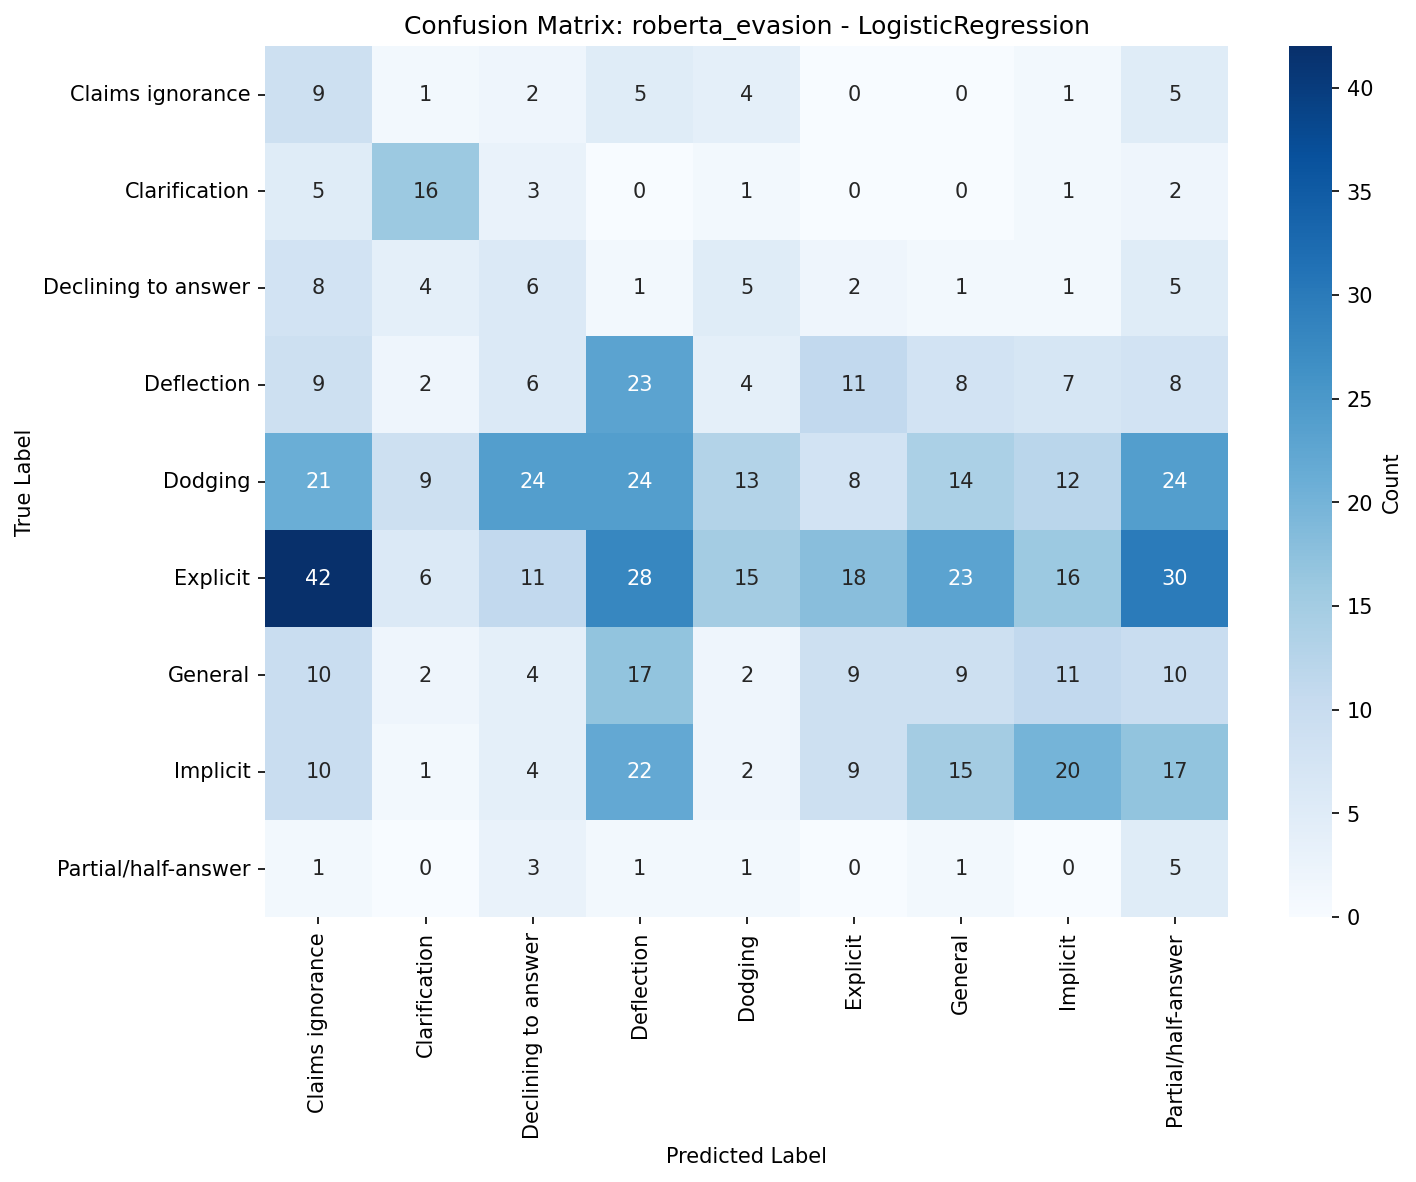

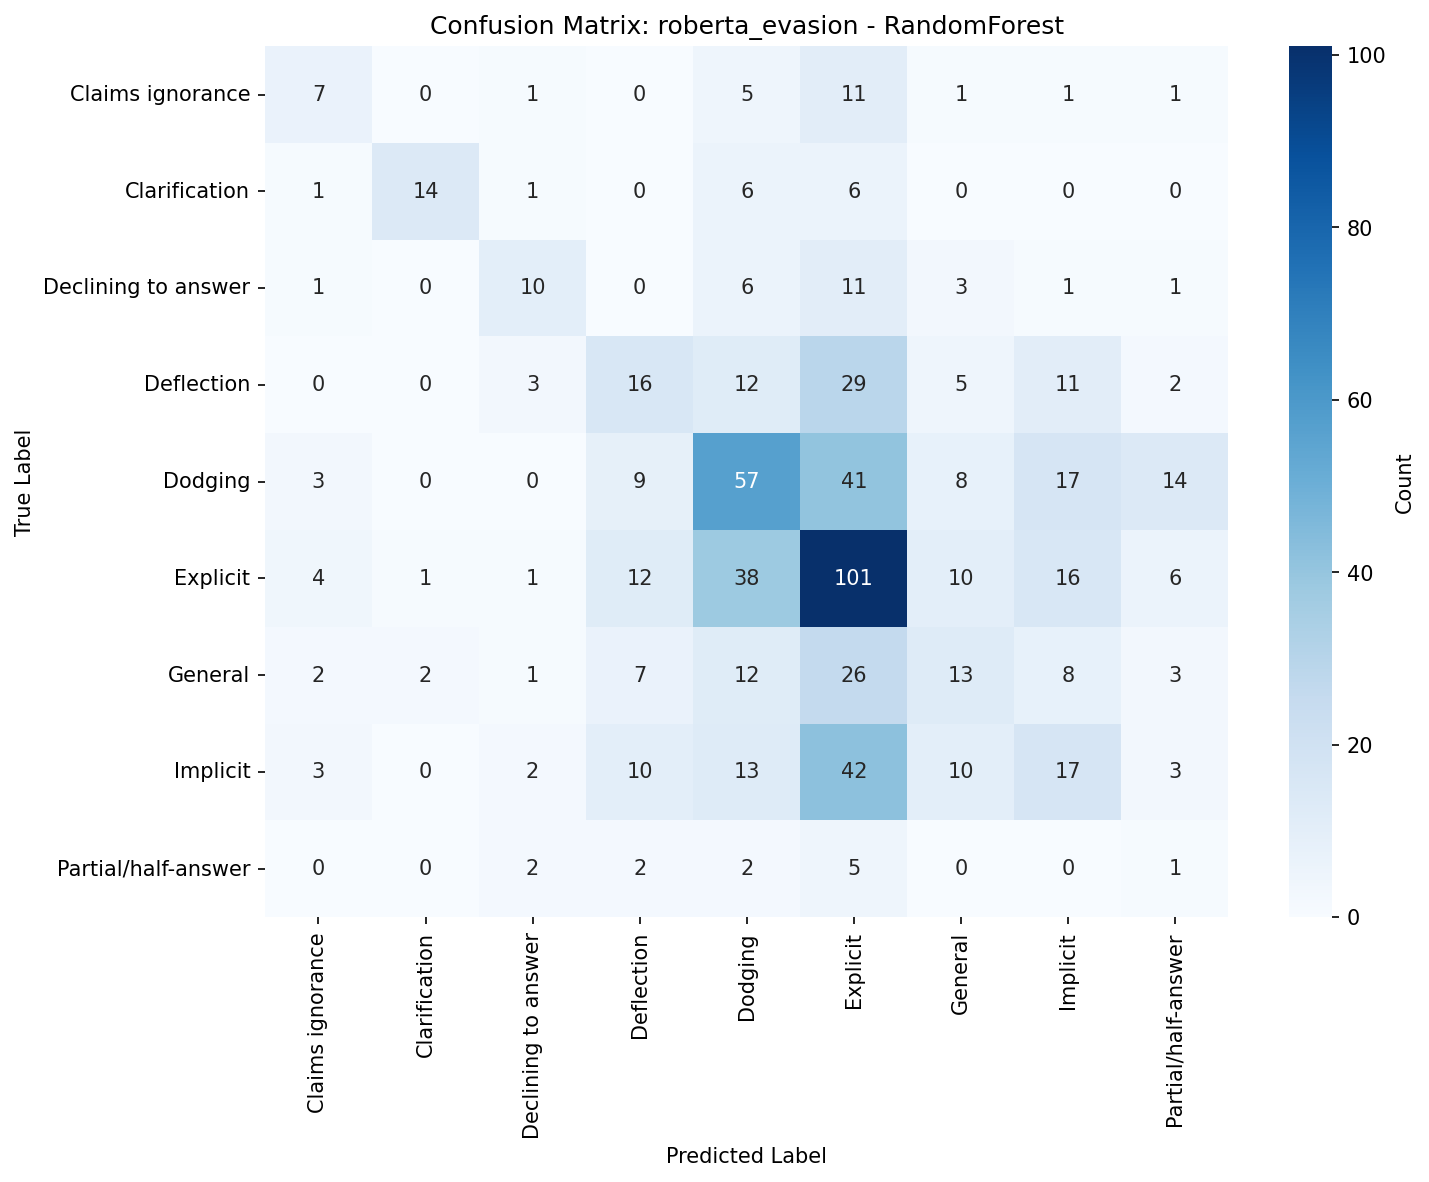

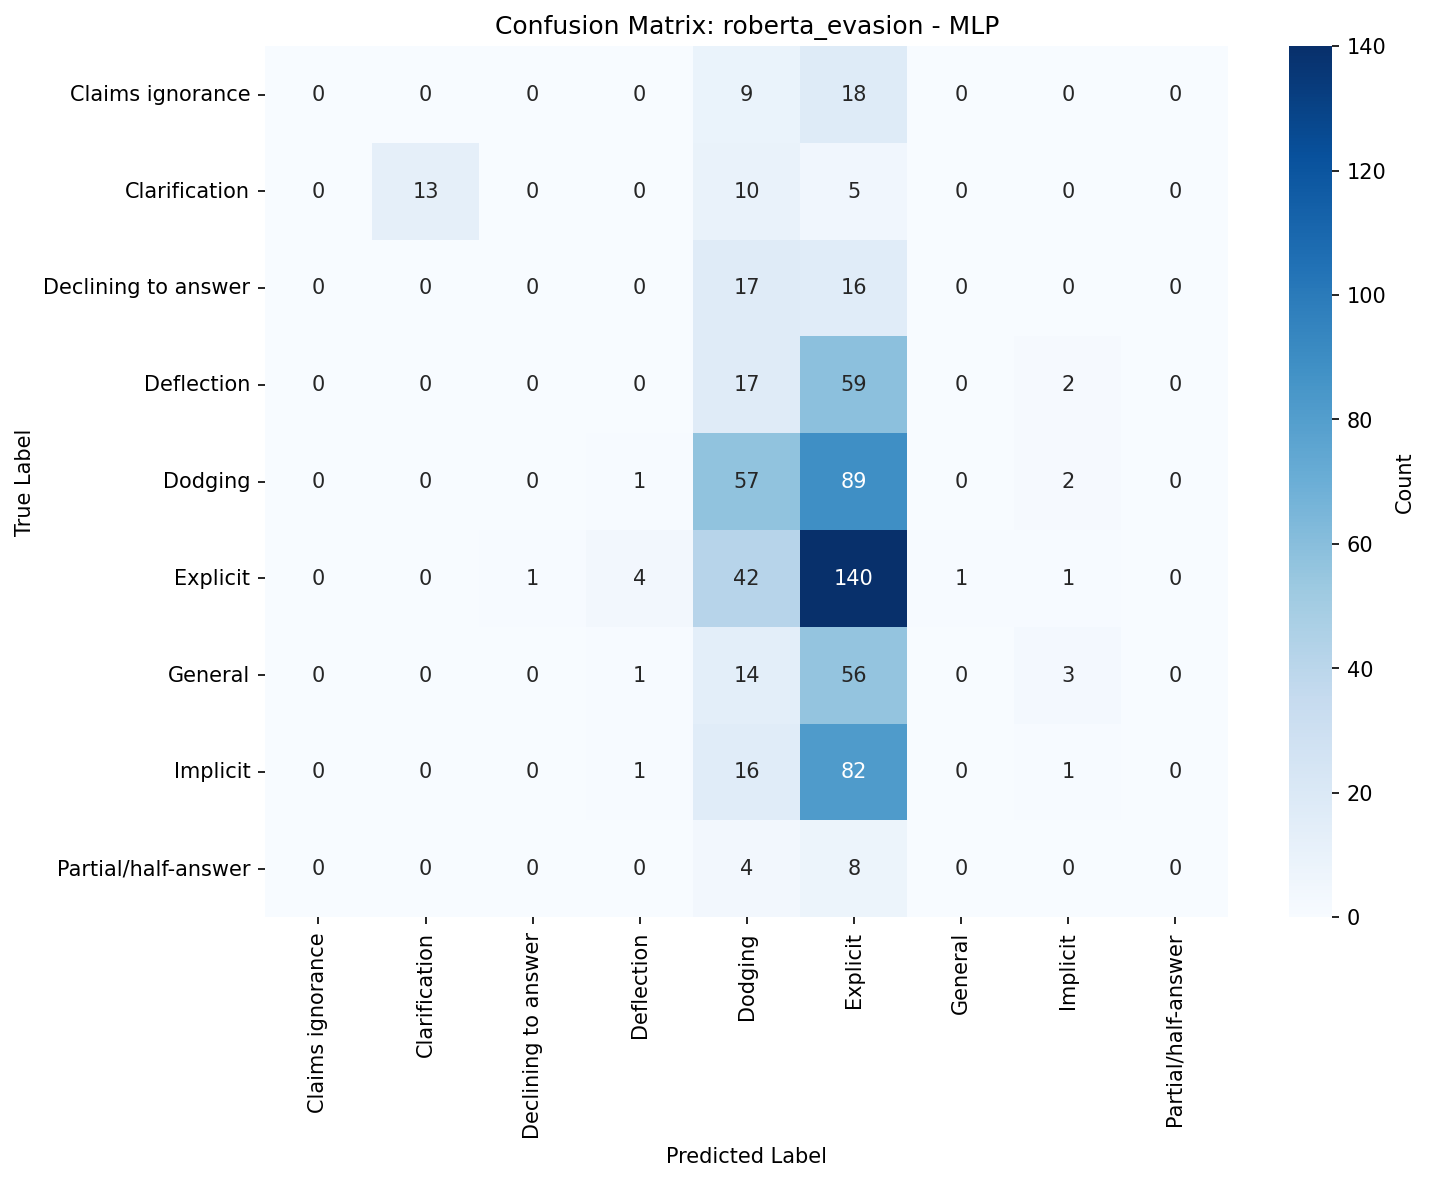

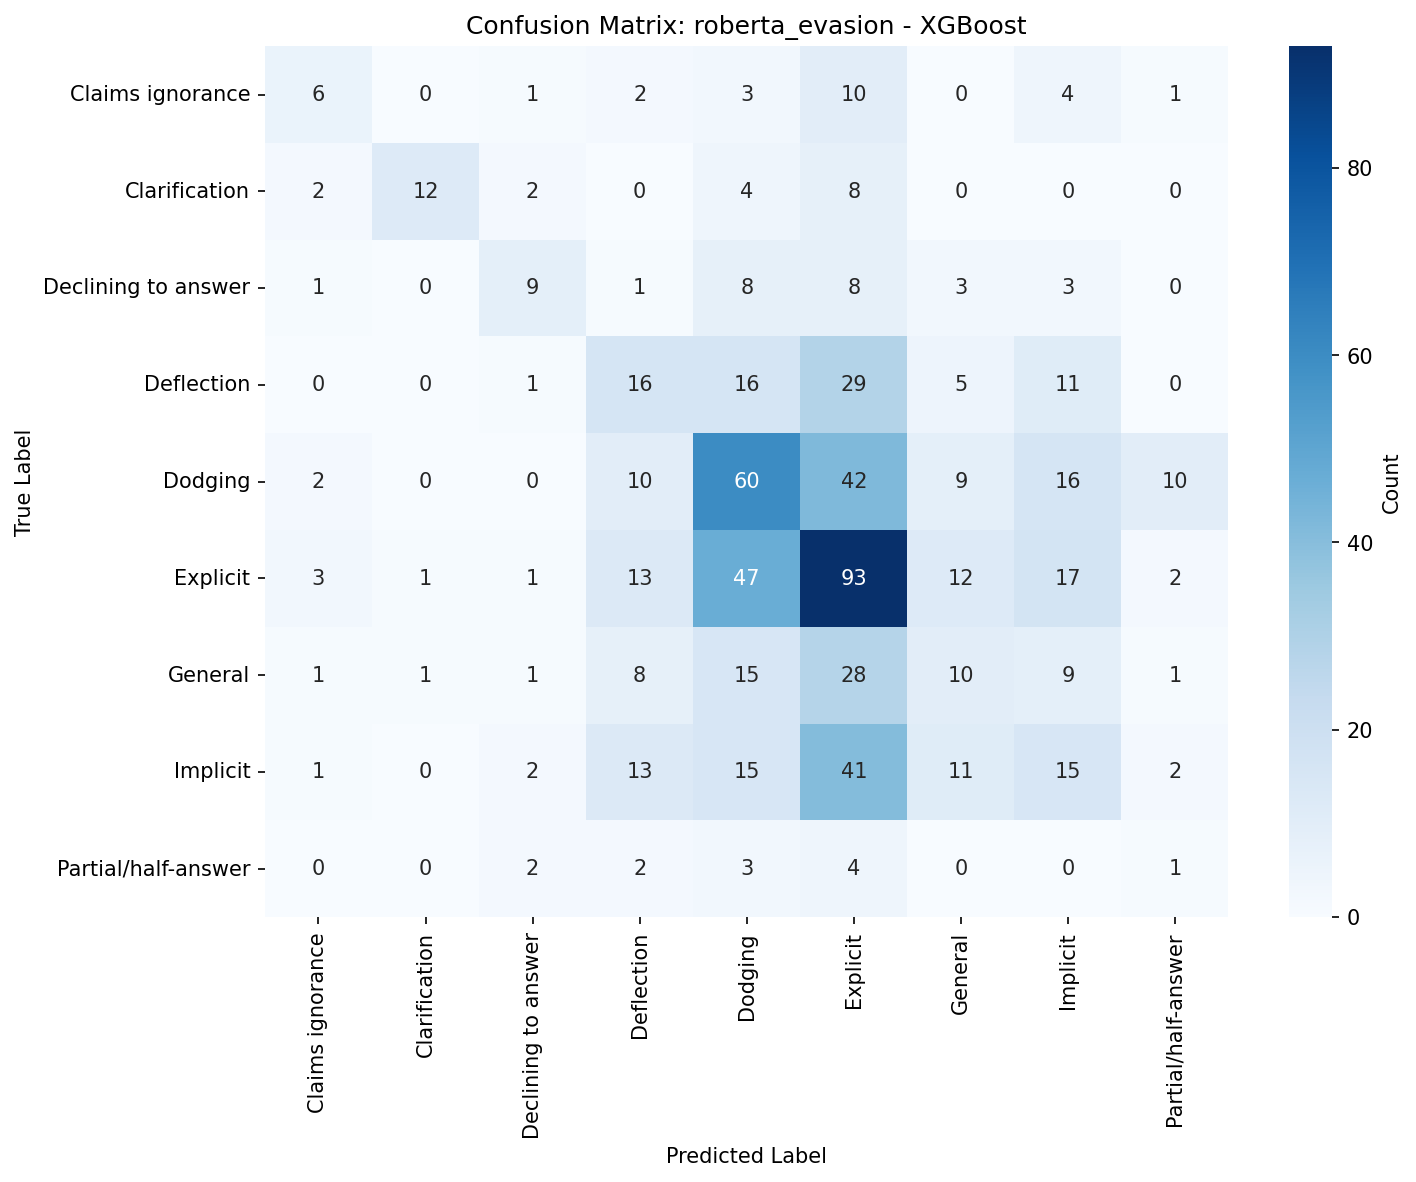

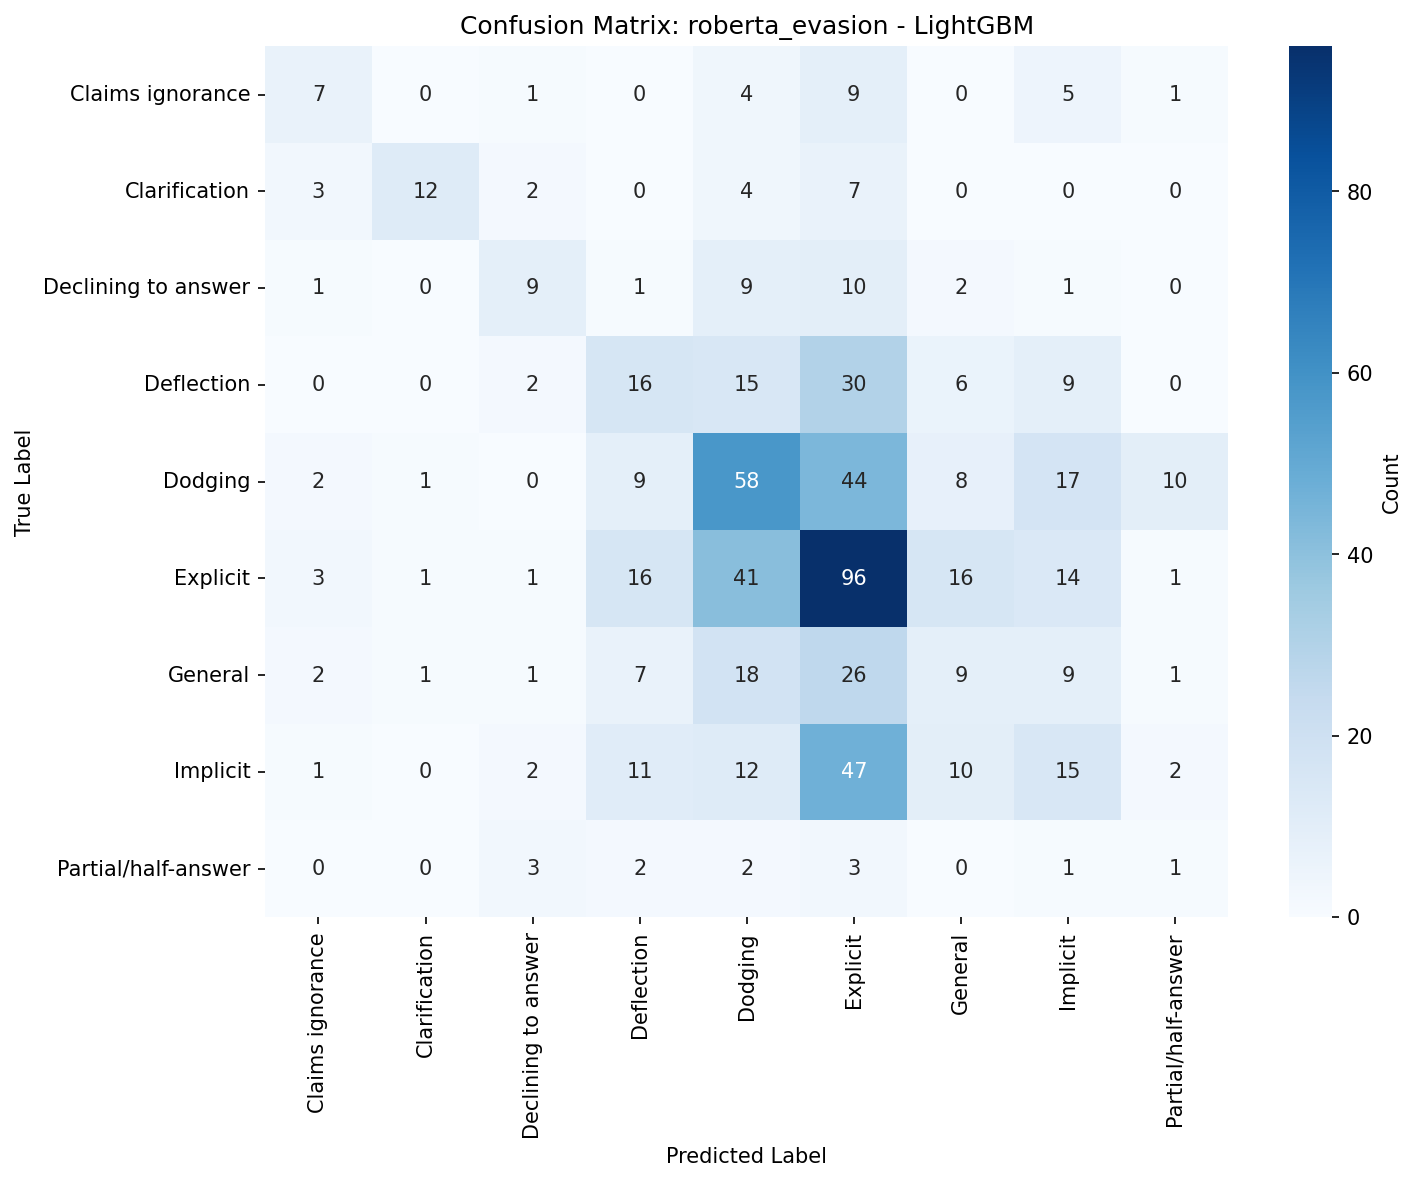


Results Table: deberta_clarity
        Classifier            Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
           XGBoost deberta_clarity  0.600000  0.523778     0.588096         0.570610      0.500644
      RandomForest deberta_clarity  0.597101  0.522268     0.586197         0.560216      0.501900
          LightGBM deberta_clarity  0.597101  0.510026     0.582243         0.551186      0.490199
               MLP deberta_clarity  0.626087  0.435266     0.557615         0.665401      0.426971
         LinearSVC deberta_clarity  0.560870  0.432552     0.530826         0.452126      0.441213
LogisticRegression deberta_clarity  0.452174  0.421918     0.466929         0.420303      0.473776

Per-Class Metrics: deberta_clarity - XGBoost (Best by Macro F1)
          Class  Precision   Recall  F1-Score  Support
     Ambivalent   0.662447 0.760291  0.708005      413
Clear Non-Reply   0.648148 0.397727  0.492958       88
    Clear Reply   0.401235 0.343915  0.370370

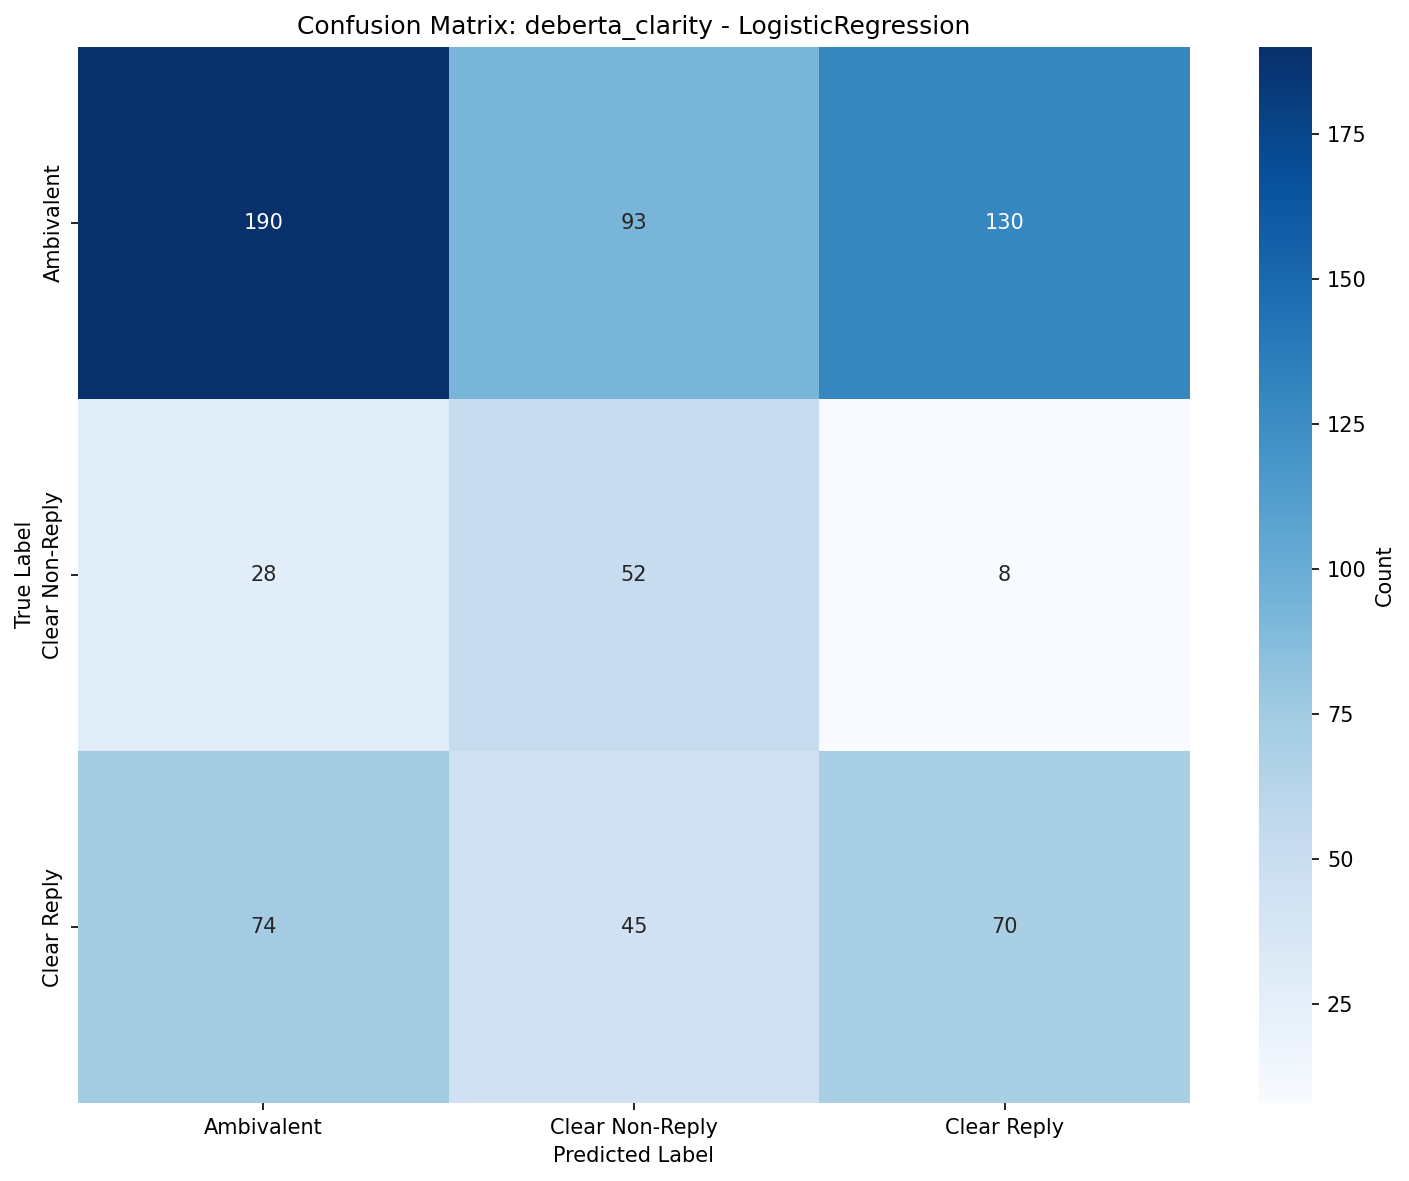

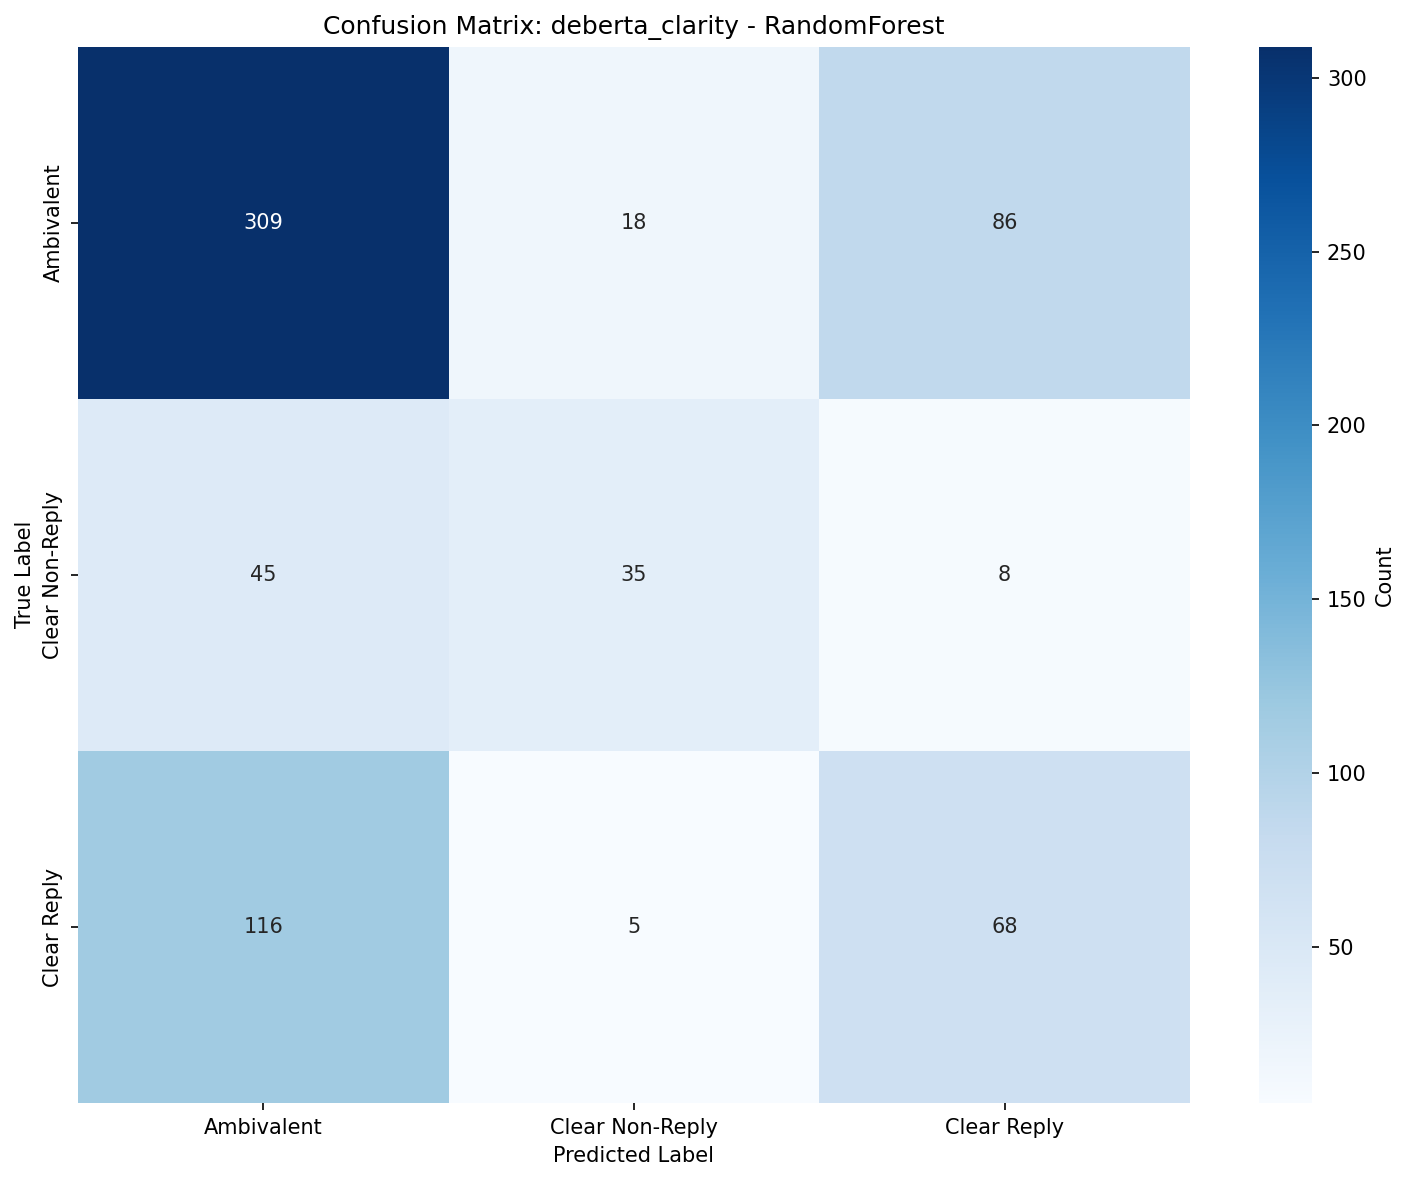

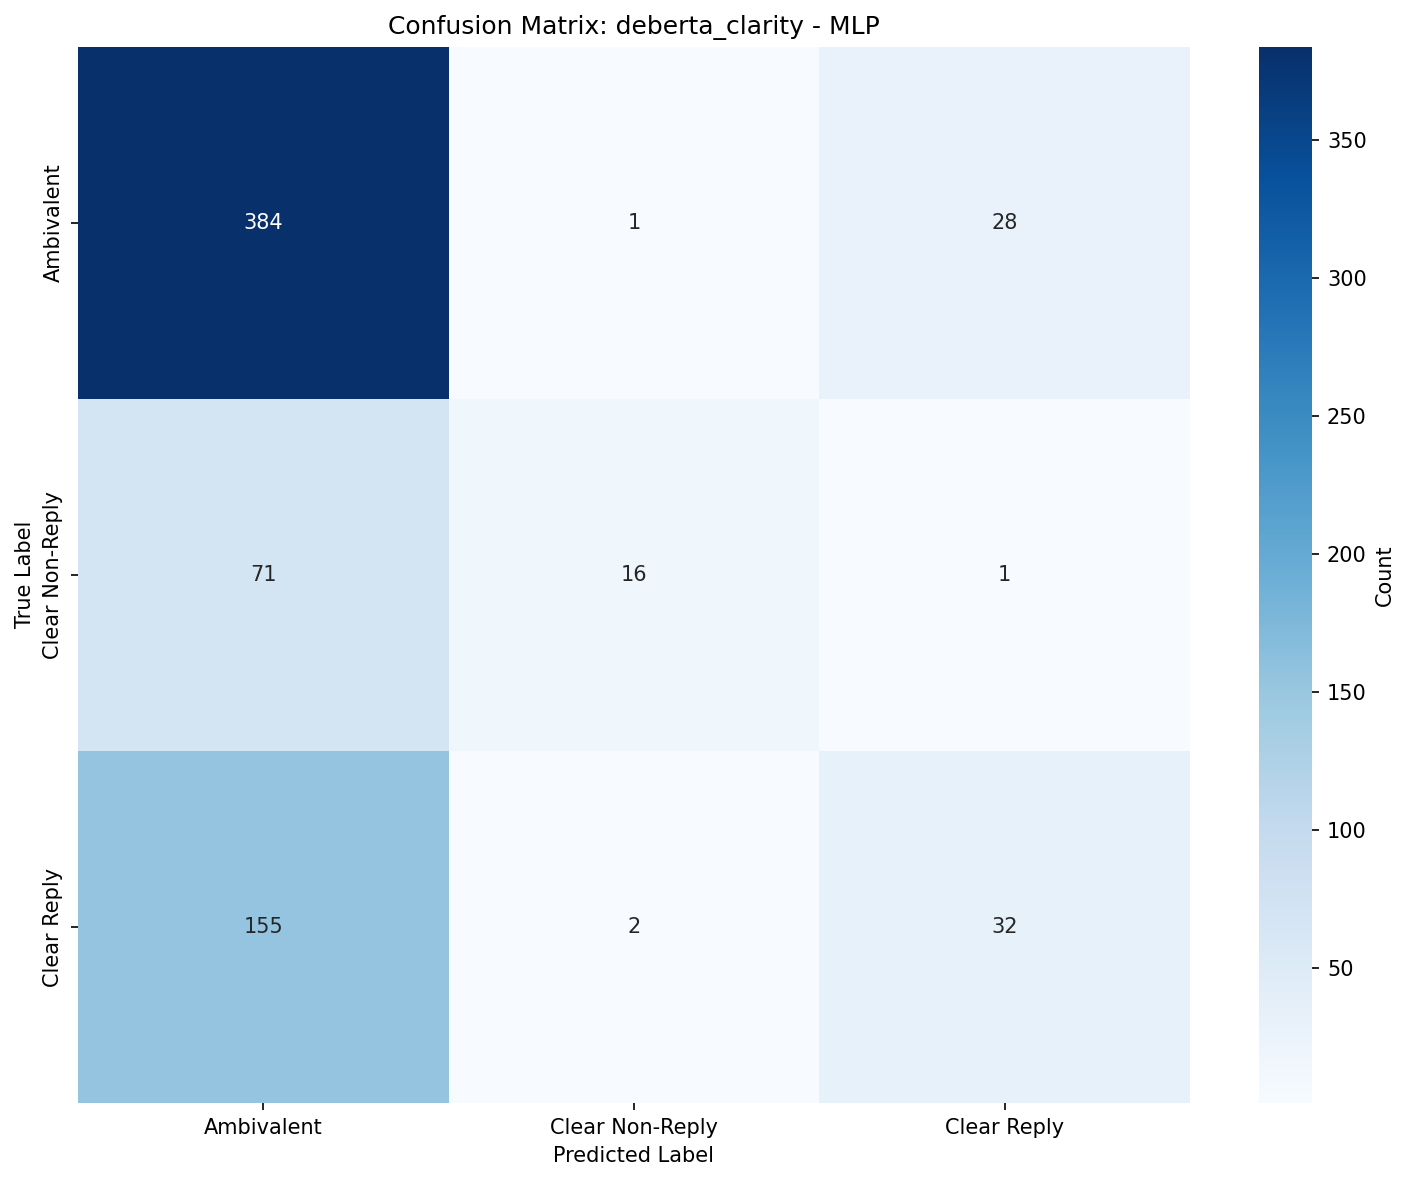

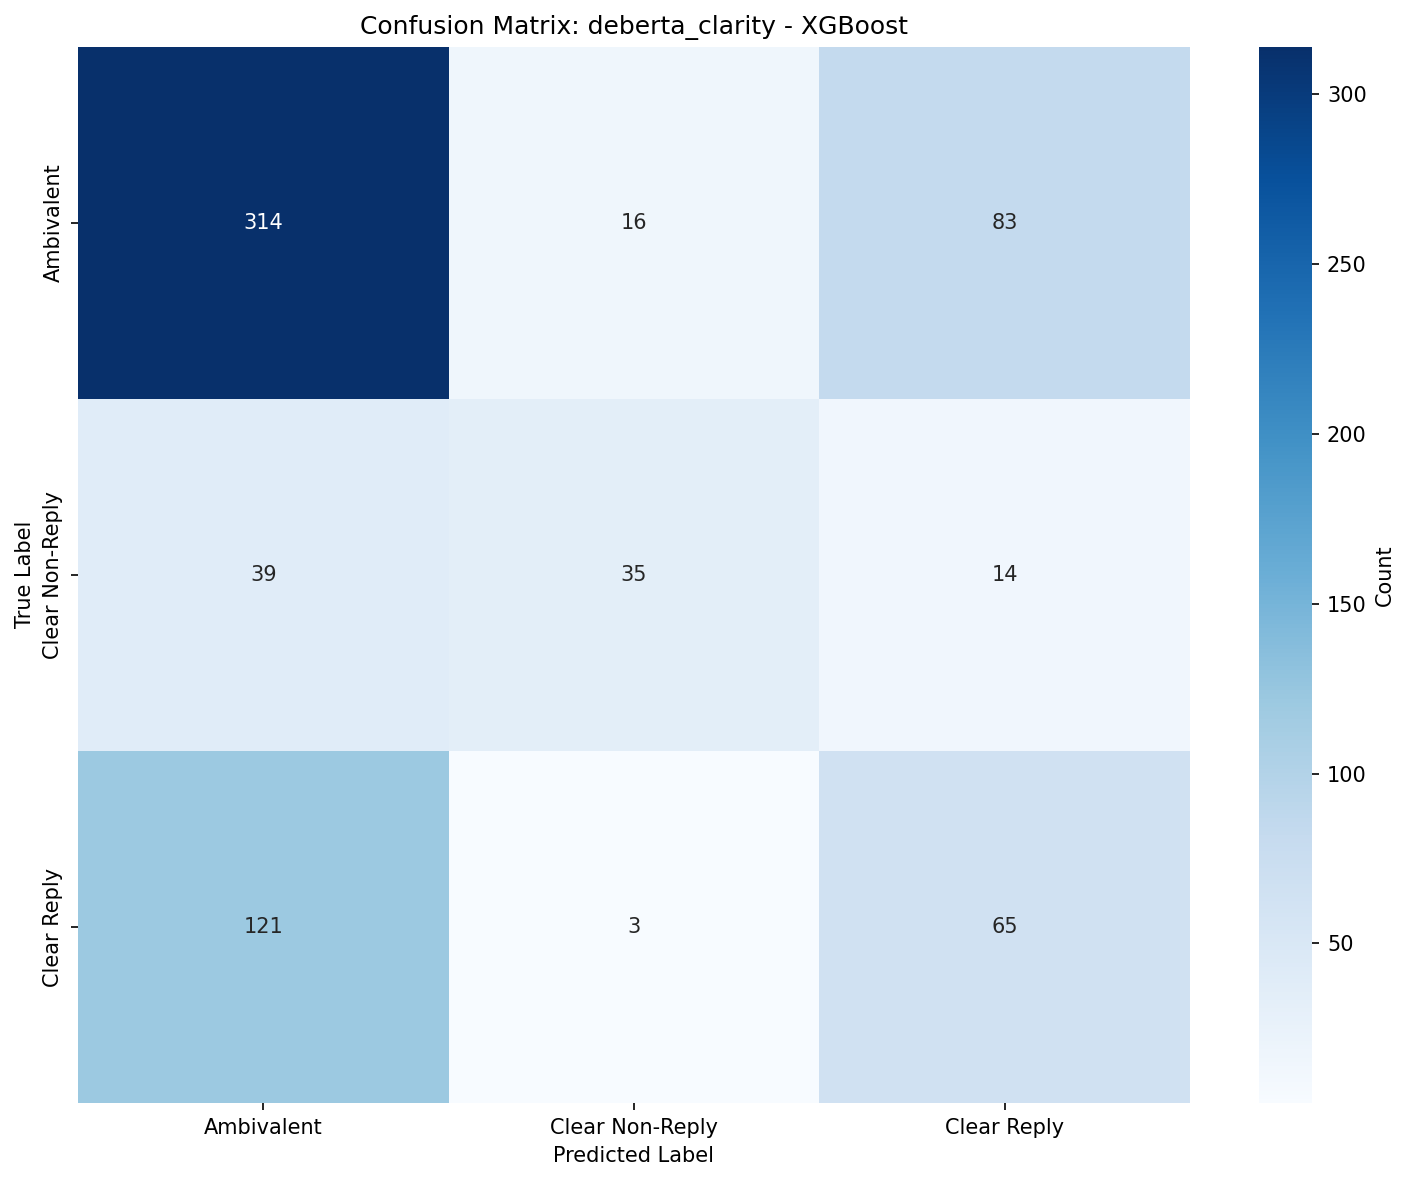

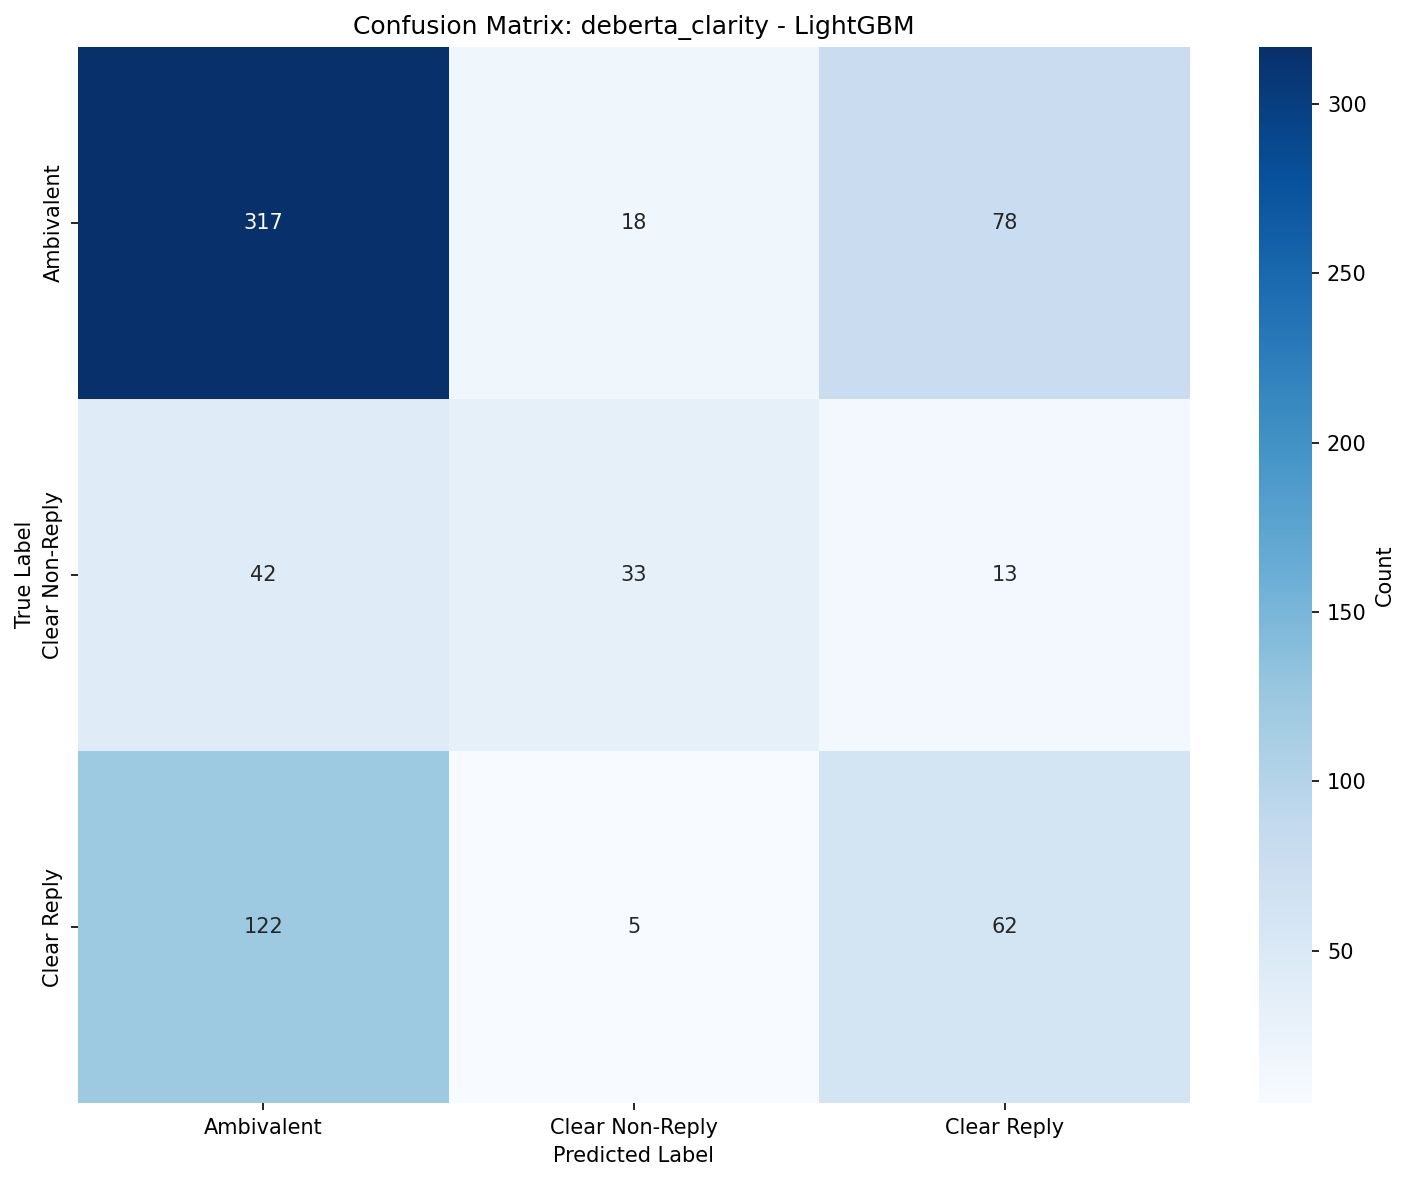


Results Table: deberta_evasion
        Classifier            Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
           XGBoost deberta_evasion  0.331884  0.310107     0.324119         0.349993      0.289304
      RandomForest deberta_evasion  0.336232  0.307965     0.329107         0.346855      0.289921
          LightGBM deberta_evasion  0.337681  0.305405     0.325870         0.355851      0.282775
               MLP deberta_evasion  0.307246  0.220568     0.260804         0.322396      0.207798
         LinearSVC deberta_evasion  0.223188  0.198742     0.222941         0.204182      0.268679
LogisticRegression deberta_evasion  0.163768  0.169723     0.159264         0.189602      0.245425

Per-Class Metrics: deberta_evasion - XGBoost (Best by Macro F1)
              Class  Precision   Recall  F1-Score  Support
   Claims ignorance   0.388889 0.259259  0.311111       27
      Clarification   0.888889 0.571429  0.695652       28
Declining to answer   0.409091 0.

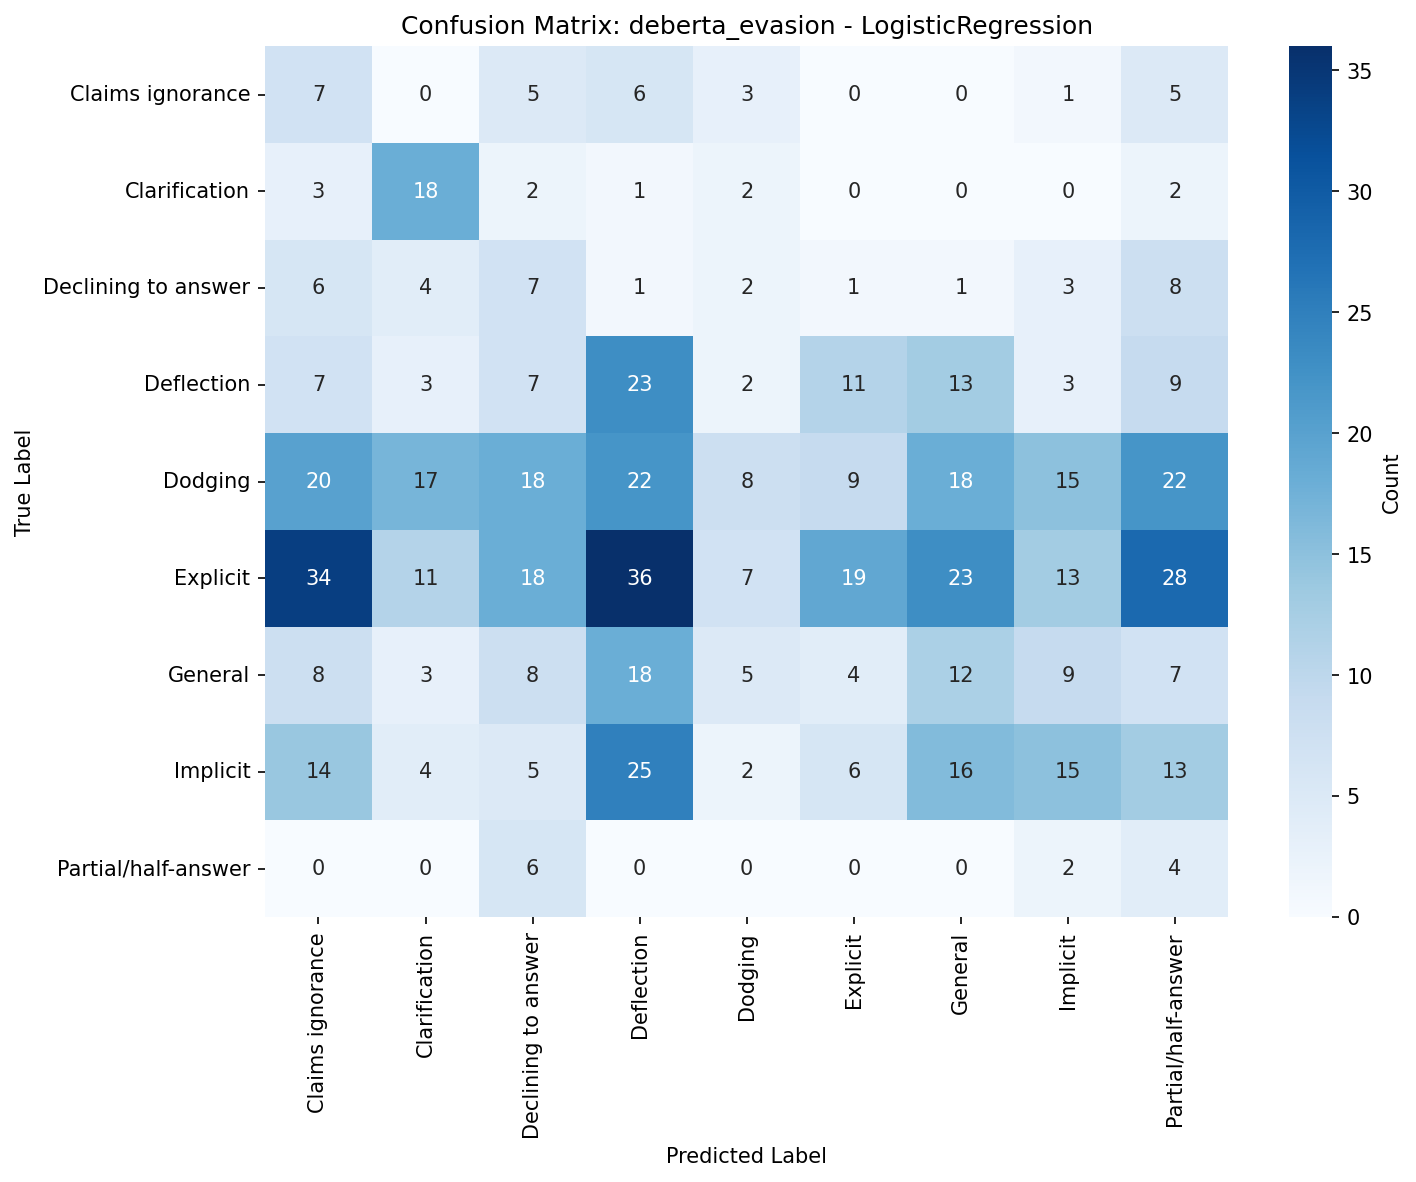

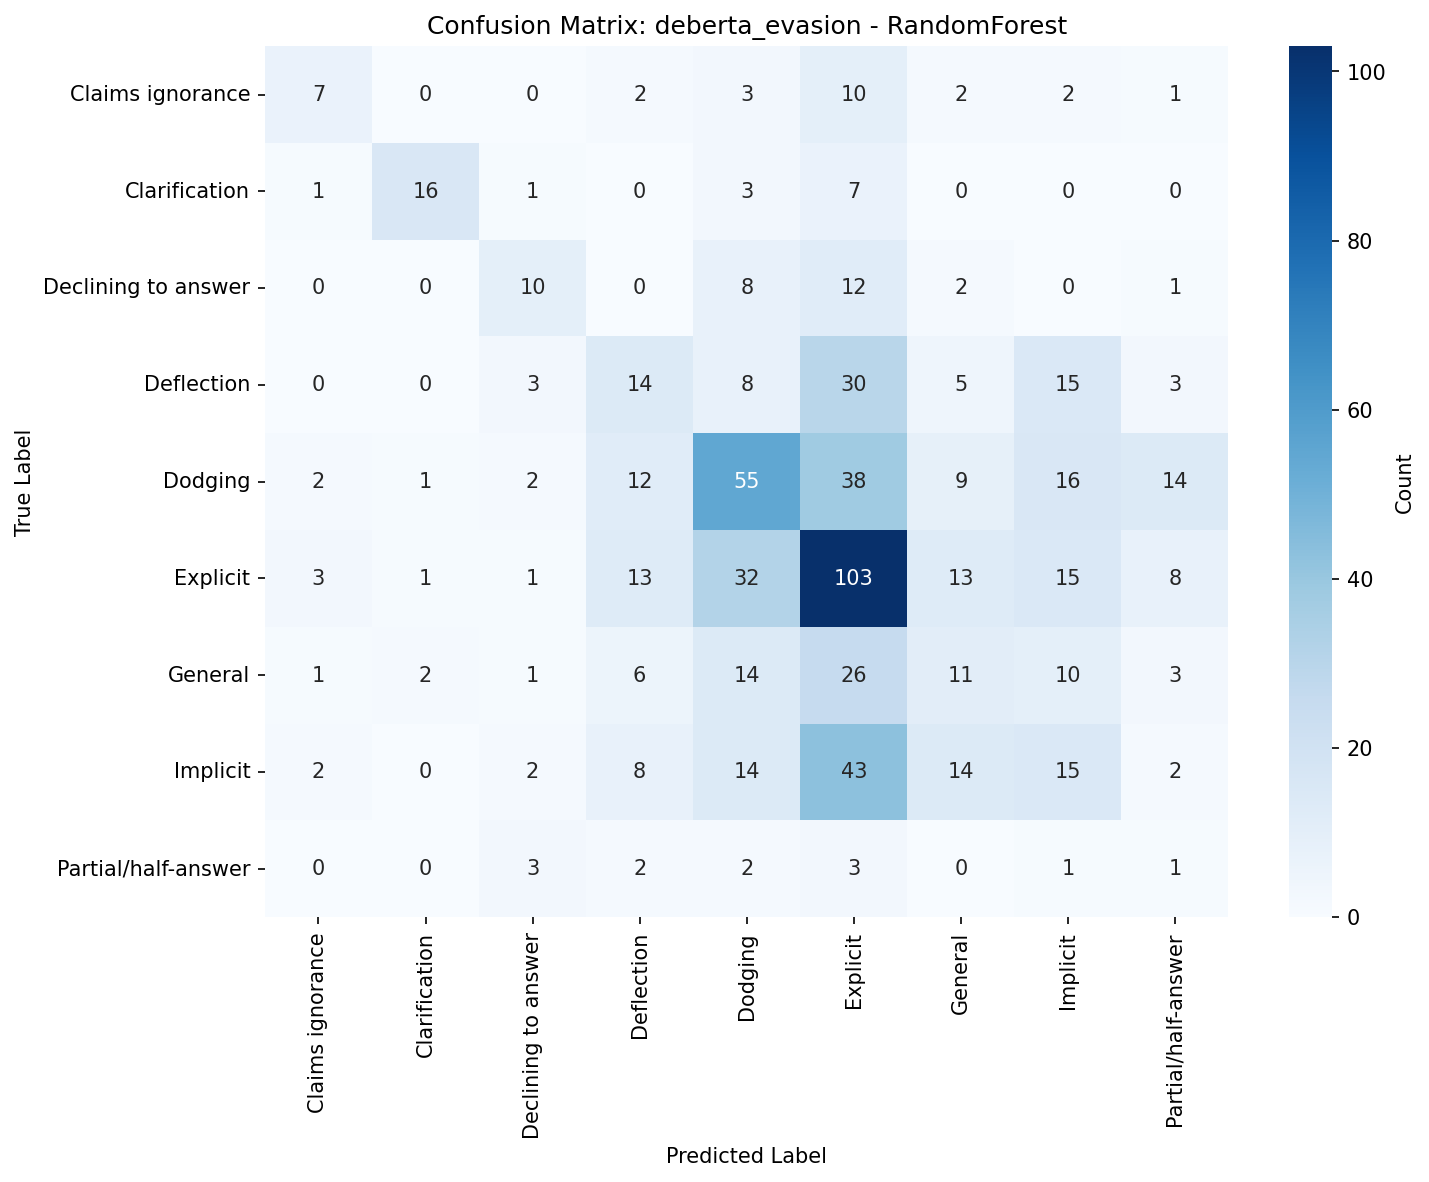

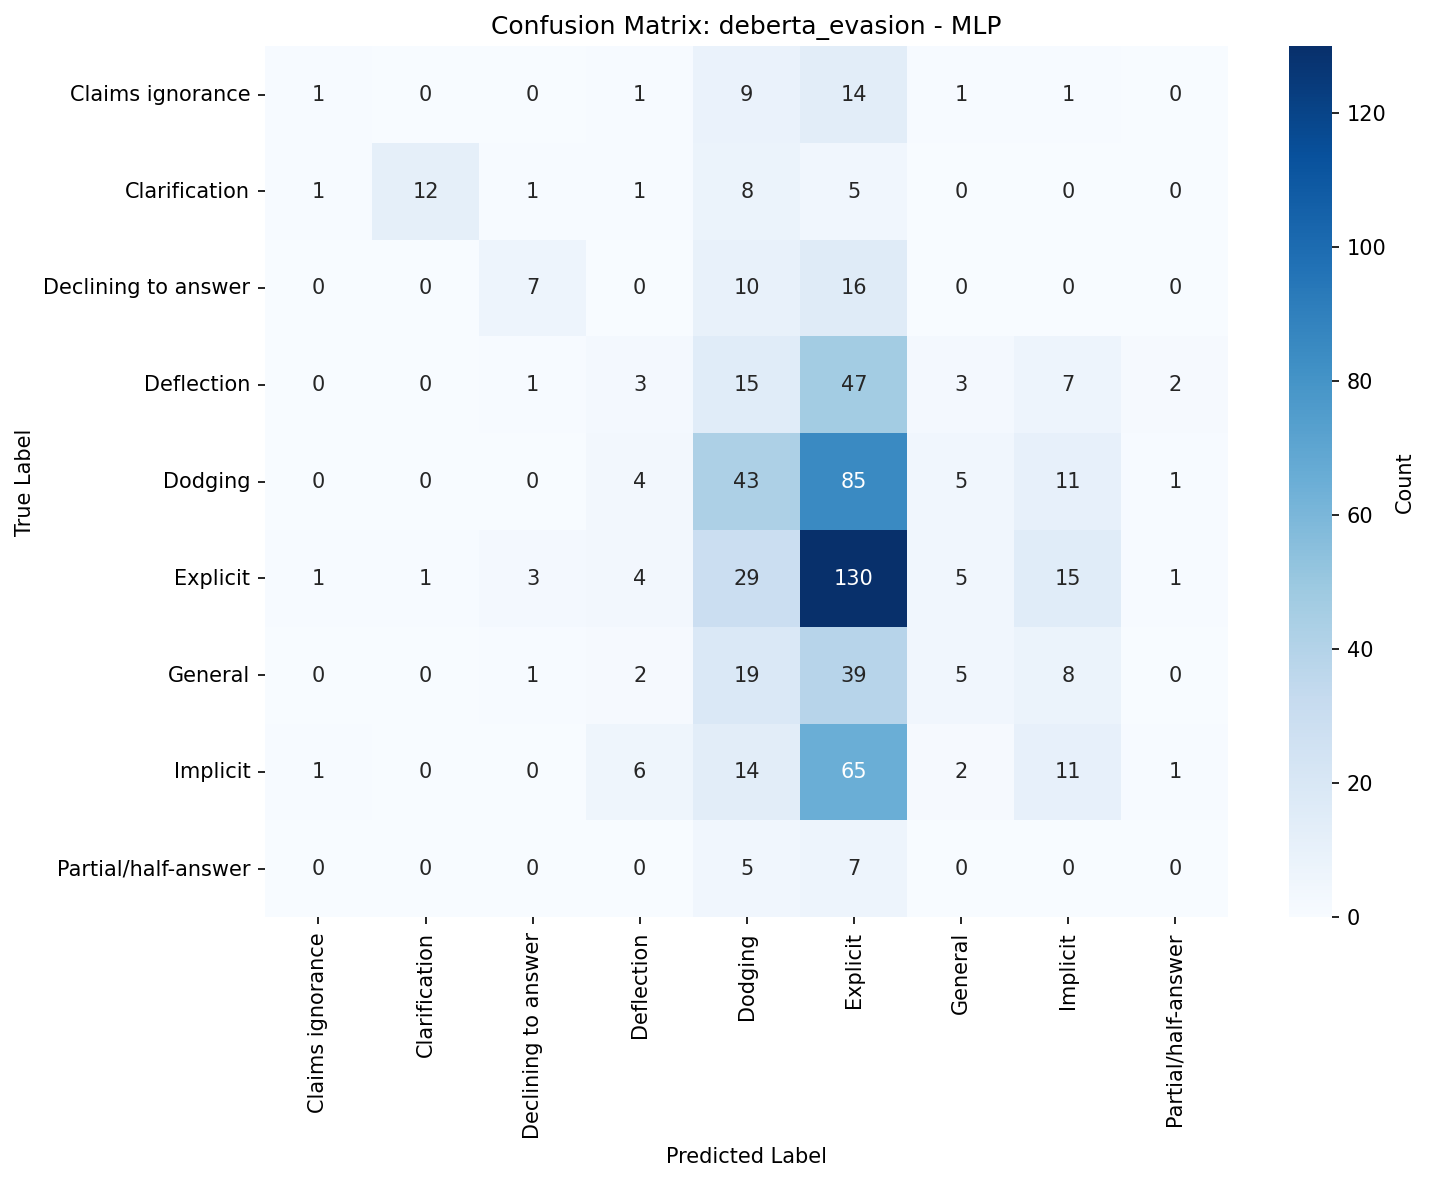

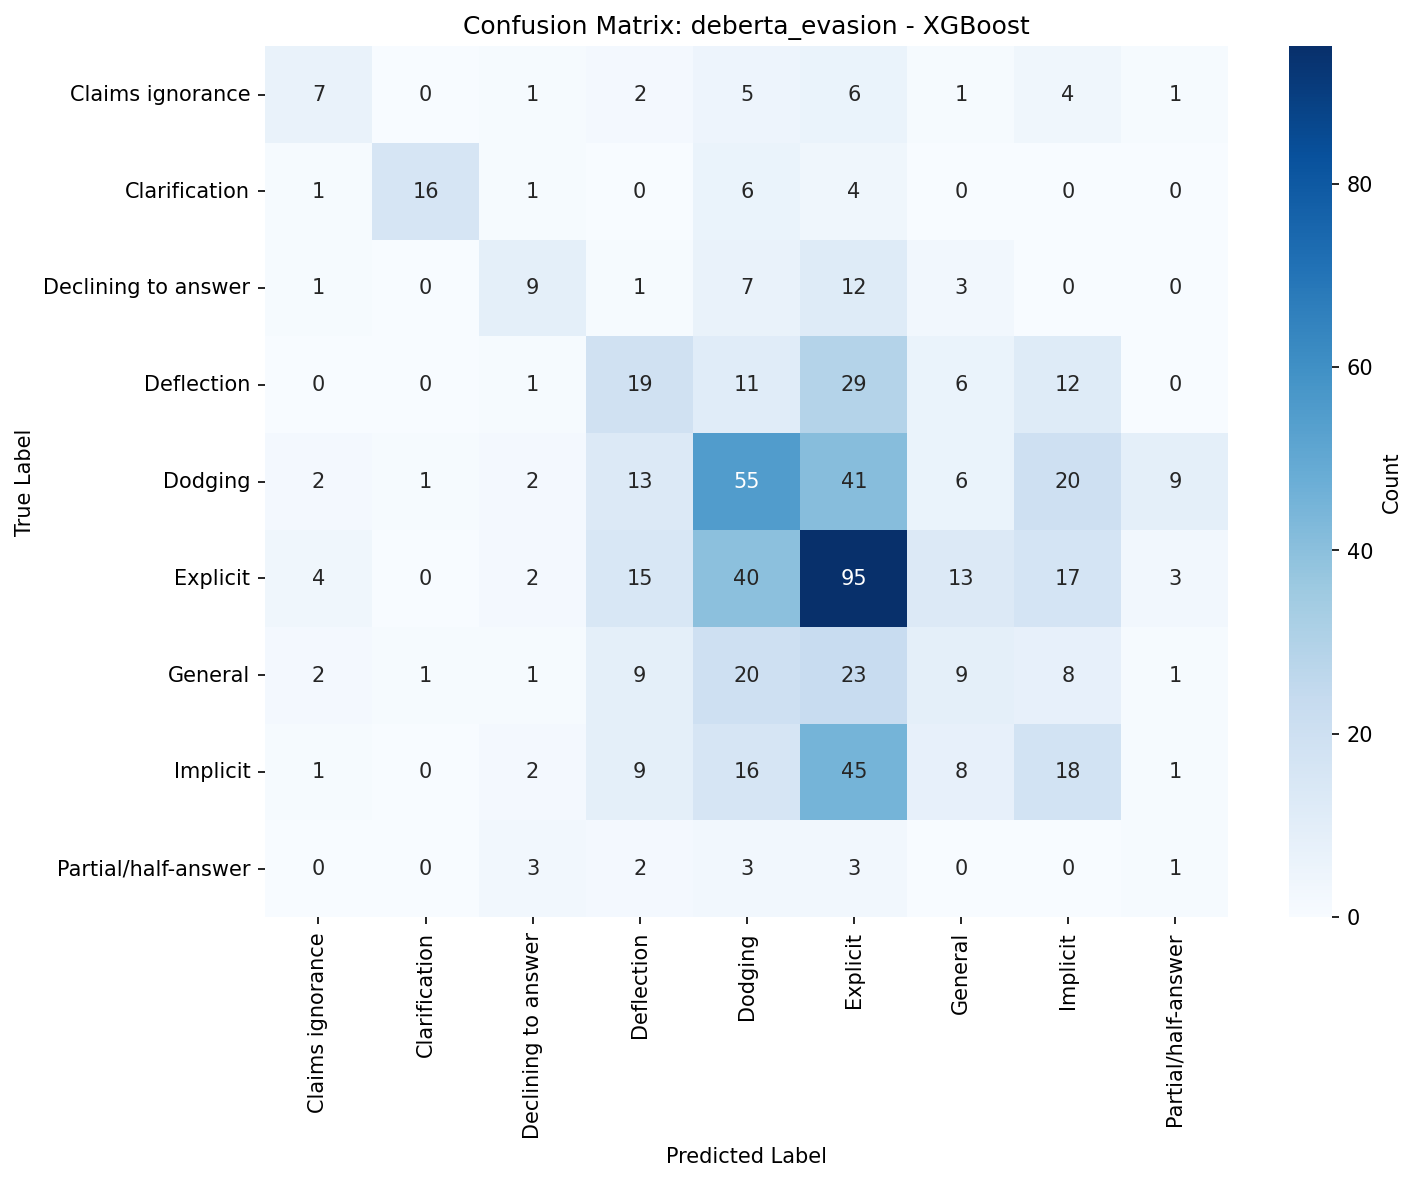

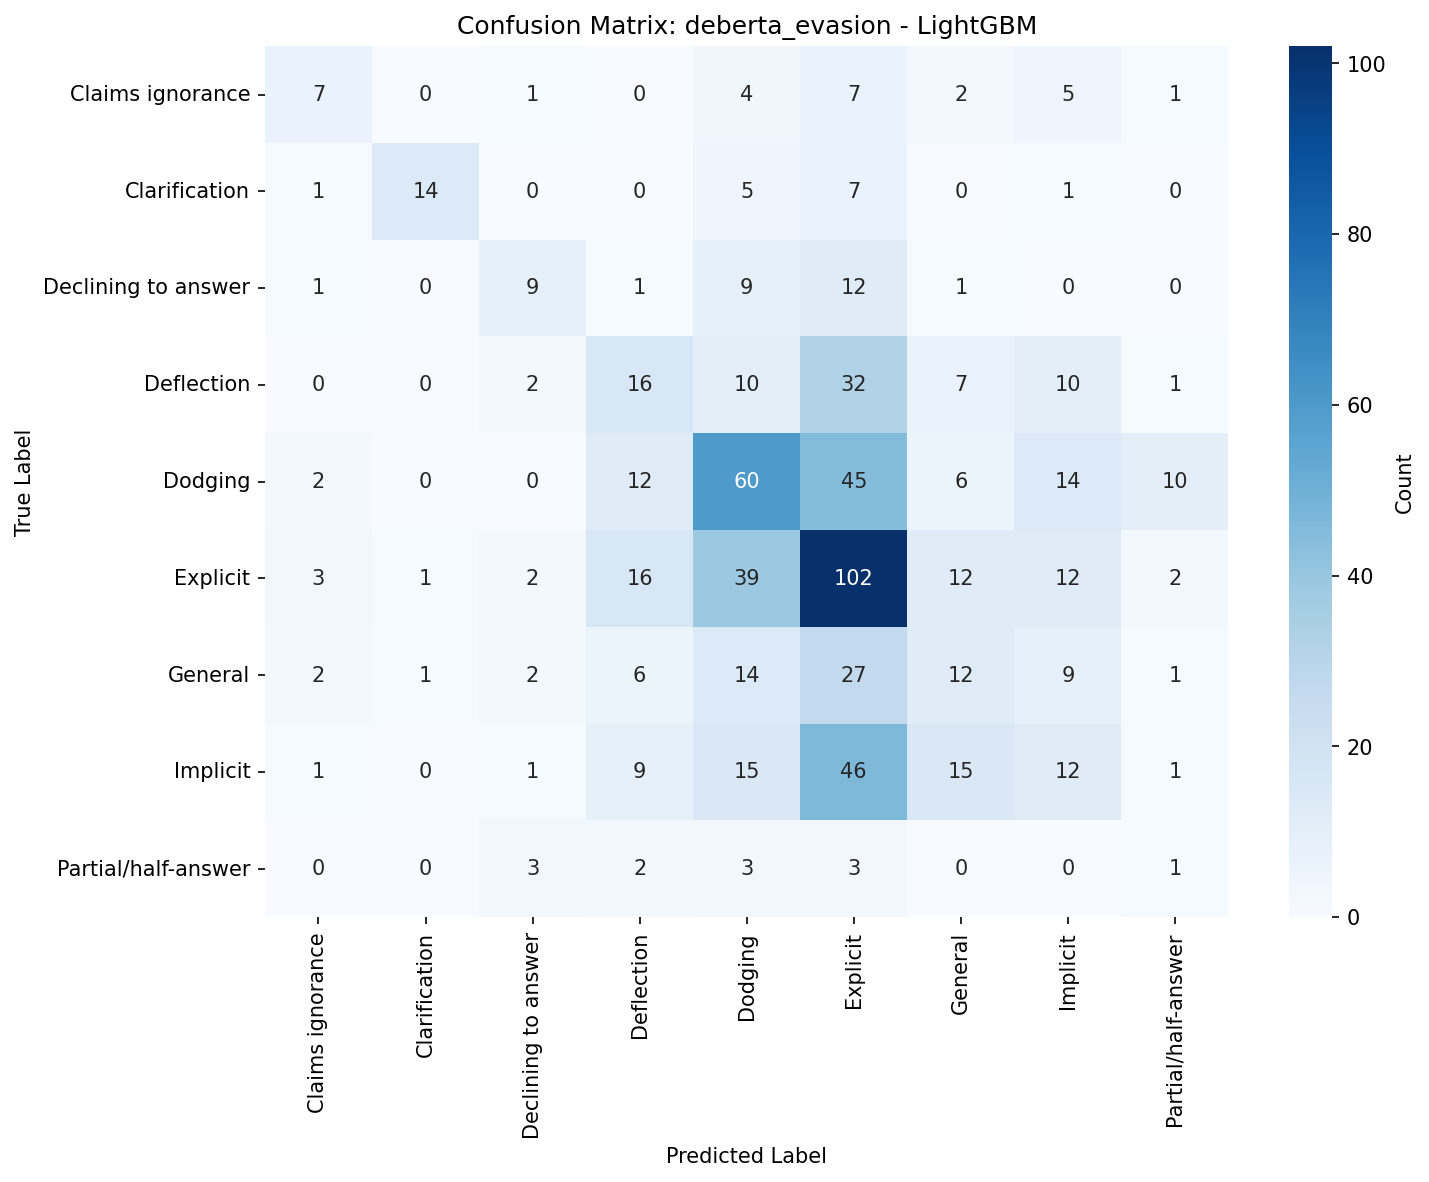


Results Table: xlnet_clarity
        Classifier          Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
           XGBoost xlnet_clarity  0.592754  0.506444     0.580160         0.547541      0.486599
      RandomForest xlnet_clarity  0.584058  0.504354     0.570461         0.542635      0.484959
          LightGBM xlnet_clarity  0.585507  0.488209     0.566101         0.538208      0.468104
         LinearSVC xlnet_clarity  0.566667  0.436758     0.535746         0.457682      0.442418
LogisticRegression xlnet_clarity  0.462319  0.430482     0.477270         0.427491      0.476223
               MLP xlnet_clarity  0.618841  0.391278     0.526291         0.664583      0.402625

Per-Class Metrics: xlnet_clarity - XGBoost (Best by Macro F1)
          Class  Precision   Recall  F1-Score  Support
     Ambivalent   0.657505 0.753027  0.702032      413
Clear Non-Reply   0.574074 0.352273  0.436620       88
    Clear Reply   0.411043 0.354497  0.380682      189



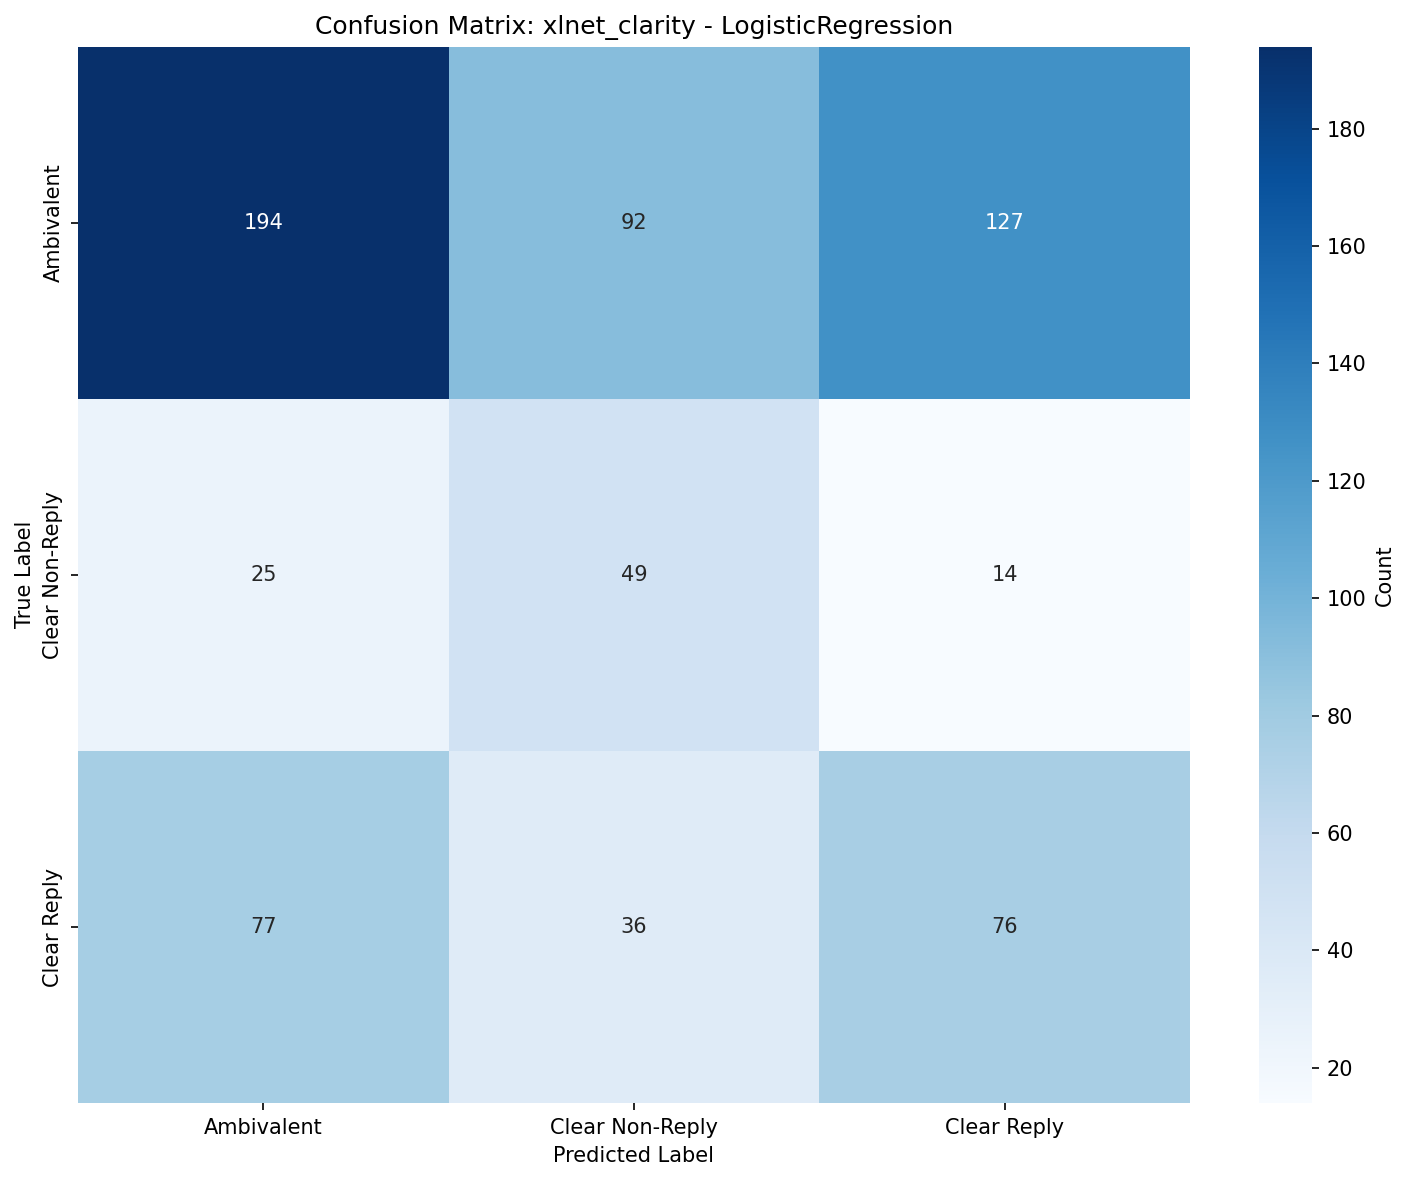

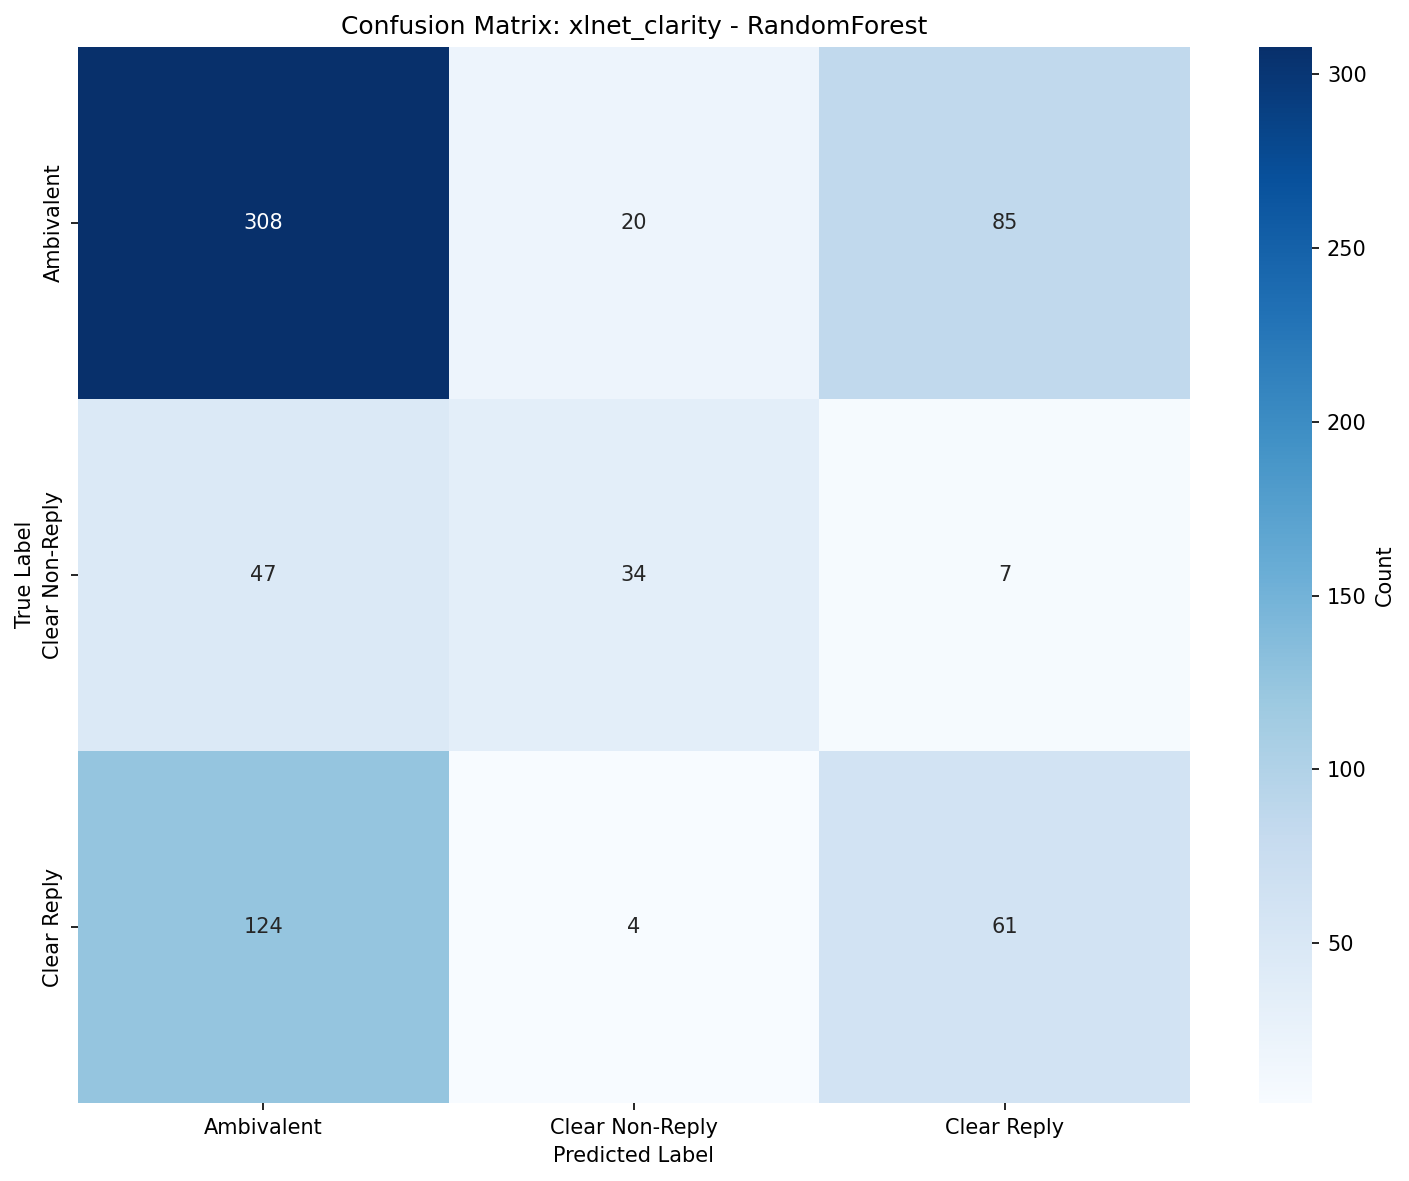

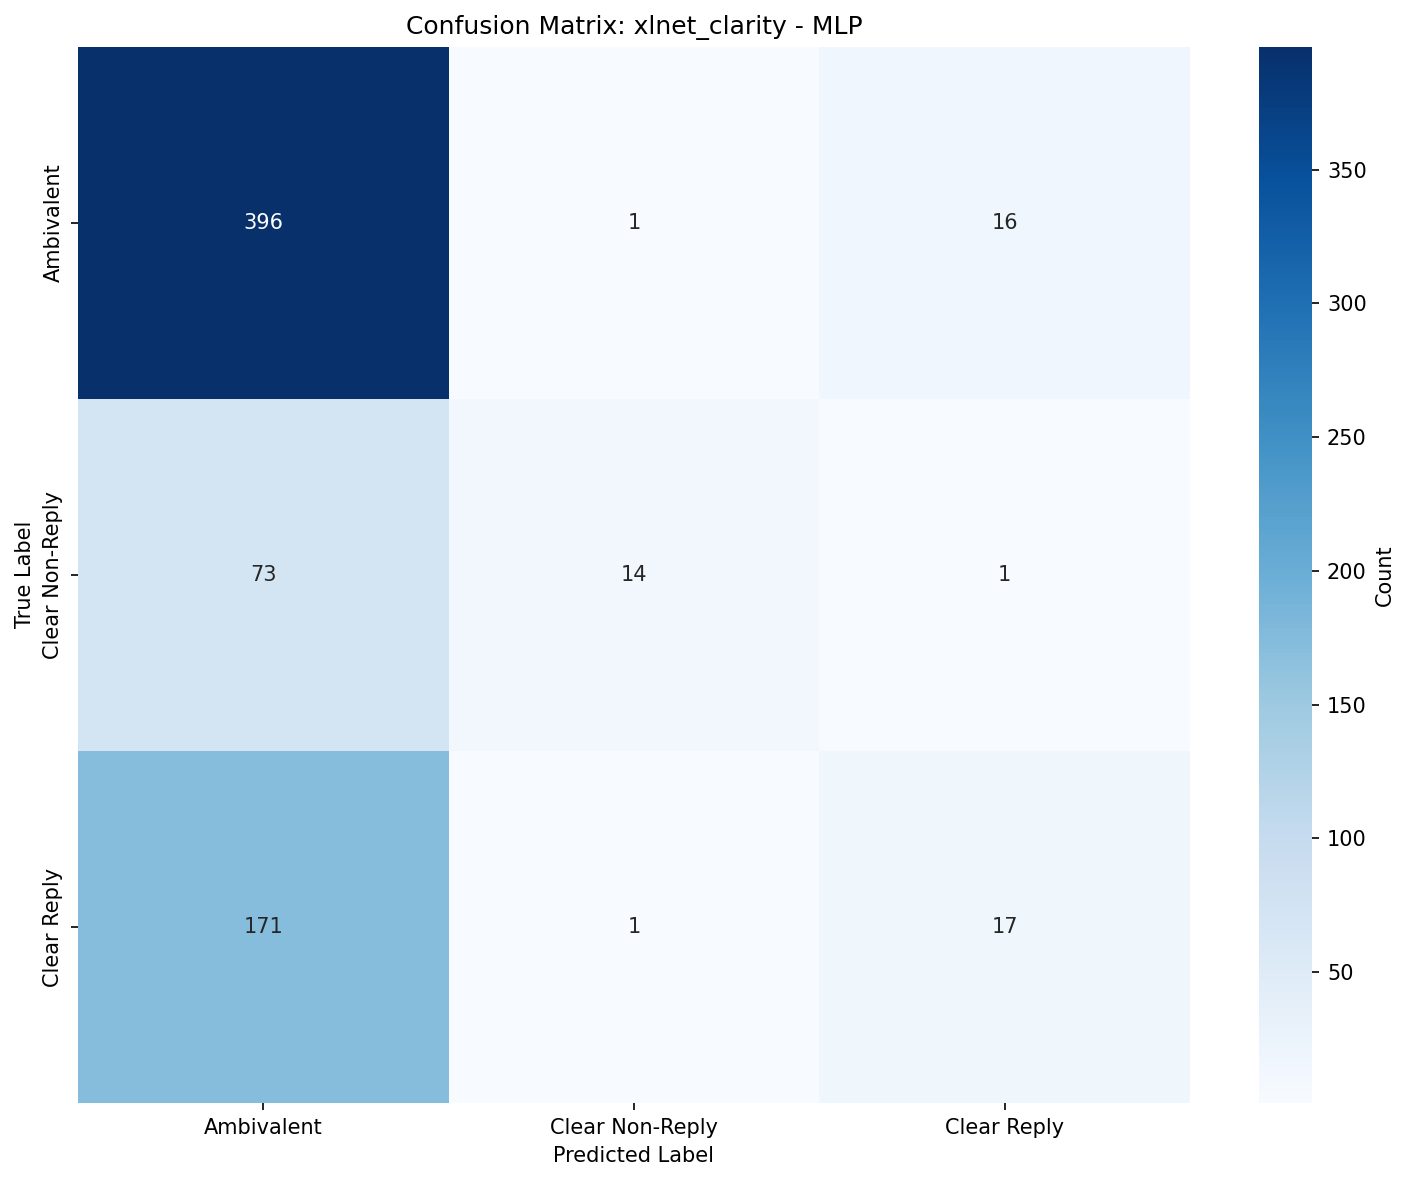

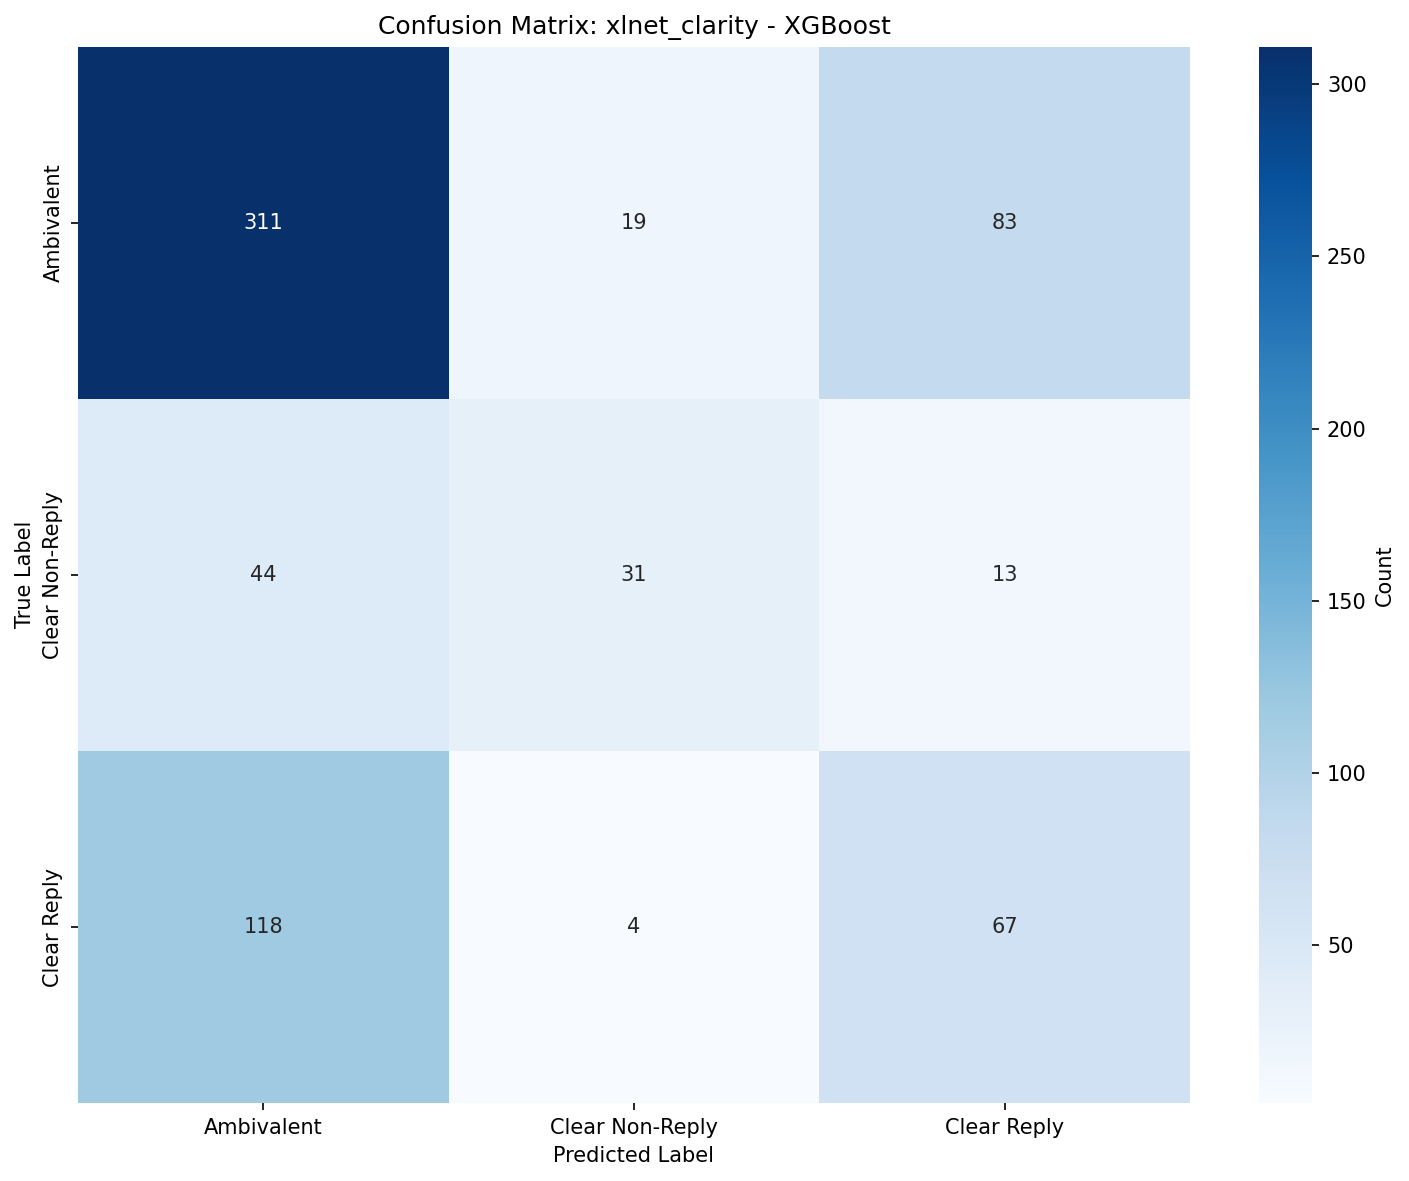

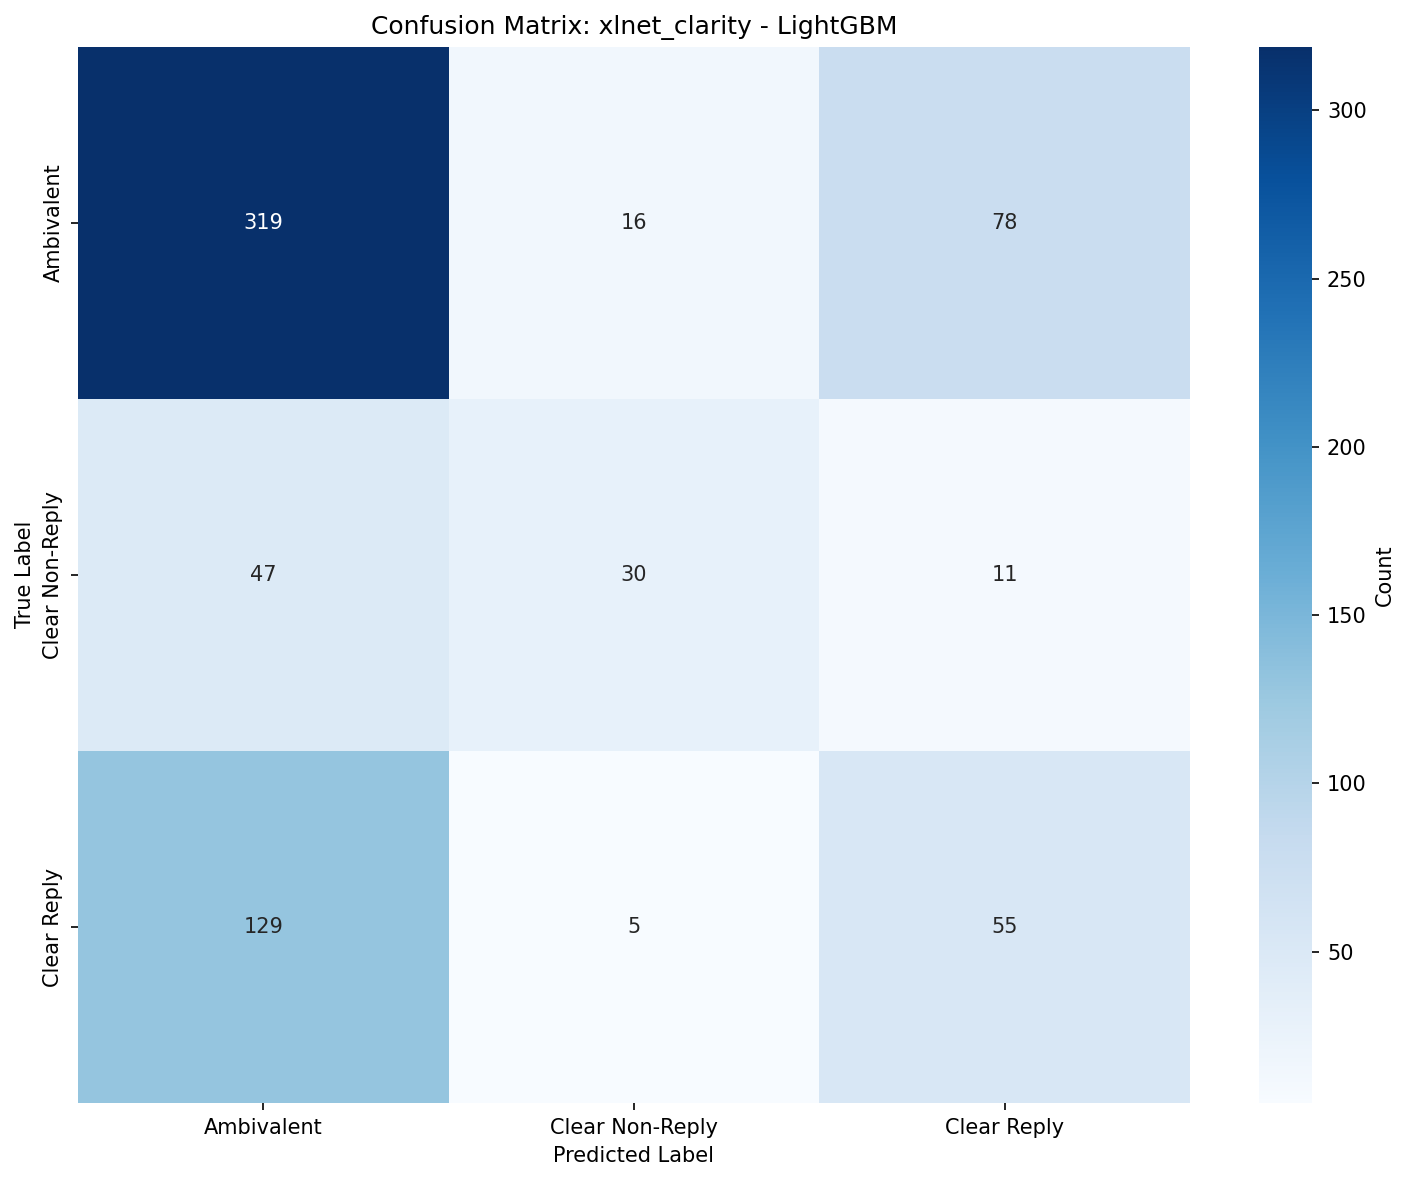


Results Table: xlnet_evasion
        Classifier          Task  Accuracy  Macro F1  Weighted F1  Macro Precision  Macro Recall
      RandomForest xlnet_evasion  0.334783  0.306979     0.325364         0.350763      0.288282
           XGBoost xlnet_evasion  0.321739  0.299296     0.313584         0.359601      0.272785
          LightGBM xlnet_evasion  0.334783  0.296170     0.324241         0.351580      0.272211
         LinearSVC xlnet_evasion  0.231884  0.203173     0.232021         0.200428      0.256849
LogisticRegression xlnet_evasion  0.179710  0.181939     0.180233         0.206117      0.255565
               MLP xlnet_evasion  0.294203  0.153980     0.205481         0.187734      0.173758

Per-Class Metrics: xlnet_evasion - RandomForest (Best by Macro F1)
              Class  Precision   Recall  F1-Score  Support
   Claims ignorance   0.428571 0.222222  0.292683       27
      Clarification   0.761905 0.571429  0.653061       28
Declining to answer   0.476190 0.303030  0.370

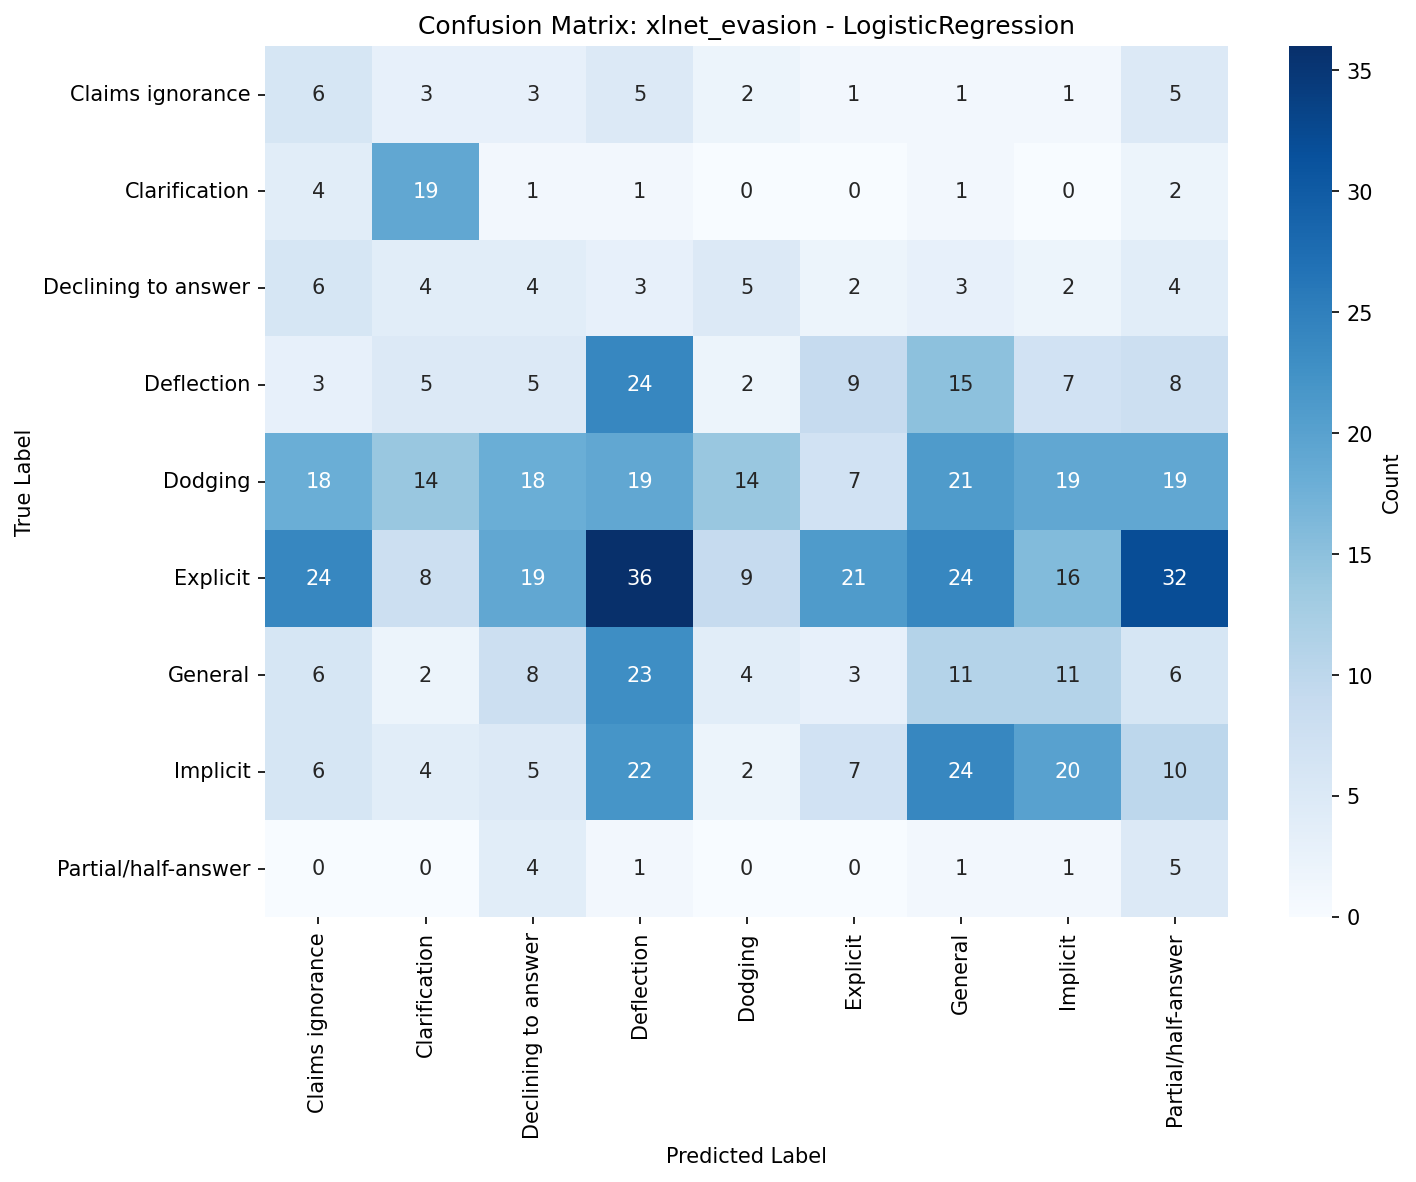

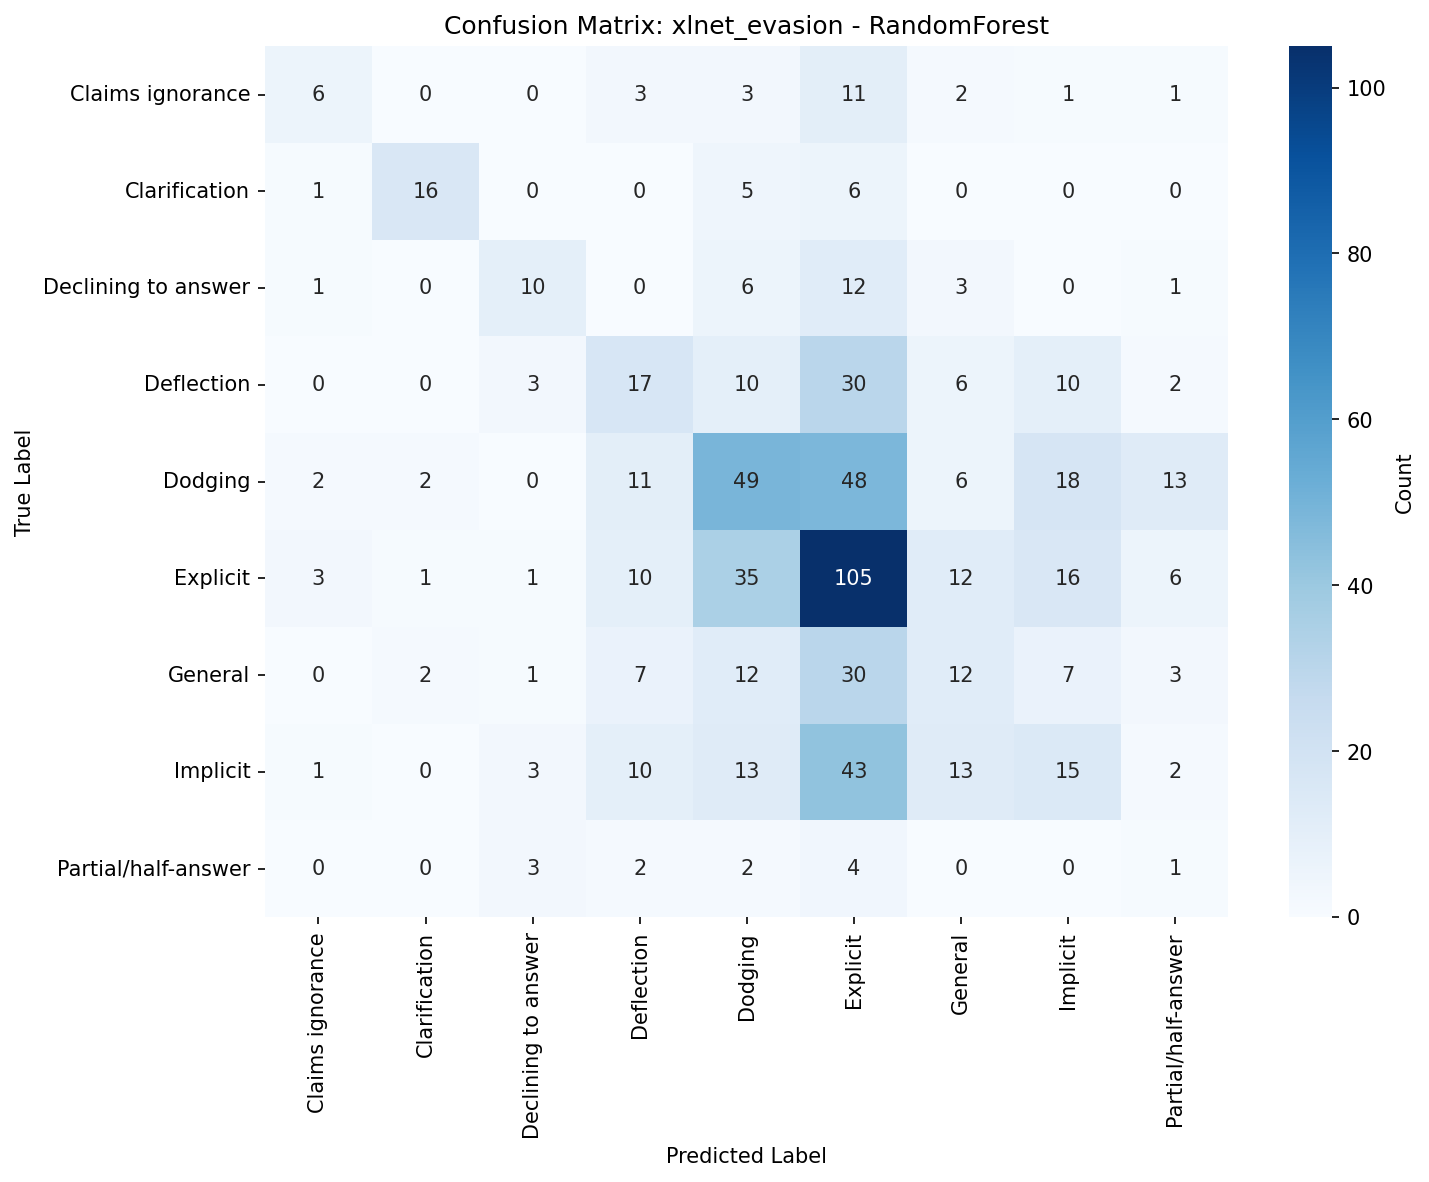

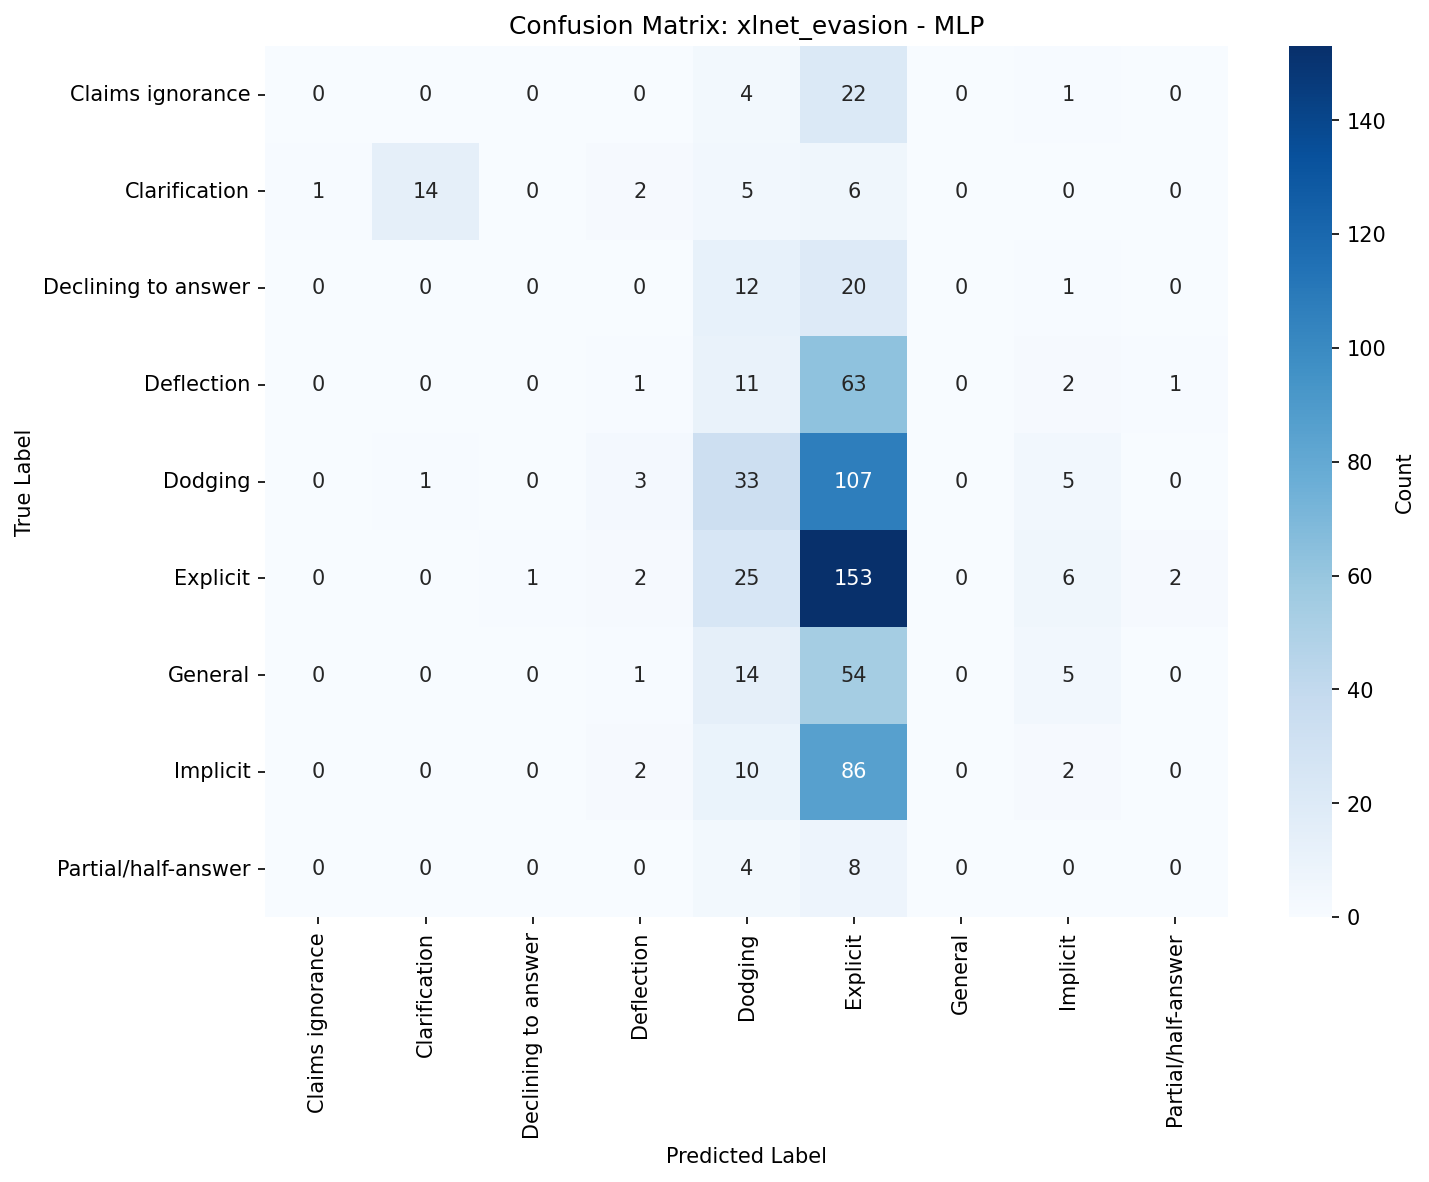

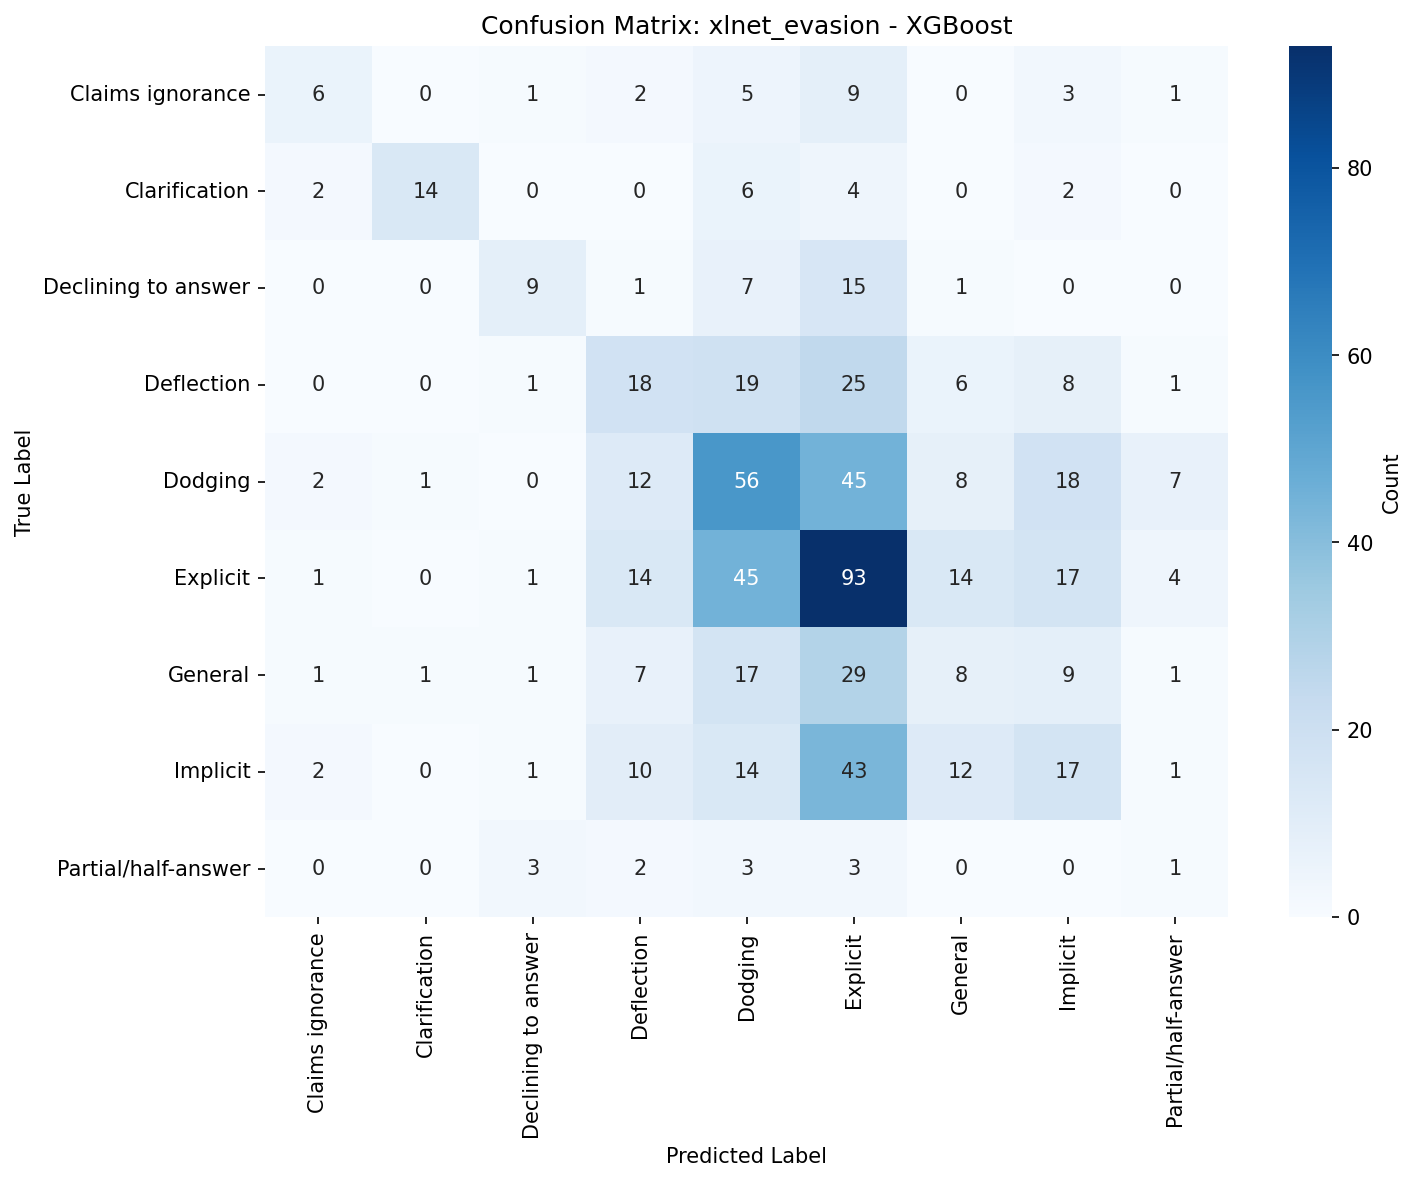

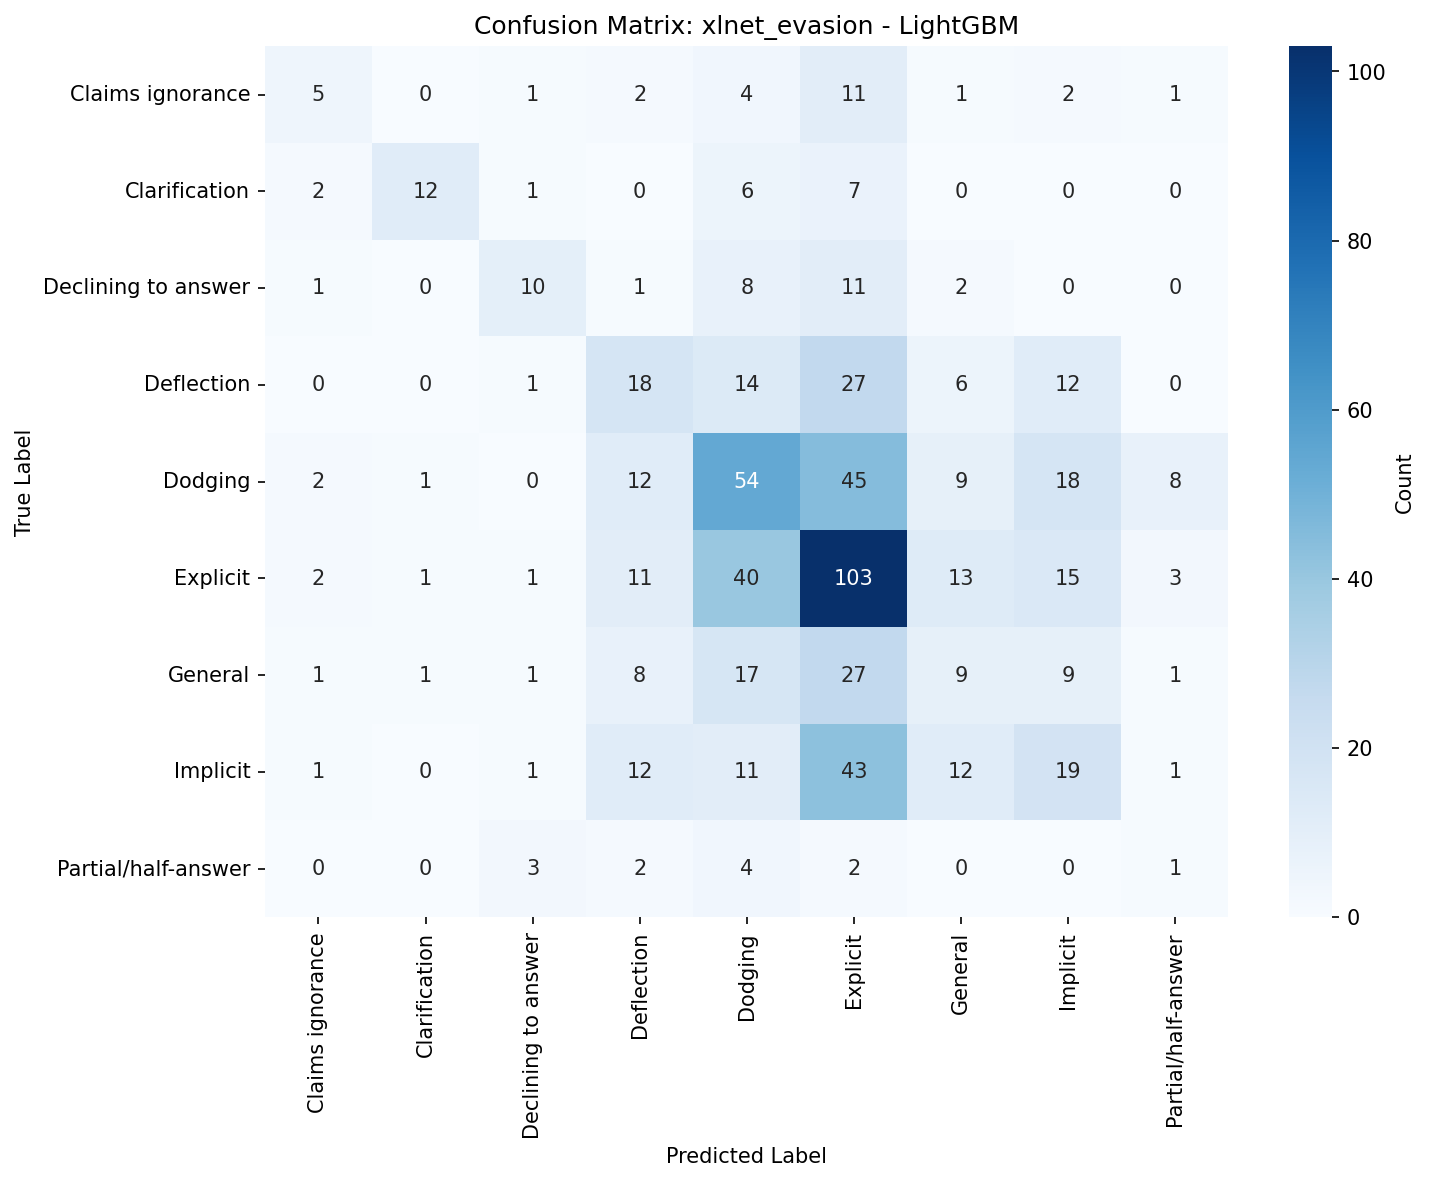

In [5]:
# ============================================================================
# TRAIN AND EVALUATE CLASSIFIERS FOR EACH MODEL AND TASK
# ============================================================================
# Iterates through each model and task, trains all classifiers, and evaluates
# on the Dev set. Results are saved for later analysis and final summary generation.

all_results = {}

for model in MODELS:
    all_results[model] = {}

    for task in TASKS:
        # Select appropriate label list and dataset key for this task
        if task == 'clarity':
            label_list = CLARITY_LABELS
            label_key = 'clarity_label'
        else:  # evasion
            label_list = EVASION_LABELS
            label_key = 'evasion_label'

        # Load task-specific splits (Clarity and Evasion have different splits)
        # Evasion splits are filtered by majority voting
        train_ds = storage.load_split('train', task=task)
        dev_ds = storage.load_split('dev', task=task)

        # Load features from persistent storage
        X_train = storage.load_features(model, task, 'train')
        X_dev = storage.load_features(model, task, 'dev')

        # Extract labels from dataset splits
        y_train = np.array([train_ds[i][label_key] for i in range(len(train_ds))])
        y_dev = np.array([dev_ds[i][label_key] for i in range(len(dev_ds))])

        # Train all classifiers and evaluate on Dev set
        # This function handles training, prediction, metric computation, and visualization
        results = train_and_evaluate(
            X_train, y_train, X_dev, y_dev,
            label_list=label_list,
            task_name=f"{model}_{task}",
            classifiers=classifiers,
            random_state=42,
            print_report=False,     # Don't print classification reports
            print_table=True,       # Print results comparison table only
            create_plots=True,      # Generate confusion matrices and PR/ROC curves (silently)
            save_plots_dir=str(DATA_PATH / 'plots')
        )

        # Save predictions and probabilities to persistent storage
        # These will be used for further analysis and final summary generation
        for classifier_name, result in results.items():
            # Save hard label predictions
            storage.save_predictions(
                result['dev_pred'],
                model, classifier_name, task, 'dev'
            )

            # Save probability distributions (if classifier supports it)
            if result['dev_proba'] is not None:
                storage.save_probabilities(
                    result['dev_proba'],
                    model, classifier_name, task, 'dev'
                )

        all_results[model][task] = results

        # Save results summary to metadata for final summary generation
        experiment_id = f"{model}_{task}_separate"
        storage.save_results({
            'model': model,
            'task': task,
            'results': {
                name: {
                    'metrics': res['metrics'],
                    'n_train': len(y_train),
                    'n_dev': len(y_dev)
                }
                for name, res in results.items()
            }
        }, experiment_id)


<div style="font-size: 8px;">

# ============================================================================
# HIERARCHICAL EVASION → CLARITY APPROACH
# ============================================================================
# This cell implements the hierarchical approach where evasion predictions
# are mapped to clarity predictions using a predefined mapping function.
# This approach leverages the hierarchical relationship between evasion
# (fine-grained) and clarity (coarse-grained) labels.
#
# This is treated as a 3rd task alongside Clarity and Evasion:
# 1. Task 1: Clarity (direct classification)
# 2. Task 2: Evasion (direct classification)
# 3. Task 3: EvasionBasedClarity (mapping-based)
#
# All three tasks save predictions, probabilities, and results metadata
# to Drive and GitHub, just like the direct classification tasks.

</div>


In [6]:
# ============================================================================
# HIERARCHICAL EVALUATION: EVASION PREDICTIONS → CLARITY PREDICTIONS
# ============================================================================
# For each model, uses evasion predictions to generate clarity predictions
# via hierarchical mapping, then evaluates against true clarity labels
# This is treated as a 3rd task alongside Clarity and Evasion
#
# Saves predictions, probabilities, and results metadata just like other tasks

from src.models.hierarchical import evaluate_hierarchical_approach
from sklearn.preprocessing import LabelEncoder
import numpy as np

# CRITICAL: Load evasion dev split to get clarity labels for the SAME samples
# Evasion predictions are on evasion dev set, so we need clarity labels from the same samples
# Using clarity dev set would be wrong because it has different samples (unfiltered vs filtered)
dev_ds_evasion = storage.load_split('dev', task='evasion')

# Helper function to convert numpy types to JSON-serializable types
def make_json_serializable(obj):
    """Recursively convert numpy arrays and types to JSON-serializable Python types"""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, bool):
        return bool(obj)
    elif hasattr(np, 'bool_') and isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, dict):
        return {key: make_json_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [make_json_serializable(item) for item in obj]
    else:
        return obj

# Get true clarity labels from evasion dev set (same samples as evasion predictions)
y_clarity_true = np.array([dev_ds_evasion[i]['clarity_label'] for i in range(len(dev_ds_evasion))])

# Encode clarity labels for evaluation (hierarchical function expects encoded)
le_clarity = LabelEncoder()
y_clarity_true_encoded = le_clarity.fit_transform(y_clarity_true)

for model in MODELS:
    # Check if we have evasion predictions for this model
    if 'evasion' not in all_results.get(model, {}):
        continue

    # Get evasion predictions and true labels
    evasion_results = all_results[model]['evasion']

    # Initialize hierarchical results for this model
    if model not in all_results:
        all_results[model] = {}
    if 'evasion_based_clarity' not in all_results[model]:
        all_results[model]['evasion_based_clarity'] = {}

    # Evaluate hierarchical approach for EACH classifier (not just best)
    for clf_name, clf_result in evasion_results.items():
        # Skip if no predictions available
        if 'dev_pred' not in clf_result:
            continue

        # Get predictions (already string labels from train_classifiers)
        y_evasion_pred = clf_result['dev_pred']

        # Ensure predictions match clarity labels length
        if len(y_evasion_pred) != len(y_clarity_true_encoded):
            print(f"WARNING: Mismatch in prediction length for {model}-{clf_name}. Skipping hierarchical evaluation.")
            continue

        # Evaluate hierarchical approach
        # y_evasion_pred is already string labels, y_clarity_true_encoded is encoded
        # We pass dummy encoded evasion_true (not used in mapping, only for consistency)
        y_evasion_true_dummy = np.zeros(len(y_evasion_pred), dtype=int)  # Dummy, not used

        hierarchical_metrics = evaluate_hierarchical_approach(
            y_evasion_true_dummy,  # Not used in mapping, only for function signature
            y_evasion_pred,  # String labels - function will handle both string and int
            y_clarity_true_encoded,  # Encoded integers
            EVASION_LABELS,
            CLARITY_LABELS
        )

        # Store hierarchical results in same format as other tasks
        all_results[model]['evasion_based_clarity'][clf_name] = {
            'metrics': hierarchical_metrics,
            'dev_pred': hierarchical_metrics['predictions'],
            'dev_proba': None  # Hierarchical approach doesn't produce probabilities
        }

        # Save predictions to Drive (just like other tasks)
        storage.save_predictions(
            hierarchical_metrics['predictions'],
            model, clf_name, 'evasion_based_clarity', 'dev'
        )

        # Save results summary to metadata (just like other tasks)
        # Convert all numpy types in hierarchical_metrics to JSON-serializable types
        metrics_for_json = make_json_serializable(hierarchical_metrics)

        experiment_id = f"{model}_{clf_name}_evasion_based_clarity_separate"
        storage.save_results({
            'model': model,
            'task': 'evasion_based_clarity',
            'evasion_classifier': clf_name,
            'evasion_f1': float(clf_result.get('metrics', {}).get('macro_f1', 0.0)),  # Ensure float, not numpy float
            'results': {
                clf_name: {
                    'metrics': metrics_for_json,
                    'n_dev': int(len(y_clarity_true))  # Ensure int, not numpy int
                }
            }
        }, experiment_id)


<div style="font-size: 8px;">

TABULAROTARY ANALAYSIS

</div>

In [10]:
# ============================================================================
# FINAL SUMMARY GENERATION
# ============================================================================
# Generate summary tables and save all results
# Includes 2 tasks: Clarity and EvasionBasedClarity (mapping)
#
# Creates separate tables:
# 1. MODEL-WISE: For each model, shows Classifier × Tasks
# 2. CLASSIFIER-WISE: For each classifier, shows Model × Tasks
#
# Simple, clean tables: Only bold for column-wise max values

import pandas as pd
from IPython.display import display, HTML

# ----------------------------------------------------------------------------
# Helper function: bold max value in each column
# ----------------------------------------------------------------------------
def bold_max_in_column(col):
    is_max = col == col.max()
    return ['font-weight: bold' if v else '' for v in is_max]

# ----------------------------------------------------------------------------
# Save all_results dictionary to persistent storage
# ----------------------------------------------------------------------------
storage.save_all_results_dict(all_results, filename='all_results_dev.pkl')

# ----------------------------------------------------------------------------
# Extract classifier names from results
# ----------------------------------------------------------------------------
classifier_names = set()
all_tasks = ['clarity', 'evasion_based_clarity']

for model in MODELS:
    if model in all_results:
        for task in all_tasks:
            if task in all_results[model]:
                classifier_names.update(all_results[model][task].keys())

classifier_names = sorted(list(classifier_names))

# ============================================================================
# CREATE SUMMARY DATAFRAME
# ============================================================================
summary_rows = []

for model in MODELS:
    if model not in all_results:
        continue

    for classifier in classifier_names:
        for task in all_tasks:
            if task not in all_results[model]:
                continue
            if classifier not in all_results[model][task]:
                continue

            result = all_results[model][task][classifier]
            if 'metrics' in result:
                metrics = result['metrics']
                summary_rows.append({
                    'model': model,
                    'classifier': classifier,
                    'task': task,
                    'macro_f1': metrics.get('macro_f1', 0.0),
                    'weighted_f1': metrics.get('weighted_f1', 0.0),
                    'accuracy': metrics.get('accuracy', 0.0)
                })

# ============================================================================
# BUILD & DISPLAY TABLES
# ============================================================================
if not summary_rows:
    print("WARNING: No results available for summary tables")

else:
    df_summary = pd.DataFrame(summary_rows)

    # Remove duplicates (safety)
    df_summary = df_summary.drop_duplicates(
        subset=['model', 'classifier', 'task'],
        keep='first'
    )

    # ========================================================================
    # MODEL-WISE TABLES: Classifier × Tasks
    # ========================================================================
    print("=" * 100)
    print("FINAL SUMMARY — MODEL-WISE (Classifier × Tasks)")
    print("=" * 100)

    for model_name in sorted(df_summary['model'].unique()):
        display(HTML(f"MODEL: {model_name.upper()}"))

        df_model = df_summary[df_summary['model'] == model_name]

        df_model = df_model.drop_duplicates(
            subset=['classifier', 'task'],
            keep='first'
        )

        try:
            pivot_model = df_model.pivot(
                index='classifier',
                columns='task',
                values='macro_f1'
            )

            styled_model = (
                pivot_model
                .style
                .format(precision=4)
                .apply(bold_max_in_column, axis=0)
            )

            display(styled_model)

            table_name_model = f"model_wise_{model_name}"
            storage.save_table(
                styled_model,
                table_name=table_name_model,
                formats=['csv', 'html']
            )

        except Exception as e:
            print(f" Error creating table for {model_name}: {e}")

    # ========================================================================
    # CLASSIFIER-WISE TABLES: Model × Tasks
    # ========================================================================
    print("\n" + "=" * 100)
    print("FINAL SUMMARY — CLASSIFIER-WISE (Model × Tasks)")
    print("=" * 100)

    for clf_name in sorted(df_summary['classifier'].unique()):
        display(HTML(f"CLASSIFIER: {clf_name.upper()}"))

        df_clf = df_summary[df_summary['classifier'] == clf_name]

        df_clf = df_clf.drop_duplicates(
            subset=['model', 'task'],
            keep='first'
        )

        try:
            pivot_clf = df_clf.pivot(
                index='model',
                columns='task',
                values='macro_f1'
            )

            styled_clf = (
                pivot_clf
                .style
                .format(precision=4)
                .apply(bold_max_in_column, axis=0)
            )

            display(styled_clf)

            table_name_clf = f"classifier_wise_{clf_name}"
            storage.save_table(
                styled_clf,
                table_name=table_name_clf,
                formats=['csv', 'html']
            )

        except Exception as e:
            print(f" Error creating table for {clf_name}: {e}")


FINAL SUMMARY — MODEL-WISE (Classifier × Tasks)


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/model_wise_bert.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/model_wise_bert.html


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/model_wise_bert_ambiguity.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/model_wise_bert_ambiguity.html


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/model_wise_bert_political.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/model_wise_bert_political.html


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/model_wise_deberta.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/model_wise_deberta.html


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/model_wise_roberta.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/model_wise_roberta.html


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/model_wise_xlnet.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/model_wise_xlnet.html

FINAL SUMMARY — CLASSIFIER-WISE (Model × Tasks)


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_LightGBM.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_LightGBM.html


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_LinearSVC.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_LinearSVC.html


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_LogisticRegression.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_LogisticRegression.html


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_MLP.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_MLP.html


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_RandomForest.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_RandomForest.html


Saved table (CSV): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_XGBoost.csv
Saved table (HTML): /content/drive/MyDrive/semeval_data/results/tables/classifier_wise_XGBoost.html
